## KAN RL

In [1]:
!pip install gymnasium pykan~=0.0.2

## Models

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 50564944.89it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 1473688.17it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 12743183.59it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2097382.89it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



State shape: torch.Size([1, 8, 8])
Label: tensor(7)
Feedback shape: torch.Size([1, 8, 8])


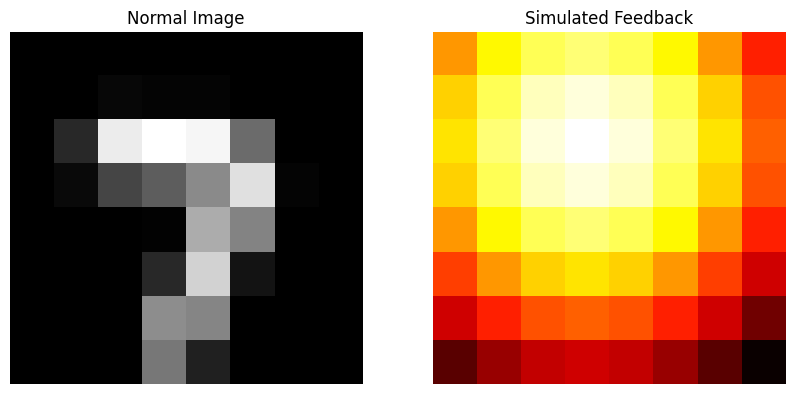

tensor(0.4404) tensor(1.)


In [2]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# https://github.com/Armour/pytorch-nn-practice/blob/master/utils/meanstd.py  for normalization values computation

class BenchmarkEnvironment:
    def __init__(self, dataset_name='MNIST', batch_size=128, image_size=(8, 8), feedback_sigma=5.0):
        self.batch_size = batch_size
        self.image_size = image_size
        self.feedback_sigma = feedback_sigma
        self.num_channels = 1  # Force single channel for all datasets

        if dataset_name == 'MNIST':
            # self.num_channels = 1
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])
            self.dataset = datasets.MNIST('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'FashionMNIST':
            # self.num_channels = 1
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
            self.dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'CIFAR10':
            # self.num_channels = 3
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            ])
            self.dataset = datasets.CIFAR10('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'CIFAR100':
            # self.num_channels = 3
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)),
                transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            ])
            self.dataset = datasets.CIFAR100('./data', train=True, download=True, transform=self.transform)

        else:
            raise ValueError(f"Dataset {dataset_name} is not supported.")

        self.loader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)
        self.iterator = iter(self.loader)
        self.reset()

    def reset(self):
        try:
            self.current_batch = next(self.iterator)
        except StopIteration:
            self.iterator = iter(self.loader)
            self.current_batch = next(self.iterator)
        self.idx = 0

    def step(self):
        images, labels = self.current_batch
        if self.idx >= len(images):
            self.reset()
            return self.step()
        state = images[self.idx]
        label = labels[self.idx]
        feedback = self.generate_simulated_feedback(state.unsqueeze(0))
        self.idx += 1
        return state, label, feedback

    def generate_simulated_feedback(self, image_tensor):
        image_np = image_tensor.squeeze().numpy()

        # Normalize the image to [0, 1]
        image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))

        center_of_mass = np.array(np.unravel_index(np.argmax(image_np), image_np.shape[-2:]))

        x, y = np.meshgrid(np.arange(image_np.shape[-1]), np.arange(image_np.shape[-2]))
        gaussian_mask = np.exp(-((x - center_of_mass[1])**2 + (y - center_of_mass[0])**2) / (2 * self.feedback_sigma**2))

        feedback = gaussian_mask / np.max(gaussian_mask)
        return torch.tensor(feedback, dtype=torch.float32).view(1, *feedback.shape)


def plot_images(normal_image, feedback_image):
    # Convert tensors to numpy arrays
    normal_image_np = normal_image.squeeze().numpy()
    feedback_image_np = feedback_image.squeeze().numpy()

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot normal image
    axes[0].imshow(normal_image_np, cmap='gray')
    axes[0].set_title('Normal Image')
    axes[0].axis('off')

    # Plot feedback image
    axes[1].imshow(feedback_image_np, cmap='hot')  # Using 'hot' colormap to visualize feedback
    axes[1].set_title('Simulated Feedback')
    axes[1].axis('off')

    plt.show()

# Example usage:
if __name__ == "__main__":
    env = BenchmarkEnvironment(dataset_name='MNIST', batch_size=128, feedback_sigma=5.0)
    state, label, feedback = env.step()
    print("State shape:", state.shape)
    print("Label:", label)
    print("Feedback shape:", feedback.shape)
    plot_images(state, feedback)
    print(feedback.min(), feedback.max())

In [3]:
# @title
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
from torch.optim.lr_scheduler import ExponentialLR

class FSNet(nn.Module):
    def __init__(self, input_shape, num_filters, num_conv_layers=3, hidden_dim=128, distribution=None, tau=1.0):
        super(FSNet, self).__init__()

        self.distribution = distribution
        self.global_step = 0
        self.initial_tau = tau
        self.tau_decay = 0.96  # Exponential decay rate

        layers = []
        in_channels = input_shape[0]
        channels = []

        for i in range(num_conv_layers):
            num_filters *= 2
            channels.append(num_filters)

        for i in range(num_conv_layers):
            # For a convolutional layer to keep the input and output shapes the same: P = (K-1)/2 with S = 1
            layers.append(nn.Conv2d(in_channels=in_channels, out_channels=channels[i], kernel_size=3, padding=1, stride=1))
            layers.append(nn.ReLU())
            # Each MaxPool2d layer with kernel size 2 and stride 2 will halve the height and width of the feature maps.
            layers.append(nn.MaxPool2d(2, 2))
            in_channels = channels[i]

        layers.append(nn.Flatten())
        self.feature_extractor = nn.Sequential(*layers)

        # Dummy forward pass to determine the output size of the feature extractor
        dummy_input = torch.empty(1, *input_shape)
        n_features = self.feature_extractor(dummy_input).shape[1]
        # print(n_features)

        self.fc1 = nn.Linear(n_features, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(hidden_dim, n_features)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=-1)

        # Storage for probabilities and feedback costs
        self.probs_history = []
        self.feedback_cost_history = []


    def forward(self, x, feedback=None, epoch=0, n_epochs=None):
        x = x.view(-1, 1, input_shape[1], input_shape[2])
        features = self.feature_extractor(x)

        x = self.relu(self.fc1(features))
        probs_logits = self.relu(self.fc2(x))
        probs = self.sigmoid(probs_logits)

        # Apply the simulated feedback as a weight to the feature selection
        if feedback is None:
            feedback = probs # so that mse_loss becomes 0 if no feedback is fed
        else:
            pass

        # Use distribution as weight of the features
        if self.distribution == 'bernoulli':
            mask = torch.distributions.Bernoulli(logits=probs_logits)
            sample_probs = mask.sample()
        if self.distribution == 'gumbel_softmax':
            tau = self.initial_tau * (self.tau_decay ** epoch)
            mask = F.gumbel_softmax(logits=probs_logits, tau=tau, hard=False)
            sample_probs = mask
        if self.distribution == 'gaussian':
            mu = probs_logits  # or some transformation of probs_logits
            sigma = torch.ones_like(mu)  # Standard deviation
            gaussian_dist = torch.distributions.Normal(mu, sigma)
            sample_probs = gaussian_dist.rsample()  # Use rsample for the reparameterization trick
        if self.distribution == 'beta':
            alpha = F.softplus(probs_logits) + 1
            beta = F.softplus(probs_logits) + 1
            beta_dist = torch.distributions.Beta(alpha, beta)
            sample_probs = beta_dist.sample()
        if self.distribution == 'dirichlet':
            concentration = F.softplus(probs_logits) + 1  # Ensuring positive values
            dirichlet_dist = torch.distributions.Dirichlet(concentration)
            sample_probs = dirichlet_dist.sample()
        elif self.distribution == 'multinomial':
            logits = probs_logits  # Logits for the multinomial distribution
            mask = torch.distributions.Multinomial(logits=logits)
            sample_probs = mask.sample()
        elif self.distribution == 'laplace':
            loc = probs_logits  # Mean of the logistic distribution
            scale = torch.ones_like(loc)  # Scale parameter
            laplace_dist = torch.distributions.Laplace(loc, scale)
            sample_probs = laplace_dist.sample()
        elif self.distribution == 'cauchy':
            loc = probs_logits  # Mean of the logistic distribution
            scale = torch.ones_like(loc)  # Scale parameter
            cauchy_dist = torch.distributions.Cauchy(loc, scale)
            sample_probs = cauchy_dist.sample()
        elif self.distribution == 'uniform':
            low = torch.zeros_like(probs_logits)  # Lower bound
            high = torch.ones_like(probs_logits)  # Upper bound
            uniform_dist = torch.distributions.Uniform(low, high)
            sample_probs = uniform_dist.sample()

        # print(sample_probs.shape)

        feedback_cost = F.mse_loss(probs, feedback)

        flat_zoom_X = features * sample_probs

        return flat_zoom_X, feedback_cost, probs


# Example usage:
input_shape = (1, 8, 8)  # Change this to the desired input shape
num_conv_layers = 2  # Specify the desired number of convolutional layers
num_filters = 4 # [2,4], [3,8]
model = FSNet(input_shape, num_filters, num_conv_layers, hidden_dim=128, distribution='uniform')
print(model)

# Test with an example input
example_input = torch.randn(*input_shape)

# print(flat_zoom_X, probs)
# print(flat_zoom_X.shape[1])
flat_zoom_X, feedback_cost, probs = model.forward(example_input)
print(flat_zoom_X.shape)

FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
torch.Size([1, 64])


In [4]:
# @title
from collections import deque
import os
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from kan import KAN
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional, Callable, Union

class ReplayBuffer:
    def __init__(self, capacity, observation_dim):
        self.capacity = capacity
        self.observations = torch.zeros(capacity, observation_dim)
        self.actions = torch.zeros(capacity, 1, dtype=torch.int64)
        self.next_observations = torch.zeros(capacity, observation_dim)
        self.rewards = torch.zeros(capacity, 1)
        self.terminations = torch.zeros(capacity, 1, dtype=torch.int)
        self.cursor = 0

    def add(self, observation, action, next_observation, reward, termination):
        index = self.cursor % self.capacity
        self.observations[index] = observation
        self.actions[index] = action
        self.next_observations[index] = next_observation
        self.rewards[index] = reward
        self.terminations[index] = termination
        self.cursor += 1

    def sample(self, batch_size):
        idx = np.random.permutation(np.arange(len(self)))[:batch_size]
        return (
            self.observations[idx],
            self.actions[idx],
            self.next_observations[idx],
            self.rewards[idx],
            self.terminations[idx],
        )

    def __len__(self):
        return min(self.cursor, self.capacity)



def kan_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    lamb=0.0,
    lamb_l1=1.0,
    lamb_entropy=2.0,
    lamb_coef=0.0,
    lamb_coefdiff=0.0,
    small_mag_threshold=1e-16,
    small_reg_factor=1.0,
    feedback_cost=None,
    feature_selection=False,
):


    def reg(acts_scale):
        def nonlinear(x, th=small_mag_threshold, factor=small_reg_factor):
            return (x < th) * x * factor + (x > th) * (x + (factor - 1) * th)

        reg_ = 0.0
        for i in range(len(acts_scale)):
            vec = acts_scale[i].reshape(
                -1,
            )

            p = vec / torch.sum(vec)
            l1 = torch.sum(nonlinear(vec))
            entropy = -torch.sum(p * torch.log2(p + 1e-4))
            reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

        # regularize coefficient to encourage spline to be zero
        for i in range(len(net.act_fun)):
            coeff_l1 = torch.sum(torch.mean(torch.abs(net.act_fun[i].coef), dim=1))
            coeff_diff_l1 = torch.sum(
                torch.mean(torch.abs(torch.diff(net.act_fun[i].coef)), dim=1)
            )
            reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1

        return reg_

    observations, actions, next_observations, rewards, terminations = data

    with torch.no_grad():
        next_q_values = net(next_observations.detach())
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations.detach())
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.detach().flatten() + gamma * target_max * (
            1 - terminations.detach().flatten()
        )


    old_val = net(observations.detach()).gather(1, actions.detach()).squeeze()
    criterion = nn.SmoothL1Loss()
    # criterion = nn.MSELoss()
    # loss = criterion(td_target, old_val)
    reg_ = reg(net.acts_scale)
    loss = criterion(td_target, old_val) + lamb * reg_

    # Combine the original cost function with the feedback loss
    if feature_selection == True:
        combined_loss = loss + 0.5 * feedback_cost.detach()
    # print(loss, feedback_cost.detach())
    else:
        combined_loss = loss

    optimizer.zero_grad()
    combined_loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(net.parameters(), 100)
    optimizer.step()

    return combined_loss.item()

def mlp_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    feedback_cost=None,
    feature_selection=False,
):
    observations, actions, next_observations, rewards, terminations = data

    # Compute everything related to primary loss in a single block to retain the graph
    with torch.no_grad():
        next_q_values = net(next_observations.detach())
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations.detach())
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.detach().flatten() + gamma * target_max * (
            1 - terminations.detach().flatten()
        )

    old_val = net(observations.detach()).gather(1, actions.detach()).squeeze()
    criterion = nn.SmoothL1Loss()
    # criterion = nn.MSELoss()
    loss = criterion(td_target, old_val)

    # Combine the original cost function with the feedback loss
    if feature_selection == True:
      combined_loss = loss + 0.5 * feedback_cost.detach()
    # print(loss, feedback_cost.detach())
    else:
      combined_loss = loss

    optimizer.zero_grad()
    combined_loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(net.parameters(), 100)
    optimizer.step()

    return combined_loss.item()


def set_all_seeds(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(True)

In [8]:
# @title
import os
import time
import random
import shutil
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm

def kanRL(config):
      set_all_seeds(config["seed"])
      env = BenchmarkEnvironment(dataset_name='MNIST', batch_size=config["batch_size"], feedback_sigma=5.0)    #MNISTEnvironment(config["batch_size"])
      results_dir = 'results'

      # Check if the directory exists before trying to delete it
      # if os.path.exists(results_dir) and os.path.isdir(results_dir):
      #     shutil.rmtree(results_dir)
      #     print(f"Directory '{results_dir}' has been deleted.")
      # else:
      #     print(f"Directory '{results_dir}' does not exist.")

      input_shape = (config['first_channel'], int(config['input_size']**0.5), int(config['input_size']**0.5))  # Change this to the desired input shape
      print(input_shape)
      agent = FSNet(input_shape, config['num_filters'], config['num_conv_layers'], config['hidden_dim'], distribution=config['distribution'], tau=config['initial_tau'])
      print(agent)

      if config["feature_selection"] == True:
          example_input = torch.randn(*input_shape)
          features, _, _ = agent(example_input)
          n_features = features.shape[1]
          print(n_features)
      else:
          n_features = config["input_size"]

      if config["method"] == "KAN":
          q_network = KAN(
              width=[n_features, config["width"], config["output_size"]],
              grid=config["grid"],
              k=3,
              bias_trainable=False,
              sp_trainable=False,
              sb_trainable=False,
          )
          target_network = KAN(
              width=[n_features, config["width"], config["output_size"]],
              grid=config["grid"],
              k=3,
              bias_trainable=False,
              sp_trainable=False,
              sb_trainable=False,
          )
          train = kan_train
      elif config["method"] == "MLP":
          q_network = nn.Sequential(
              nn.Linear(n_features, config["width"]),
              nn.ReLU(),
              nn.Linear(config["width"], config["output_size"]),
          )
          target_network = nn.Sequential(
              nn.Linear(n_features, config["width"]),
              nn.ReLU(),
              nn.Linear(config["width"], config["output_size"]),
          )
          train = mlp_train
      else:
          raise Exception(
              f"Method {config['method']} doesn't exist, choose between MLP and KAN."
          )

      target_network.load_state_dict(q_network.state_dict())

      run_name = f"{config['method']}_MNIST_{config['seed']}_{int(time.time())}"

      writer = SummaryWriter(f"runs/{run_name}")

      os.makedirs("results", exist_ok=True)
      with open(f"results/{run_name}.csv", "w") as f:
          f.write("epoch,accuracy\n")


      optimizer = optim.Adam(list(agent.parameters())+list(q_network.parameters()), lr = config["learning_rate"], weight_decay = config["weight_decay"])
      # Define learning rate scheduler
      scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=config['gamma'])

      writer.add_text(
          "hyperparameters",
          "|param|value|\n|-|-|\n%s"
          % ("\n".join([f"|{key}|{value}|" for key, value in config.items()])),
      )

      replay_buffer = ReplayBuffer(config["buffer_size"], n_features) # change here if the input size changes

      train_accuracies = []
      test_accuracies = []
      train_acc_stds = []
      test_acc_stds = []
      episode_lengths = []
      losses = []
      loss_stds = []
      probs_history = []
      feedback_cost_history = []

      # Training phase
      for epoch in tqdm(range(config["n_epochs"]), desc=f"{run_name}"):
          running_loss = 0.0
          correct = 0
          total = 0
          probs_batch_list = []
          feedback_cost_tot = 0

          for _ in range(len(env.loader)):
              state, label, feedback = env.step()
              feedback = feedback.view(-1, config['input_size'])

              if config["feature_selection"] == True:
                  flat_zoom_X, feedback_cost, probs = agent.forward(state, feedback, epoch, config["n_epochs"])
                  # Collect the probabilities and feedback costs
                  probs_batch_list.append(probs.detach().cpu().numpy())
                  feedback_cost_tot += feedback_cost.detach().cpu().numpy()
                  # Calculate regularization loss
                  state = flat_zoom_X
              else:
                  state = state.view(-1, config['input_size'])
                  probs_batch_list.append(torch.zeros((1, int(config['input_size']))))
                  probs = torch.zeros((1, int(config['input_size'])))
                  feedback_cost = torch.zeros(1)
                  feedback_cost_tot += torch.zeros(1)

              # Forward pass
              if epoch < config["warm_up_episodes"]:
                  action = torch.tensor([random.randint(0, 9)])
              else:
                  with torch.no_grad():
                      action = q_network(state).argmax(axis=-1).squeeze().item()

              reward = torch.tensor([1.0]) if action == label else torch.tensor([0.0])
              next_state, next_label, _ = env.step()
              if config["feature_selection"] == True:
                  next_state, _, _ = agent.forward(next_state)
              else:
                  next_state = next_state.view(-1, config['input_size'])

              replay_buffer.add(state, action, next_state, reward, torch.tensor([1]))

              if len(replay_buffer) > config["batch_size"]:
                  batch = replay_buffer.sample(config["batch_size"])
                  loss = train(
                      q_network,
                      target_network,
                      batch,
                      optimizer,
                      gamma=config["gamma"],
                      feedback_cost = feedback_cost,
                      feature_selection = config['feature_selection'],
                  )
                  running_loss += loss

              correct += (action == label).sum().item()
              total += 1

          scheduler.step()
          print()
          print('correct:', correct, 'total:', total)
          print('loss:', running_loss/total)
          train_accuracy = correct / total
          print(' Train accuracy: ', train_accuracy, '| ')
          train_accuracies.append(train_accuracy)
          losses.append(running_loss/total)

          # Aggregate probabilities by averaging across the batch
          avg_probs = np.mean(np.array(probs_batch_list), axis=0)
          probs_history.append(avg_probs)
          # Compute feedback cost
          feedback_cost_history.append(feedback_cost_tot / len(env.loader))

          if (
              epoch % 25 == 0
              and config["method"] == "KAN"
              and epoch < int(config["n_epochs"] * (1 / 2))
          ):
              q_network.update_grid_from_samples(replay_buffer.observations[: len(replay_buffer)])
              target_network.update_grid_from_samples(replay_buffer.observations[: len(replay_buffer)])

          if epoch % config["target_update"] == 0:
              target_network.load_state_dict(q_network.state_dict())


          correct = 0
          total = 0
          with torch.no_grad():
                  # transforms.Normalize((0.1307,), (0.3081,)) # MNIST
                  # transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
                  # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # CIFAR10
                  # transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)), # CIFAR100
              for images, labels in DataLoader(datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
                  transforms.Resize((int(config['input_size']**0.5), int(config['input_size']**0.5))),
                  transforms.ToTensor(),
                  transforms.Normalize((0.1307,), (0.3081,)), # MNIST
                  transforms.Grayscale(num_output_channels=1)
              ])), batch_size=config["batch_size"]):
                  state = images.view(-1,config["input_size"])

                  if config["feature_selection"] == True:
                      flat_zoom_X, _, _ = agent(state)
                      state = flat_zoom_X

                  outputs = q_network(state)
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()

          test_accuracy = correct / total
          print(' Test accuracy: ', test_accuracy)
          test_accuracies.append(test_accuracy)

          writer.add_scalar("Loss/train", running_loss / total, epoch)
          writer.add_scalar("Accuracy/train", train_accuracy, epoch)
          writer.add_scalar("Accuracy/test", test_accuracy, epoch)

          with open(f"results/{run_name}.csv", "a") as f:
              f.write(f"{epoch},{test_accuracy}\n")


      # Calculate standard deviations
      train_acc_stds = [np.std(train_accuracies[max(0, i-10):i+1]) for i in range(len(train_accuracies))]
      test_acc_stds = [np.std(test_accuracies[max(0, i-10):i+1]) for i in range(len(test_accuracies))]
      loss_stds = [np.std(losses[max(0, i-10):i+1]) for i in range(len(losses))]

      epochs = np.arange(len(train_accuracies))

      #### With uncertainty ########
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_accuracies, label='Train Accuracy')
      plt.fill_between(epochs, np.array(train_accuracies) - np.array(train_acc_stds), np.array(train_accuracies) + np.array(train_acc_stds), alpha=0.3)
      plt.plot(epochs, test_accuracies, label='Test Accuracy')
      plt.fill_between(epochs, np.array(test_accuracies) - np.array(test_acc_stds), np.array(test_accuracies) + np.array(test_acc_stds), alpha=0.3)
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.title('Accuracy over Time')

      plt.subplot(1, 2, 2)
      plt.plot(epochs, losses, label='Loss')
      plt.fill_between(epochs, np.array(losses) - np.array(loss_stds), np.array(losses) + np.array(loss_stds), alpha=0.3)
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.tight_layout()
      plt.show()


      ##### Without uncertainty ########
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_accuracies, label='Train Accuracy')
      plt.plot(epochs, test_accuracies, label='Test Accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.title('Accuracy over Time')

      plt.subplot(1, 2, 2)
      plt.plot(epochs, losses, label='Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.tight_layout()
      plt.show()

      # Print final accuracy with +/- error
      final_train_accuracy = train_accuracies[-1]
      final_train_acc_std = train_acc_stds[-1]
      final_test_accuracy = test_accuracies[-1]
      final_test_acc_std = test_acc_stds[-1]

      print(f"Final Train Accuracy: {final_train_accuracy:.2f} ± {final_train_acc_std:.2f}")
      print(f"Final Test Accuracy: {final_test_accuracy:.2f} ± {final_test_acc_std:.2f}")


      return q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent

# All distributions

https://pytorch.org/docs/stable/distributions.html#laplace

## MLP

(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1730649419:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.049783580974220976
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1730649419:   1%|          | 1/100 [00:04<08:01,  4.86s/it]

 Test accuracy:  0.2345

correct: 48 total: 469
loss: 0.06038670858213388
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730649419:   2%|▏         | 2/100 [00:09<07:55,  4.85s/it]

 Test accuracy:  0.3105

correct: 159 total: 469
loss: 0.0715910119812753
 Train accuracy:  0.3390191897654584 | 


MLP_MNIST_0_1730649419:   3%|▎         | 3/100 [00:14<08:04,  5.00s/it]

 Test accuracy:  0.4072

correct: 189 total: 469
loss: 0.08263380517329234
 Train accuracy:  0.40298507462686567 | 


MLP_MNIST_0_1730649419:   4%|▍         | 4/100 [00:19<07:54,  4.94s/it]

 Test accuracy:  0.4571

correct: 226 total: 469
loss: 0.08992005207899537
 Train accuracy:  0.48187633262260127 | 


MLP_MNIST_0_1730649419:   5%|▌         | 5/100 [00:24<07:47,  4.92s/it]

 Test accuracy:  0.4926

correct: 228 total: 469
loss: 0.09628074973631007
 Train accuracy:  0.4861407249466951 | 


MLP_MNIST_0_1730649419:   6%|▌         | 6/100 [00:29<07:39,  4.89s/it]

 Test accuracy:  0.5113

correct: 221 total: 469
loss: 0.10101843058173336
 Train accuracy:  0.47121535181236673 | 


MLP_MNIST_0_1730649419:   7%|▋         | 7/100 [00:34<07:35,  4.89s/it]

 Test accuracy:  0.5258

correct: 238 total: 469
loss: 0.1054504402696705
 Train accuracy:  0.5074626865671642 | 


MLP_MNIST_0_1730649419:   8%|▊         | 8/100 [00:39<07:27,  4.86s/it]

 Test accuracy:  0.5325

correct: 249 total: 469
loss: 0.10827796451890392
 Train accuracy:  0.5309168443496801 | 


MLP_MNIST_0_1730649419:   9%|▉         | 9/100 [00:44<07:23,  4.87s/it]

 Test accuracy:  0.5397

correct: 234 total: 469
loss: 0.11150359834180966
 Train accuracy:  0.4989339019189765 | 


MLP_MNIST_0_1730649419:  10%|█         | 10/100 [00:48<07:20,  4.90s/it]

 Test accuracy:  0.5552

correct: 252 total: 469
loss: 0.11331543232649882
 Train accuracy:  0.5373134328358209 | 


MLP_MNIST_0_1730649419:  11%|█         | 11/100 [00:53<07:18,  4.92s/it]

 Test accuracy:  0.5521

correct: 266 total: 469
loss: 0.1157207091066883
 Train accuracy:  0.5671641791044776 | 


MLP_MNIST_0_1730649419:  12%|█▏        | 12/100 [00:58<07:12,  4.91s/it]

 Test accuracy:  0.5652

correct: 253 total: 469
loss: 0.11775640341073973
 Train accuracy:  0.5394456289978679 | 


MLP_MNIST_0_1730649419:  13%|█▎        | 13/100 [01:03<07:10,  4.95s/it]

 Test accuracy:  0.5618

correct: 260 total: 469
loss: 0.11999547289315063
 Train accuracy:  0.5543710021321961 | 


MLP_MNIST_0_1730649419:  14%|█▍        | 14/100 [01:08<07:06,  4.96s/it]

 Test accuracy:  0.5586

correct: 255 total: 469
loss: 0.12062102082822877
 Train accuracy:  0.5437100213219617 | 


MLP_MNIST_0_1730649419:  15%|█▌        | 15/100 [01:13<07:01,  4.95s/it]

 Test accuracy:  0.567

correct: 271 total: 469
loss: 0.12211460748842276
 Train accuracy:  0.5778251599147122 | 


MLP_MNIST_0_1730649419:  16%|█▌        | 16/100 [01:18<06:59,  5.00s/it]

 Test accuracy:  0.5702

correct: 274 total: 469
loss: 0.12334940471311114
 Train accuracy:  0.5842217484008528 | 


MLP_MNIST_0_1730649419:  17%|█▋        | 17/100 [01:23<06:53,  4.98s/it]

 Test accuracy:  0.5795

correct: 247 total: 469
loss: 0.12414985952346819
 Train accuracy:  0.5266524520255863 | 


MLP_MNIST_0_1730649419:  18%|█▊        | 18/100 [01:29<06:54,  5.05s/it]

 Test accuracy:  0.5716

correct: 261 total: 469
loss: 0.12556986394785105
 Train accuracy:  0.5565031982942431 | 


MLP_MNIST_0_1730649419:  19%|█▉        | 19/100 [01:34<06:47,  5.03s/it]

 Test accuracy:  0.5662

correct: 258 total: 469
loss: 0.1257515768252456
 Train accuracy:  0.5501066098081023 | 


MLP_MNIST_0_1730649419:  20%|██        | 20/100 [01:39<06:42,  5.04s/it]

 Test accuracy:  0.581

correct: 263 total: 469
loss: 0.12676564033732993
 Train accuracy:  0.5607675906183369 | 


MLP_MNIST_0_1730649419:  21%|██        | 21/100 [01:44<06:38,  5.04s/it]

 Test accuracy:  0.5763

correct: 258 total: 469
loss: 0.12771122060668494
 Train accuracy:  0.5501066098081023 | 


MLP_MNIST_0_1730649419:  22%|██▏       | 22/100 [01:49<06:37,  5.10s/it]

 Test accuracy:  0.5807

correct: 255 total: 469
loss: 0.12903660880540735
 Train accuracy:  0.5437100213219617 | 


MLP_MNIST_0_1730649419:  23%|██▎       | 23/100 [01:54<06:29,  5.05s/it]

 Test accuracy:  0.5806

correct: 266 total: 469
loss: 0.1296781209359037
 Train accuracy:  0.5671641791044776 | 


MLP_MNIST_0_1730649419:  24%|██▍       | 24/100 [01:59<06:22,  5.03s/it]

 Test accuracy:  0.5798

correct: 273 total: 469
loss: 0.1298275341643199
 Train accuracy:  0.582089552238806 | 


MLP_MNIST_0_1730649419:  25%|██▌       | 25/100 [02:04<06:18,  5.05s/it]

 Test accuracy:  0.5784

correct: 257 total: 469
loss: 0.13114107945072118
 Train accuracy:  0.5479744136460555 | 


MLP_MNIST_0_1730649419:  26%|██▌       | 26/100 [02:09<06:14,  5.06s/it]

 Test accuracy:  0.579

correct: 259 total: 469
loss: 0.13188624849070363
 Train accuracy:  0.5522388059701493 | 


MLP_MNIST_0_1730649419:  27%|██▋       | 27/100 [02:14<06:08,  5.05s/it]

 Test accuracy:  0.5746

correct: 277 total: 469
loss: 0.13223839306564472
 Train accuracy:  0.5906183368869936 | 


MLP_MNIST_0_1730649419:  28%|██▊       | 28/100 [02:19<06:03,  5.05s/it]

 Test accuracy:  0.5737

correct: 265 total: 469
loss: 0.1327805539438211
 Train accuracy:  0.5650319829424307 | 


MLP_MNIST_0_1730649419:  29%|██▉       | 29/100 [02:24<05:59,  5.06s/it]

 Test accuracy:  0.5792

correct: 281 total: 469
loss: 0.1331559516378303
 Train accuracy:  0.5991471215351812 | 


MLP_MNIST_0_1730649419:  30%|███       | 30/100 [02:29<05:52,  5.03s/it]

 Test accuracy:  0.5773

correct: 250 total: 469
loss: 0.13353837610307787
 Train accuracy:  0.5330490405117271 | 


MLP_MNIST_0_1730649419:  31%|███       | 31/100 [02:34<05:49,  5.06s/it]

 Test accuracy:  0.5697

correct: 263 total: 469
loss: 0.1346343634511108
 Train accuracy:  0.5607675906183369 | 


MLP_MNIST_0_1730649419:  32%|███▏      | 32/100 [02:39<05:43,  5.06s/it]

 Test accuracy:  0.5812

correct: 283 total: 469
loss: 0.13491389535065654
 Train accuracy:  0.603411513859275 | 


MLP_MNIST_0_1730649419:  33%|███▎      | 33/100 [02:44<05:39,  5.06s/it]

 Test accuracy:  0.5827

correct: 275 total: 469
loss: 0.13523028050658545
 Train accuracy:  0.5863539445628998 | 


MLP_MNIST_0_1730649419:  34%|███▍      | 34/100 [02:50<05:35,  5.08s/it]

 Test accuracy:  0.5735

correct: 275 total: 469
loss: 0.13599113543341154
 Train accuracy:  0.5863539445628998 | 


MLP_MNIST_0_1730649419:  35%|███▌      | 35/100 [02:55<05:30,  5.09s/it]

 Test accuracy:  0.5777

correct: 280 total: 469
loss: 0.13631493857166152
 Train accuracy:  0.5970149253731343 | 


MLP_MNIST_0_1730649419:  36%|███▌      | 36/100 [03:00<05:25,  5.09s/it]

 Test accuracy:  0.5761

correct: 251 total: 469
loss: 0.13720364801919283
 Train accuracy:  0.535181236673774 | 


MLP_MNIST_0_1730649419:  37%|███▋      | 37/100 [03:05<05:29,  5.22s/it]

 Test accuracy:  0.5799

correct: 261 total: 469
loss: 0.13720021496957807
 Train accuracy:  0.5565031982942431 | 


MLP_MNIST_0_1730649419:  38%|███▊      | 38/100 [03:11<05:28,  5.30s/it]

 Test accuracy:  0.5802

correct: 267 total: 469
loss: 0.13759963486049728
 Train accuracy:  0.5692963752665245 | 


MLP_MNIST_0_1730649419:  39%|███▉      | 39/100 [03:16<05:25,  5.34s/it]

 Test accuracy:  0.5827

correct: 266 total: 469
loss: 0.13729931758855707
 Train accuracy:  0.5671641791044776 | 


MLP_MNIST_0_1730649419:  40%|████      | 40/100 [03:22<05:22,  5.37s/it]

 Test accuracy:  0.5829

correct: 271 total: 469
loss: 0.13779830359129
 Train accuracy:  0.5778251599147122 | 


MLP_MNIST_0_1730649419:  41%|████      | 41/100 [03:27<05:15,  5.35s/it]

 Test accuracy:  0.58

correct: 256 total: 469
loss: 0.13728625884950796
 Train accuracy:  0.5458422174840085 | 


MLP_MNIST_0_1730649419:  42%|████▏     | 42/100 [03:32<05:09,  5.33s/it]

 Test accuracy:  0.5778

correct: 282 total: 469
loss: 0.13794476159218785
 Train accuracy:  0.6012793176972282 | 


MLP_MNIST_0_1730649419:  43%|████▎     | 43/100 [03:37<05:02,  5.31s/it]

 Test accuracy:  0.5809

correct: 291 total: 469
loss: 0.13769267558225437
 Train accuracy:  0.6204690831556503 | 


MLP_MNIST_0_1730649419:  44%|████▍     | 44/100 [03:43<04:55,  5.28s/it]

 Test accuracy:  0.579

correct: 288 total: 469
loss: 0.13893834096409363
 Train accuracy:  0.6140724946695096 | 


MLP_MNIST_0_1730649419:  45%|████▌     | 45/100 [03:48<04:48,  5.25s/it]

 Test accuracy:  0.5803

correct: 254 total: 469
loss: 0.1387656377608588
 Train accuracy:  0.5415778251599147 | 


MLP_MNIST_0_1730649419:  46%|████▌     | 46/100 [03:53<04:45,  5.29s/it]

 Test accuracy:  0.5856

correct: 274 total: 469
loss: 0.1385141321336791
 Train accuracy:  0.5842217484008528 | 


MLP_MNIST_0_1730649419:  47%|████▋     | 47/100 [03:58<04:37,  5.23s/it]

 Test accuracy:  0.5777

correct: 274 total: 469
loss: 0.1390595025122801
 Train accuracy:  0.5842217484008528 | 


MLP_MNIST_0_1730649419:  48%|████▊     | 48/100 [04:04<04:33,  5.25s/it]

 Test accuracy:  0.5811

correct: 250 total: 469
loss: 0.13865689499609507
 Train accuracy:  0.5330490405117271 | 


MLP_MNIST_0_1730649419:  49%|████▉     | 49/100 [04:09<04:28,  5.27s/it]

 Test accuracy:  0.58

correct: 266 total: 469
loss: 0.13979727077458712
 Train accuracy:  0.5671641791044776 | 


MLP_MNIST_0_1730649419:  50%|█████     | 50/100 [04:14<04:22,  5.25s/it]

 Test accuracy:  0.5825

correct: 279 total: 469
loss: 0.13957902844717254
 Train accuracy:  0.5948827292110874 | 


MLP_MNIST_0_1730649419:  51%|█████     | 51/100 [04:19<04:15,  5.22s/it]

 Test accuracy:  0.5869

correct: 266 total: 469
loss: 0.13990859958980637
 Train accuracy:  0.5671641791044776 | 


MLP_MNIST_0_1730649419:  52%|█████▏    | 52/100 [04:25<04:12,  5.26s/it]

 Test accuracy:  0.5859

correct: 253 total: 469
loss: 0.1398190398460258
 Train accuracy:  0.5394456289978679 | 


MLP_MNIST_0_1730649419:  53%|█████▎    | 53/100 [04:30<04:04,  5.21s/it]

 Test accuracy:  0.5769

correct: 266 total: 469
loss: 0.14034311619521714
 Train accuracy:  0.5671641791044776 | 


MLP_MNIST_0_1730649419:  54%|█████▍    | 54/100 [04:35<04:00,  5.22s/it]

 Test accuracy:  0.5826

correct: 261 total: 469
loss: 0.14029911335216147
 Train accuracy:  0.5565031982942431 | 


MLP_MNIST_0_1730649419:  55%|█████▌    | 55/100 [04:40<03:56,  5.26s/it]

 Test accuracy:  0.5809

correct: 272 total: 469
loss: 0.1408382469434728
 Train accuracy:  0.579957356076759 | 


MLP_MNIST_0_1730649419:  56%|█████▌    | 56/100 [04:46<03:52,  5.29s/it]

 Test accuracy:  0.5824

correct: 272 total: 469
loss: 0.14058804203833597
 Train accuracy:  0.579957356076759 | 


MLP_MNIST_0_1730649419:  57%|█████▋    | 57/100 [04:51<03:47,  5.30s/it]

 Test accuracy:  0.5803

correct: 275 total: 469
loss: 0.14087023311205257
 Train accuracy:  0.5863539445628998 | 


MLP_MNIST_0_1730649419:  58%|█████▊    | 58/100 [04:56<03:44,  5.34s/it]

 Test accuracy:  0.5752

correct: 266 total: 469
loss: 0.140550781081099
 Train accuracy:  0.5671641791044776 | 


MLP_MNIST_0_1730649419:  59%|█████▉    | 59/100 [05:02<03:37,  5.32s/it]

 Test accuracy:  0.5789

correct: 274 total: 469
loss: 0.14102548802458148
 Train accuracy:  0.5842217484008528 | 


MLP_MNIST_0_1730649419:  60%|██████    | 60/100 [05:07<03:31,  5.29s/it]

 Test accuracy:  0.5815

correct: 266 total: 469
loss: 0.14113280952358043
 Train accuracy:  0.5671641791044776 | 


MLP_MNIST_0_1730649419:  61%|██████    | 61/100 [05:12<03:26,  5.29s/it]

 Test accuracy:  0.5745

correct: 245 total: 469
loss: 0.1408903900621288
 Train accuracy:  0.5223880597014925 | 


MLP_MNIST_0_1730649419:  62%|██████▏   | 62/100 [05:17<03:20,  5.28s/it]

 Test accuracy:  0.5847

correct: 271 total: 469
loss: 0.14137881754367337
 Train accuracy:  0.5778251599147122 | 


MLP_MNIST_0_1730649419:  63%|██████▎   | 63/100 [05:23<03:15,  5.29s/it]

 Test accuracy:  0.5836

correct: 281 total: 469
loss: 0.14191395454188147
 Train accuracy:  0.5991471215351812 | 


MLP_MNIST_0_1730649419:  64%|██████▍   | 64/100 [05:28<03:11,  5.31s/it]

 Test accuracy:  0.5767

correct: 275 total: 469
loss: 0.14197714784061477
 Train accuracy:  0.5863539445628998 | 


MLP_MNIST_0_1730649419:  65%|██████▌   | 65/100 [05:33<03:05,  5.30s/it]

 Test accuracy:  0.5777

correct: 256 total: 469
loss: 0.14206634364974524
 Train accuracy:  0.5458422174840085 | 


MLP_MNIST_0_1730649419:  66%|██████▌   | 66/100 [05:39<03:00,  5.29s/it]

 Test accuracy:  0.5793

correct: 261 total: 469
loss: 0.14174917800975506
 Train accuracy:  0.5565031982942431 | 


MLP_MNIST_0_1730649419:  67%|██████▋   | 67/100 [05:44<02:54,  5.28s/it]

 Test accuracy:  0.5848

correct: 248 total: 469
loss: 0.14192498827984593
 Train accuracy:  0.5287846481876333 | 


MLP_MNIST_0_1730649419:  68%|██████▊   | 68/100 [05:49<02:48,  5.25s/it]

 Test accuracy:  0.5756

correct: 269 total: 469
loss: 0.14182188139477772
 Train accuracy:  0.5735607675906184 | 


MLP_MNIST_0_1730649419:  69%|██████▉   | 69/100 [05:54<02:42,  5.25s/it]

 Test accuracy:  0.5797

correct: 287 total: 469
loss: 0.14238316216257843
 Train accuracy:  0.6119402985074627 | 


MLP_MNIST_0_1730649419:  70%|███████   | 70/100 [06:00<02:38,  5.29s/it]

 Test accuracy:  0.5752

correct: 277 total: 469
loss: 0.14189738346569575
 Train accuracy:  0.5906183368869936 | 


MLP_MNIST_0_1730649419:  71%|███████   | 71/100 [06:05<02:33,  5.28s/it]

 Test accuracy:  0.5803

correct: 254 total: 469
loss: 0.14251330034183796
 Train accuracy:  0.5415778251599147 | 


MLP_MNIST_0_1730649419:  72%|███████▏  | 72/100 [06:10<02:28,  5.30s/it]

 Test accuracy:  0.5851

correct: 268 total: 469
loss: 0.14203968782351215
 Train accuracy:  0.5714285714285714 | 


MLP_MNIST_0_1730649419:  73%|███████▎  | 73/100 [06:16<02:23,  5.31s/it]

 Test accuracy:  0.5794

correct: 254 total: 469
loss: 0.14244701505215693
 Train accuracy:  0.5415778251599147 | 


MLP_MNIST_0_1730649419:  74%|███████▍  | 74/100 [06:21<02:18,  5.32s/it]

 Test accuracy:  0.5859

correct: 270 total: 469
loss: 0.14236587042938162
 Train accuracy:  0.5756929637526652 | 


MLP_MNIST_0_1730649419:  75%|███████▌  | 75/100 [06:26<02:12,  5.29s/it]

 Test accuracy:  0.5832

correct: 254 total: 469
loss: 0.14271045925774808
 Train accuracy:  0.5415778251599147 | 


MLP_MNIST_0_1730649419:  76%|███████▌  | 76/100 [06:32<02:10,  5.46s/it]

 Test accuracy:  0.5848

correct: 252 total: 469
loss: 0.14214105629272808
 Train accuracy:  0.5373134328358209 | 


MLP_MNIST_0_1730649419:  77%|███████▋  | 77/100 [06:37<02:04,  5.43s/it]

 Test accuracy:  0.5791

correct: 275 total: 469
loss: 0.14241724251620552
 Train accuracy:  0.5863539445628998 | 


MLP_MNIST_0_1730649419:  78%|███████▊  | 78/100 [06:43<01:58,  5.41s/it]

 Test accuracy:  0.5808

correct: 258 total: 469
loss: 0.14271770657570376
 Train accuracy:  0.5501066098081023 | 


MLP_MNIST_0_1730649419:  79%|███████▉  | 79/100 [06:48<01:53,  5.40s/it]

 Test accuracy:  0.581

correct: 264 total: 469
loss: 0.14254191320842263
 Train accuracy:  0.5628997867803838 | 


MLP_MNIST_0_1730649419:  80%|████████  | 80/100 [06:54<01:47,  5.39s/it]

 Test accuracy:  0.5748

correct: 233 total: 469
loss: 0.1427408362597799
 Train accuracy:  0.4968017057569296 | 


MLP_MNIST_0_1730649419:  81%|████████  | 81/100 [06:59<01:42,  5.38s/it]

 Test accuracy:  0.5788

correct: 263 total: 469
loss: 0.14247375056306436
 Train accuracy:  0.5607675906183369 | 


MLP_MNIST_0_1730649419:  82%|████████▏ | 82/100 [07:05<01:38,  5.45s/it]

 Test accuracy:  0.579

correct: 267 total: 469
loss: 0.1428689902970023
 Train accuracy:  0.5692963752665245 | 


MLP_MNIST_0_1730649419:  83%|████████▎ | 83/100 [07:10<01:32,  5.43s/it]

 Test accuracy:  0.5768

correct: 258 total: 469
loss: 0.1423992993576186
 Train accuracy:  0.5501066098081023 | 


MLP_MNIST_0_1730649419:  84%|████████▍ | 84/100 [07:15<01:26,  5.40s/it]

 Test accuracy:  0.5779

correct: 269 total: 469
loss: 0.14308111828718104
 Train accuracy:  0.5735607675906184 | 


MLP_MNIST_0_1730649419:  85%|████████▌ | 85/100 [07:21<01:21,  5.41s/it]

 Test accuracy:  0.5867

correct: 270 total: 469
loss: 0.14347753424380125
 Train accuracy:  0.5756929637526652 | 


MLP_MNIST_0_1730649419:  86%|████████▌ | 86/100 [07:26<01:15,  5.39s/it]

 Test accuracy:  0.5818

correct: 271 total: 469
loss: 0.14215160518694026
 Train accuracy:  0.5778251599147122 | 


MLP_MNIST_0_1730649419:  87%|████████▋ | 87/100 [07:31<01:10,  5.40s/it]

 Test accuracy:  0.5827

correct: 266 total: 469
loss: 0.14269398094049648
 Train accuracy:  0.5671641791044776 | 


MLP_MNIST_0_1730649419:  88%|████████▊ | 88/100 [07:37<01:05,  5.44s/it]

 Test accuracy:  0.5777

correct: 269 total: 469
loss: 0.14278653719976767
 Train accuracy:  0.5735607675906184 | 


MLP_MNIST_0_1730649419:  89%|████████▉ | 89/100 [07:43<01:00,  5.47s/it]

 Test accuracy:  0.5846

correct: 239 total: 469
loss: 0.14265732085908145
 Train accuracy:  0.509594882729211 | 


MLP_MNIST_0_1730649419:  90%|█████████ | 90/100 [07:48<00:54,  5.45s/it]

 Test accuracy:  0.5796

correct: 268 total: 469
loss: 0.1430688448297952
 Train accuracy:  0.5714285714285714 | 


MLP_MNIST_0_1730649419:  91%|█████████ | 91/100 [07:53<00:49,  5.46s/it]

 Test accuracy:  0.5804

correct: 258 total: 469
loss: 0.14369321052135944
 Train accuracy:  0.5501066098081023 | 


MLP_MNIST_0_1730649419:  92%|█████████▏| 92/100 [07:59<00:43,  5.45s/it]

 Test accuracy:  0.58

correct: 247 total: 469
loss: 0.14306922747827033
 Train accuracy:  0.5266524520255863 | 


MLP_MNIST_0_1730649419:  93%|█████████▎| 93/100 [08:04<00:38,  5.46s/it]

 Test accuracy:  0.5807

correct: 268 total: 469
loss: 0.14336098253981136
 Train accuracy:  0.5714285714285714 | 


MLP_MNIST_0_1730649419:  94%|█████████▍| 94/100 [08:10<00:33,  5.60s/it]

 Test accuracy:  0.5821

correct: 273 total: 469
loss: 0.143278215453823
 Train accuracy:  0.582089552238806 | 


MLP_MNIST_0_1730649419:  95%|█████████▌| 95/100 [08:16<00:27,  5.57s/it]

 Test accuracy:  0.5852

correct: 280 total: 469
loss: 0.14374238640260595
 Train accuracy:  0.5970149253731343 | 


MLP_MNIST_0_1730649419:  96%|█████████▌| 96/100 [08:21<00:22,  5.57s/it]

 Test accuracy:  0.5794

correct: 235 total: 469
loss: 0.14319056301101693
 Train accuracy:  0.5010660980810234 | 


MLP_MNIST_0_1730649419:  97%|█████████▋| 97/100 [08:27<00:16,  5.55s/it]

 Test accuracy:  0.5825

correct: 276 total: 469
loss: 0.1435543755605531
 Train accuracy:  0.5884861407249466 | 


MLP_MNIST_0_1730649419:  98%|█████████▊| 98/100 [08:32<00:11,  5.53s/it]

 Test accuracy:  0.5792

correct: 260 total: 469
loss: 0.14361486636372264
 Train accuracy:  0.5543710021321961 | 


MLP_MNIST_0_1730649419:  99%|█████████▉| 99/100 [08:38<00:05,  5.53s/it]

 Test accuracy:  0.5798

correct: 268 total: 469
loss: 0.1438374119653885
 Train accuracy:  0.5714285714285714 | 


MLP_MNIST_0_1730649419: 100%|██████████| 100/100 [08:43<00:00,  5.24s/it]

 Test accuracy:  0.5773


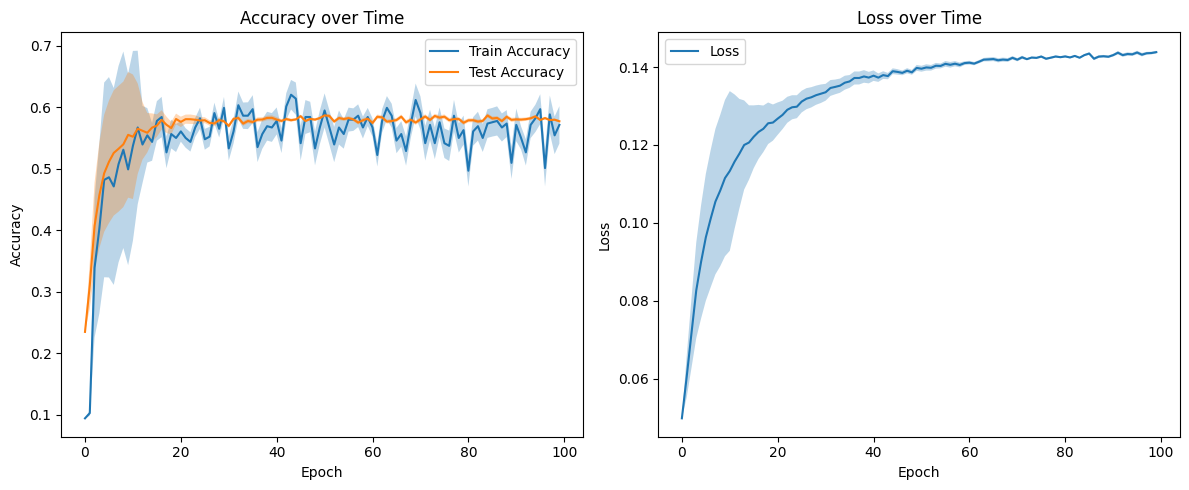

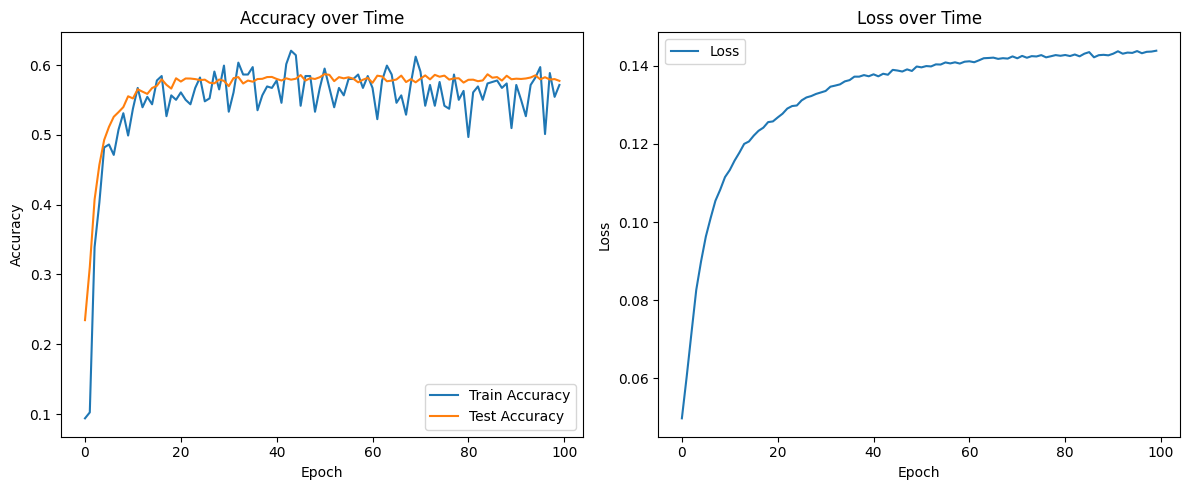

Final Train Accuracy: 0.57 ± 0.03
Final Test Accuracy: 0.58 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1730649946:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.06357803491196398
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1730649946:   1%|          | 1/100 [00:04<07:22,  4.47s/it]

 Test accuracy:  0.11

correct: 48 total: 469
loss: 0.08679637749756831
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730649946:   2%|▏         | 2/100 [00:09<07:28,  4.58s/it]

 Test accuracy:  0.1261

correct: 66 total: 469
loss: 0.0909185223360814
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1730649946:   3%|▎         | 3/100 [00:13<07:34,  4.69s/it]

 Test accuracy:  0.1359

correct: 59 total: 469
loss: 0.09518721010257948
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730649946:   4%|▍         | 4/100 [00:18<07:41,  4.81s/it]

 Test accuracy:  0.1395

correct: 71 total: 469
loss: 0.09855690798652705
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1730649946:   5%|▌         | 5/100 [00:24<07:54,  5.00s/it]

 Test accuracy:  0.1449

correct: 56 total: 469
loss: 0.09897918767258049
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730649946:   6%|▌         | 6/100 [00:29<07:56,  5.07s/it]

 Test accuracy:  0.1595

correct: 67 total: 469
loss: 0.10087539133296083
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1730649946:   7%|▋         | 7/100 [00:34<07:57,  5.13s/it]

 Test accuracy:  0.1523

correct: 72 total: 469
loss: 0.10112003505484128
 Train accuracy:  0.1535181236673774 | 


MLP_MNIST_0_1730649946:   8%|▊         | 8/100 [00:39<07:52,  5.14s/it]

 Test accuracy:  0.1481

correct: 53 total: 469
loss: 0.10081895844323803
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730649946:   9%|▉         | 9/100 [00:45<07:50,  5.17s/it]

 Test accuracy:  0.1686

correct: 65 total: 469
loss: 0.10089782512645477
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1730649946:  10%|█         | 10/100 [00:50<07:46,  5.19s/it]

 Test accuracy:  0.1592

correct: 61 total: 469
loss: 0.10215552908970095
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1730649946:  11%|█         | 11/100 [00:55<07:45,  5.23s/it]

 Test accuracy:  0.1559

correct: 71 total: 469
loss: 0.10278033249096068
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1730649946:  12%|█▏        | 12/100 [01:00<07:41,  5.25s/it]

 Test accuracy:  0.155

correct: 68 total: 469
loss: 0.10340232711865195
 Train accuracy:  0.14498933901918976 | 


MLP_MNIST_0_1730649946:  13%|█▎        | 13/100 [01:06<07:40,  5.29s/it]

 Test accuracy:  0.1567

correct: 60 total: 469
loss: 0.10267536683695148
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730649946:  14%|█▍        | 14/100 [01:11<07:36,  5.30s/it]

 Test accuracy:  0.1633

correct: 62 total: 469
loss: 0.1033715971274925
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730649946:  15%|█▌        | 15/100 [01:17<07:34,  5.35s/it]

 Test accuracy:  0.1619

correct: 60 total: 469
loss: 0.1028998895748846
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730649946:  16%|█▌        | 16/100 [01:22<07:33,  5.40s/it]

 Test accuracy:  0.1702

correct: 77 total: 469
loss: 0.10331359084671748
 Train accuracy:  0.16417910447761194 | 


MLP_MNIST_0_1730649946:  17%|█▋        | 17/100 [01:28<07:32,  5.45s/it]

 Test accuracy:  0.1725

correct: 71 total: 469
loss: 0.10439614902363657
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1730649946:  18%|█▊        | 18/100 [01:33<07:26,  5.44s/it]

 Test accuracy:  0.1724

correct: 66 total: 469
loss: 0.10541869982727554
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1730649946:  19%|█▉        | 19/100 [01:39<07:20,  5.44s/it]

 Test accuracy:  0.1655

correct: 66 total: 469
loss: 0.10493657512387741
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1730649946:  20%|██        | 20/100 [01:44<07:12,  5.41s/it]

 Test accuracy:  0.1685

correct: 70 total: 469
loss: 0.10450219172340974
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1730649946:  21%|██        | 21/100 [01:49<07:07,  5.42s/it]

 Test accuracy:  0.1713

correct: 58 total: 469
loss: 0.10463553282624877
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730649946:  22%|██▏       | 22/100 [01:55<07:05,  5.46s/it]

 Test accuracy:  0.1731

correct: 63 total: 469
loss: 0.10518364261970846
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730649946:  23%|██▎       | 23/100 [02:01<07:10,  5.59s/it]

 Test accuracy:  0.1721

correct: 67 total: 469
loss: 0.10564523568349098
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1730649946:  24%|██▍       | 24/100 [02:06<07:02,  5.56s/it]

 Test accuracy:  0.1766

correct: 69 total: 469
loss: 0.10490987438764145
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1730649946:  25%|██▌       | 25/100 [02:12<06:55,  5.54s/it]

 Test accuracy:  0.1734

correct: 68 total: 469
loss: 0.10577445216715209
 Train accuracy:  0.14498933901918976 | 


MLP_MNIST_0_1730649946:  26%|██▌       | 26/100 [02:17<06:48,  5.52s/it]

 Test accuracy:  0.1718

correct: 73 total: 469
loss: 0.10543803897684317
 Train accuracy:  0.15565031982942432 | 


MLP_MNIST_0_1730649946:  27%|██▋       | 27/100 [02:23<06:41,  5.51s/it]

 Test accuracy:  0.175

correct: 60 total: 469
loss: 0.10583418258217606
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730649946:  28%|██▊       | 28/100 [02:28<06:35,  5.50s/it]

 Test accuracy:  0.174

correct: 58 total: 469
loss: 0.10554741070405252
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730649946:  29%|██▉       | 29/100 [02:34<06:32,  5.53s/it]

 Test accuracy:  0.1717

correct: 59 total: 469
loss: 0.10571451923613355
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730649946:  30%|███       | 30/100 [02:39<06:25,  5.50s/it]

 Test accuracy:  0.1741

correct: 66 total: 469
loss: 0.10593045488603588
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1730649946:  31%|███       | 31/100 [02:45<06:19,  5.50s/it]

 Test accuracy:  0.1724

correct: 74 total: 469
loss: 0.10549147315879366
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1730649946:  32%|███▏      | 32/100 [02:50<06:11,  5.46s/it]

 Test accuracy:  0.1679

correct: 71 total: 469
loss: 0.10600197798153485
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1730649946:  33%|███▎      | 33/100 [02:56<06:07,  5.48s/it]

 Test accuracy:  0.1743

correct: 70 total: 469
loss: 0.10668044526185562
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1730649946:  34%|███▍      | 34/100 [03:01<06:04,  5.52s/it]

 Test accuracy:  0.171

correct: 67 total: 469
loss: 0.10623684080679026
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1730649946:  35%|███▌      | 35/100 [03:07<05:57,  5.50s/it]

 Test accuracy:  0.1735

correct: 56 total: 469
loss: 0.10673468961898706
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730649946:  36%|███▌      | 36/100 [03:12<05:52,  5.50s/it]

 Test accuracy:  0.1734

correct: 61 total: 469
loss: 0.10580250597012832
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1730649946:  37%|███▋      | 37/100 [03:18<05:49,  5.54s/it]

 Test accuracy:  0.1733

correct: 69 total: 469
loss: 0.1066024777477484
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1730649946:  38%|███▊      | 38/100 [03:24<05:46,  5.59s/it]

 Test accuracy:  0.1736

correct: 59 total: 469
loss: 0.10655938853015269
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730649946:  39%|███▉      | 39/100 [03:29<05:38,  5.56s/it]

 Test accuracy:  0.1716

correct: 54 total: 469
loss: 0.10608108579985369
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1730649946:  40%|████      | 40/100 [03:35<05:36,  5.61s/it]

 Test accuracy:  0.1718

correct: 48 total: 469
loss: 0.10733506664919701
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730649946:  41%|████      | 41/100 [03:40<05:30,  5.60s/it]

 Test accuracy:  0.1733

correct: 63 total: 469
loss: 0.10518507627663073
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730649946:  42%|████▏     | 42/100 [03:46<05:23,  5.58s/it]

 Test accuracy:  0.1737

correct: 60 total: 469
loss: 0.10611961159243513
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730649946:  43%|████▎     | 43/100 [03:52<05:19,  5.61s/it]

 Test accuracy:  0.1747

correct: 63 total: 469
loss: 0.10529520103672166
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730649946:  44%|████▍     | 44/100 [03:57<05:13,  5.60s/it]

 Test accuracy:  0.174

correct: 67 total: 469
loss: 0.10612724916830754
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1730649946:  45%|████▌     | 45/100 [04:03<05:08,  5.61s/it]

 Test accuracy:  0.1768

correct: 77 total: 469
loss: 0.10726749377527725
 Train accuracy:  0.16417910447761194 | 


MLP_MNIST_0_1730649946:  46%|████▌     | 46/100 [04:08<05:03,  5.62s/it]

 Test accuracy:  0.1731

correct: 63 total: 469
loss: 0.1069596397883094
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730649946:  47%|████▋     | 47/100 [04:14<04:58,  5.63s/it]

 Test accuracy:  0.1782

correct: 56 total: 469
loss: 0.10678576106138067
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730649946:  48%|████▊     | 48/100 [04:20<04:57,  5.73s/it]

 Test accuracy:  0.1722

correct: 54 total: 469
loss: 0.10591439373775331
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1730649946:  49%|████▉     | 49/100 [04:26<04:52,  5.74s/it]

 Test accuracy:  0.1781

correct: 59 total: 469
loss: 0.10682279807227507
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730649946:  50%|█████     | 50/100 [04:31<04:43,  5.68s/it]

 Test accuracy:  0.1728

correct: 52 total: 469
loss: 0.10665954153802094
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730649946:  51%|█████     | 51/100 [04:37<04:38,  5.69s/it]

 Test accuracy:  0.1726

correct: 54 total: 469
loss: 0.10597929302881014
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1730649946:  52%|█████▏    | 52/100 [04:43<04:30,  5.64s/it]

 Test accuracy:  0.1715

correct: 50 total: 469
loss: 0.1056270288633131
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1730649946:  53%|█████▎    | 53/100 [04:48<04:23,  5.61s/it]

 Test accuracy:  0.1733

correct: 56 total: 469
loss: 0.10586935326234619
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730649946:  54%|█████▍    | 54/100 [04:54<04:20,  5.66s/it]

 Test accuracy:  0.1756

correct: 67 total: 469
loss: 0.1055618023186096
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1730649946:  55%|█████▌    | 55/100 [04:59<04:13,  5.64s/it]

 Test accuracy:  0.1714

correct: 55 total: 469
loss: 0.1048416276571593
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730649946:  56%|█████▌    | 56/100 [05:05<04:07,  5.62s/it]

 Test accuracy:  0.1725

correct: 50 total: 469
loss: 0.10535826163886707
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1730649946:  57%|█████▋    | 57/100 [05:11<04:09,  5.81s/it]

 Test accuracy:  0.1737

correct: 66 total: 469
loss: 0.10514303632001125
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1730649946:  58%|█████▊    | 58/100 [05:17<04:03,  5.79s/it]

 Test accuracy:  0.1744

correct: 46 total: 469
loss: 0.1041639527595882
 Train accuracy:  0.09808102345415778 | 


MLP_MNIST_0_1730649946:  59%|█████▉    | 59/100 [05:23<03:55,  5.74s/it]

 Test accuracy:  0.1762

correct: 53 total: 469
loss: 0.10576632757113179
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730649946:  60%|██████    | 60/100 [05:28<03:48,  5.70s/it]

 Test accuracy:  0.1744

correct: 60 total: 469
loss: 0.10485444853364277
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730649946:  61%|██████    | 61/100 [05:34<03:42,  5.72s/it]

 Test accuracy:  0.176

correct: 52 total: 469
loss: 0.10533519008202848
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730649946:  62%|██████▏   | 62/100 [05:40<03:38,  5.74s/it]

 Test accuracy:  0.1751

correct: 53 total: 469
loss: 0.10501064101198335
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730649946:  63%|██████▎   | 63/100 [05:45<03:31,  5.72s/it]

 Test accuracy:  0.1739

correct: 70 total: 469
loss: 0.1048573758810568
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1730649946:  64%|██████▍   | 64/100 [05:51<03:25,  5.72s/it]

 Test accuracy:  0.1786

correct: 64 total: 469
loss: 0.10444728518599894
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730649946:  65%|██████▌   | 65/100 [05:57<03:20,  5.74s/it]

 Test accuracy:  0.1736

correct: 64 total: 469
loss: 0.10546485558628782
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730649946:  66%|██████▌   | 66/100 [06:03<03:13,  5.70s/it]

 Test accuracy:  0.1697

correct: 69 total: 469
loss: 0.10444678067525567
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1730649946:  67%|██████▋   | 67/100 [06:08<03:08,  5.72s/it]

 Test accuracy:  0.1726

correct: 62 total: 469
loss: 0.10597198593146256
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730649946:  68%|██████▊   | 68/100 [06:14<03:04,  5.77s/it]

 Test accuracy:  0.1777

correct: 63 total: 469
loss: 0.10463407308435135
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730649946:  69%|██████▉   | 69/100 [06:20<02:59,  5.78s/it]

 Test accuracy:  0.174

correct: 55 total: 469
loss: 0.10513811512415343
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730649946:  70%|███████   | 70/100 [06:26<02:54,  5.81s/it]

 Test accuracy:  0.1776

correct: 60 total: 469
loss: 0.10494452710154215
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730649946:  71%|███████   | 71/100 [06:32<02:47,  5.78s/it]

 Test accuracy:  0.1685

correct: 56 total: 469
loss: 0.10493525390876636
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730649946:  72%|███████▏  | 72/100 [06:37<02:41,  5.76s/it]

 Test accuracy:  0.1754

correct: 53 total: 469
loss: 0.104674039078928
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730649946:  73%|███████▎  | 73/100 [06:43<02:36,  5.81s/it]

 Test accuracy:  0.1758

correct: 62 total: 469
loss: 0.10529233620110859
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730649946:  74%|███████▍  | 74/100 [06:49<02:30,  5.80s/it]

 Test accuracy:  0.1724

correct: 56 total: 469
loss: 0.10443501994172648
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730649946:  75%|███████▌  | 75/100 [06:55<02:25,  5.83s/it]

 Test accuracy:  0.1731

correct: 63 total: 469
loss: 0.10491921770165978
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730649946:  76%|███████▌  | 76/100 [07:01<02:19,  5.83s/it]

 Test accuracy:  0.1746

correct: 62 total: 469
loss: 0.1038804543869836
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730649946:  77%|███████▋  | 77/100 [07:07<02:13,  5.82s/it]

 Test accuracy:  0.1761

correct: 58 total: 469
loss: 0.10581280524606135
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730649946:  78%|███████▊  | 78/100 [07:12<02:07,  5.78s/it]

 Test accuracy:  0.1733

correct: 68 total: 469
loss: 0.10550396163453425
 Train accuracy:  0.14498933901918976 | 


MLP_MNIST_0_1730649946:  79%|███████▉  | 79/100 [07:18<02:03,  5.86s/it]

 Test accuracy:  0.1706

correct: 51 total: 469
loss: 0.10509853276299007
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1730649946:  80%|████████  | 80/100 [07:24<01:56,  5.85s/it]

 Test accuracy:  0.1728

correct: 59 total: 469
loss: 0.10518321081964192
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730649946:  81%|████████  | 81/100 [07:30<01:50,  5.82s/it]

 Test accuracy:  0.1733

correct: 44 total: 469
loss: 0.10437117883963372
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1730649946:  82%|████████▏ | 82/100 [07:36<01:45,  5.84s/it]

 Test accuracy:  0.167

correct: 44 total: 469
loss: 0.10625539119563886
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1730649946:  83%|████████▎ | 83/100 [07:42<01:39,  5.83s/it]

 Test accuracy:  0.1754

correct: 57 total: 469
loss: 0.10449223409392941
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1730649946:  84%|████████▍ | 84/100 [07:48<01:33,  5.85s/it]

 Test accuracy:  0.1792

correct: 58 total: 469
loss: 0.10457453581252332
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730649946:  85%|████████▌ | 85/100 [07:53<01:28,  5.89s/it]

 Test accuracy:  0.1717

correct: 49 total: 469
loss: 0.10461864637921868
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1730649946:  86%|████████▌ | 86/100 [07:59<01:22,  5.86s/it]

 Test accuracy:  0.1734

correct: 59 total: 469
loss: 0.10484336608889769
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730649946:  87%|████████▋ | 87/100 [08:05<01:16,  5.87s/it]

 Test accuracy:  0.1727

correct: 65 total: 469
loss: 0.10502609075196008
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1730649946:  88%|████████▊ | 88/100 [08:11<01:10,  5.88s/it]

 Test accuracy:  0.1742

correct: 61 total: 469
loss: 0.10491584867302543
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1730649946:  89%|████████▉ | 89/100 [08:17<01:05,  5.95s/it]

 Test accuracy:  0.173

correct: 53 total: 469
loss: 0.10457899761416002
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730649946:  90%|█████████ | 90/100 [08:23<00:59,  5.98s/it]

 Test accuracy:  0.1737

correct: 52 total: 469
loss: 0.10487518488153466
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730649946:  91%|█████████ | 91/100 [08:29<00:53,  5.96s/it]

 Test accuracy:  0.1705

correct: 51 total: 469
loss: 0.1039779488720111
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1730649946:  92%|█████████▏| 92/100 [08:35<00:47,  5.96s/it]

 Test accuracy:  0.1698

correct: 49 total: 469
loss: 0.10418844175364163
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1730649946:  93%|█████████▎| 93/100 [08:41<00:41,  5.94s/it]

 Test accuracy:  0.1772

correct: 58 total: 469
loss: 0.10457388321156187
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730649946:  94%|█████████▍| 94/100 [08:47<00:35,  5.94s/it]

 Test accuracy:  0.1729

correct: 58 total: 469
loss: 0.10408778765054146
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730649946:  95%|█████████▌| 95/100 [08:53<00:30,  6.02s/it]

 Test accuracy:  0.1747

correct: 50 total: 469
loss: 0.1034438271861849
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1730649946:  96%|█████████▌| 96/100 [08:59<00:23,  5.97s/it]

 Test accuracy:  0.1771

correct: 61 total: 469
loss: 0.10364487511453344
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1730649946:  97%|█████████▋| 97/100 [09:05<00:17,  5.95s/it]

 Test accuracy:  0.174

correct: 59 total: 469
loss: 0.10348778108416844
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730649946:  98%|█████████▊| 98/100 [09:11<00:12,  6.06s/it]

 Test accuracy:  0.1742

correct: 50 total: 469
loss: 0.10275365490077147
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1730649946:  99%|█████████▉| 99/100 [09:17<00:06,  6.01s/it]

 Test accuracy:  0.1708

correct: 69 total: 469
loss: 0.10471808166900423
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1730649946: 100%|██████████| 100/100 [09:23<00:00,  5.64s/it]

 Test accuracy:  0.1752


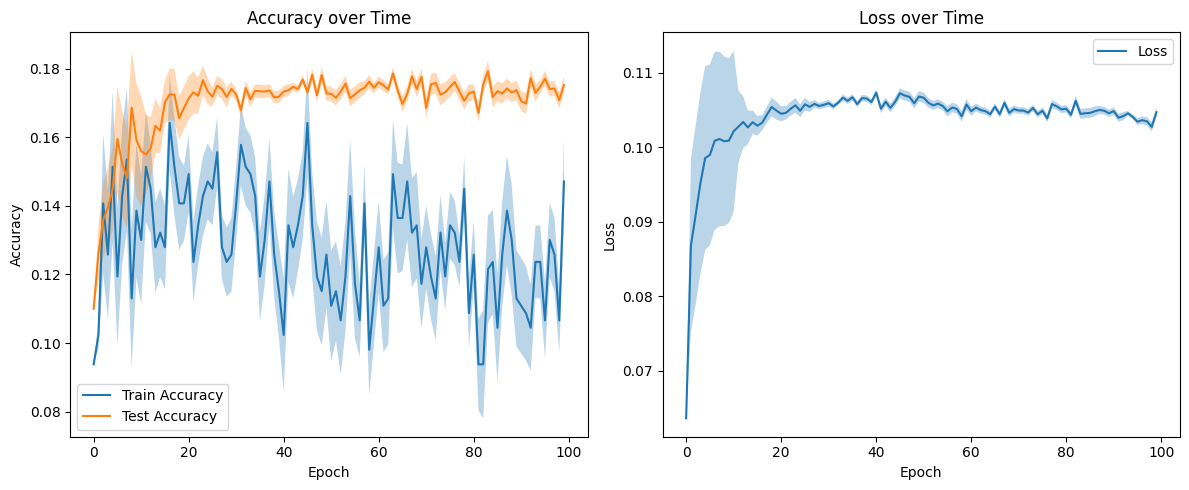

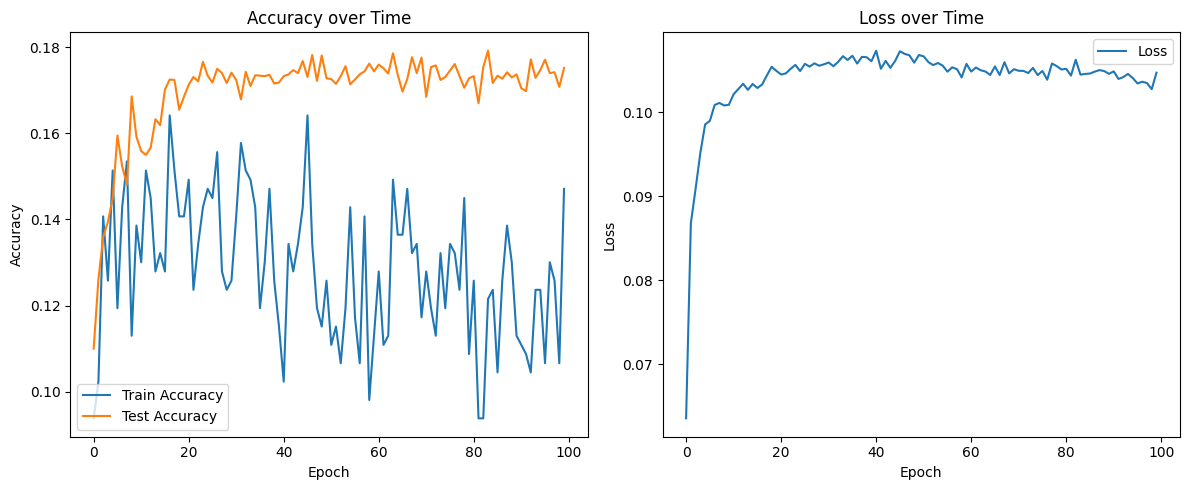

Final Train Accuracy: 0.15 ± 0.01
Final Test Accuracy: 0.18 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1730650514:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.04744358192374711
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1730650514:   1%|          | 1/100 [00:04<07:13,  4.38s/it]

 Test accuracy:  0.1188

correct: 48 total: 469
loss: 0.059699199132637173
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730650514:   2%|▏         | 2/100 [00:09<07:31,  4.60s/it]

 Test accuracy:  0.1259

correct: 59 total: 469
loss: 0.06683204557373325
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730650514:   3%|▎         | 3/100 [00:13<07:31,  4.65s/it]

 Test accuracy:  0.1472

correct: 65 total: 469
loss: 0.07100118408356902
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1730650514:   4%|▍         | 4/100 [00:18<07:34,  4.73s/it]

 Test accuracy:  0.1575

correct: 84 total: 469
loss: 0.07502265975895975
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1730650514:   5%|▌         | 5/100 [00:23<07:30,  4.75s/it]

 Test accuracy:  0.1612

correct: 82 total: 469
loss: 0.07906051323230841
 Train accuracy:  0.17484008528784648 | 


MLP_MNIST_0_1730650514:   6%|▌         | 6/100 [00:28<07:34,  4.84s/it]

 Test accuracy:  0.1699

correct: 76 total: 469
loss: 0.08223577384660238
 Train accuracy:  0.16204690831556504 | 


MLP_MNIST_0_1730650514:   7%|▋         | 7/100 [00:33<07:30,  4.84s/it]

 Test accuracy:  0.1765

correct: 86 total: 469
loss: 0.08516326657871702
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1730650514:   8%|▊         | 8/100 [00:38<07:26,  4.85s/it]

 Test accuracy:  0.1837

correct: 79 total: 469
loss: 0.08702538408704404
 Train accuracy:  0.16844349680170576 | 


MLP_MNIST_0_1730650514:   9%|▉         | 9/100 [00:42<07:19,  4.83s/it]

 Test accuracy:  0.1825

correct: 86 total: 469
loss: 0.08979897010428056
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1730650514:  10%|█         | 10/100 [00:47<07:15,  4.84s/it]

 Test accuracy:  0.1787

correct: 94 total: 469
loss: 0.09159266859737795
 Train accuracy:  0.20042643923240938 | 


MLP_MNIST_0_1730650514:  11%|█         | 11/100 [00:52<07:11,  4.85s/it]

 Test accuracy:  0.1893

correct: 77 total: 469
loss: 0.09429421315569358
 Train accuracy:  0.16417910447761194 | 


MLP_MNIST_0_1730650514:  12%|█▏        | 12/100 [00:57<07:11,  4.90s/it]

 Test accuracy:  0.193

correct: 87 total: 469
loss: 0.09601162002284898
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1730650514:  13%|█▎        | 13/100 [01:02<07:03,  4.87s/it]

 Test accuracy:  0.2003

correct: 109 total: 469
loss: 0.0970639550228363
 Train accuracy:  0.232409381663113 | 


MLP_MNIST_0_1730650514:  14%|█▍        | 14/100 [01:07<06:59,  4.88s/it]

 Test accuracy:  0.2002

correct: 84 total: 469
loss: 0.09829746731626454
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1730650514:  15%|█▌        | 15/100 [01:12<06:53,  4.87s/it]

 Test accuracy:  0.2012

correct: 101 total: 469
loss: 0.09988835630322825
 Train accuracy:  0.21535181236673773 | 


MLP_MNIST_0_1730650514:  16%|█▌        | 16/100 [01:17<06:50,  4.88s/it]

 Test accuracy:  0.206

correct: 114 total: 469
loss: 0.10152764138636558
 Train accuracy:  0.24307036247334754 | 


MLP_MNIST_0_1730650514:  17%|█▋        | 17/100 [01:22<06:44,  4.87s/it]

 Test accuracy:  0.2047

correct: 79 total: 469
loss: 0.10284039459185305
 Train accuracy:  0.16844349680170576 | 


MLP_MNIST_0_1730650514:  18%|█▊        | 18/100 [01:27<06:43,  4.92s/it]

 Test accuracy:  0.2121

correct: 89 total: 469
loss: 0.10400370913527922
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1730650514:  19%|█▉        | 19/100 [01:32<06:40,  4.94s/it]

 Test accuracy:  0.2007

correct: 96 total: 469
loss: 0.10483512001187563
 Train accuracy:  0.2046908315565032 | 


MLP_MNIST_0_1730650514:  20%|██        | 20/100 [01:37<06:35,  4.94s/it]

 Test accuracy:  0.2074

correct: 101 total: 469
loss: 0.10647698939799755
 Train accuracy:  0.21535181236673773 | 


MLP_MNIST_0_1730650514:  21%|██        | 21/100 [01:41<06:28,  4.92s/it]

 Test accuracy:  0.2047

correct: 98 total: 469
loss: 0.10637368004459308
 Train accuracy:  0.208955223880597 | 


MLP_MNIST_0_1730650514:  22%|██▏       | 22/100 [01:46<06:23,  4.92s/it]

 Test accuracy:  0.1964

correct: 95 total: 469
loss: 0.10767502329751119
 Train accuracy:  0.2025586353944563 | 


MLP_MNIST_0_1730650514:  23%|██▎       | 23/100 [01:51<06:20,  4.94s/it]

 Test accuracy:  0.2086

correct: 99 total: 469
loss: 0.10911735347402629
 Train accuracy:  0.21108742004264391 | 


MLP_MNIST_0_1730650514:  24%|██▍       | 24/100 [01:56<06:15,  4.95s/it]

 Test accuracy:  0.207

correct: 83 total: 469
loss: 0.10935669454303124
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1730650514:  25%|██▌       | 25/100 [02:01<06:11,  4.95s/it]

 Test accuracy:  0.2149

correct: 99 total: 469
loss: 0.10992149269974816
 Train accuracy:  0.21108742004264391 | 


MLP_MNIST_0_1730650514:  26%|██▌       | 26/100 [02:06<06:06,  4.95s/it]

 Test accuracy:  0.2083

correct: 99 total: 469
loss: 0.11078633221863175
 Train accuracy:  0.21108742004264391 | 


MLP_MNIST_0_1730650514:  27%|██▋       | 27/100 [02:11<06:00,  4.93s/it]

 Test accuracy:  0.2068

correct: 95 total: 469
loss: 0.11084372087963608
 Train accuracy:  0.2025586353944563 | 


MLP_MNIST_0_1730650514:  28%|██▊       | 28/100 [02:16<05:57,  4.96s/it]

 Test accuracy:  0.206

correct: 108 total: 469
loss: 0.11163294008736417
 Train accuracy:  0.2302771855010661 | 


MLP_MNIST_0_1730650514:  29%|██▉       | 29/100 [02:21<05:50,  4.94s/it]

 Test accuracy:  0.2051

correct: 102 total: 469
loss: 0.11277271240060009
 Train accuracy:  0.21748400852878466 | 


MLP_MNIST_0_1730650514:  30%|███       | 30/100 [02:26<05:46,  4.95s/it]

 Test accuracy:  0.2085

correct: 105 total: 469
loss: 0.11275793078230388
 Train accuracy:  0.22388059701492538 | 


MLP_MNIST_0_1730650514:  31%|███       | 31/100 [02:31<05:43,  4.98s/it]

 Test accuracy:  0.2111

correct: 113 total: 469
loss: 0.11393924403800638
 Train accuracy:  0.24093816631130063 | 


MLP_MNIST_0_1730650514:  32%|███▏      | 32/100 [02:36<05:39,  5.00s/it]

 Test accuracy:  0.2055

correct: 106 total: 469
loss: 0.11379840695209849
 Train accuracy:  0.2260127931769723 | 


MLP_MNIST_0_1730650514:  33%|███▎      | 33/100 [02:41<05:36,  5.02s/it]

 Test accuracy:  0.2117

correct: 91 total: 469
loss: 0.11403148152680793
 Train accuracy:  0.19402985074626866 | 


MLP_MNIST_0_1730650514:  34%|███▍      | 34/100 [02:46<05:33,  5.05s/it]

 Test accuracy:  0.2155

correct: 92 total: 469
loss: 0.11557182690291516
 Train accuracy:  0.19616204690831557 | 


MLP_MNIST_0_1730650514:  35%|███▌      | 35/100 [02:51<05:30,  5.08s/it]

 Test accuracy:  0.2148

correct: 113 total: 469
loss: 0.11487405079959044
 Train accuracy:  0.24093816631130063 | 


MLP_MNIST_0_1730650514:  36%|███▌      | 36/100 [02:57<05:26,  5.11s/it]

 Test accuracy:  0.2067

correct: 89 total: 469
loss: 0.11586836499890793
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1730650514:  37%|███▋      | 37/100 [03:02<05:21,  5.10s/it]

 Test accuracy:  0.2157

correct: 89 total: 469
loss: 0.11553169848885872
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1730650514:  38%|███▊      | 38/100 [03:07<05:15,  5.08s/it]

 Test accuracy:  0.2102

correct: 103 total: 469
loss: 0.11615651552039169
 Train accuracy:  0.21961620469083157 | 


MLP_MNIST_0_1730650514:  39%|███▉      | 39/100 [03:12<05:09,  5.07s/it]

 Test accuracy:  0.2103

correct: 87 total: 469
loss: 0.11628476171287647
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1730650514:  40%|████      | 40/100 [03:17<05:04,  5.07s/it]

 Test accuracy:  0.2067

correct: 91 total: 469
loss: 0.11601714931253686
 Train accuracy:  0.19402985074626866 | 


MLP_MNIST_0_1730650514:  41%|████      | 41/100 [03:22<04:58,  5.07s/it]

 Test accuracy:  0.2135

correct: 117 total: 469
loss: 0.11689246715957931
 Train accuracy:  0.24946695095948826 | 


MLP_MNIST_0_1730650514:  42%|████▏     | 42/100 [03:27<04:54,  5.08s/it]

 Test accuracy:  0.2077

correct: 82 total: 469
loss: 0.11748767215242265
 Train accuracy:  0.17484008528784648 | 


MLP_MNIST_0_1730650514:  43%|████▎     | 43/100 [03:32<04:50,  5.10s/it]

 Test accuracy:  0.2096

correct: 117 total: 469
loss: 0.11662749623629584
 Train accuracy:  0.24946695095948826 | 


MLP_MNIST_0_1730650514:  44%|████▍     | 44/100 [03:38<04:51,  5.21s/it]

 Test accuracy:  0.209

correct: 96 total: 469
loss: 0.11746120821438365
 Train accuracy:  0.2046908315565032 | 


MLP_MNIST_0_1730650514:  45%|████▌     | 45/100 [03:43<04:43,  5.15s/it]

 Test accuracy:  0.2076

correct: 110 total: 469
loss: 0.11768094593210261
 Train accuracy:  0.2345415778251599 | 


MLP_MNIST_0_1730650514:  46%|████▌     | 46/100 [03:48<04:36,  5.13s/it]

 Test accuracy:  0.2022

correct: 87 total: 469
loss: 0.11804531721163915
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1730650514:  47%|████▋     | 47/100 [03:53<04:31,  5.12s/it]

 Test accuracy:  0.2028

correct: 103 total: 469
loss: 0.11844015936416857
 Train accuracy:  0.21961620469083157 | 


MLP_MNIST_0_1730650514:  48%|████▊     | 48/100 [03:58<04:32,  5.24s/it]

 Test accuracy:  0.2057

correct: 89 total: 469
loss: 0.11971048702563304
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1730650514:  49%|████▉     | 49/100 [04:03<04:24,  5.19s/it]

 Test accuracy:  0.2062

correct: 104 total: 469
loss: 0.1189227835583026
 Train accuracy:  0.22174840085287847 | 


MLP_MNIST_0_1730650514:  50%|█████     | 50/100 [04:09<04:21,  5.22s/it]

 Test accuracy:  0.2101

correct: 100 total: 469
loss: 0.11912212854445871
 Train accuracy:  0.21321961620469082 | 


MLP_MNIST_0_1730650514:  51%|█████     | 51/100 [04:14<04:15,  5.21s/it]

 Test accuracy:  0.2055

correct: 94 total: 469
loss: 0.11941749238764554
 Train accuracy:  0.20042643923240938 | 


MLP_MNIST_0_1730650514:  52%|█████▏    | 52/100 [04:19<04:08,  5.18s/it]

 Test accuracy:  0.2065

correct: 97 total: 469
loss: 0.11900019636159258
 Train accuracy:  0.2068230277185501 | 


MLP_MNIST_0_1730650514:  53%|█████▎    | 53/100 [04:24<04:02,  5.16s/it]

 Test accuracy:  0.2027

correct: 92 total: 469
loss: 0.11880123415100041
 Train accuracy:  0.19616204690831557 | 


MLP_MNIST_0_1730650514:  54%|█████▍    | 54/100 [04:29<03:58,  5.19s/it]

 Test accuracy:  0.2117

correct: 97 total: 469
loss: 0.11900839843411944
 Train accuracy:  0.2068230277185501 | 


MLP_MNIST_0_1730650514:  55%|█████▌    | 55/100 [04:34<03:53,  5.18s/it]

 Test accuracy:  0.1978

correct: 102 total: 469
loss: 0.11846297804607765
 Train accuracy:  0.21748400852878466 | 


MLP_MNIST_0_1730650514:  56%|█████▌    | 56/100 [04:40<03:49,  5.23s/it]

 Test accuracy:  0.2062

correct: 90 total: 469
loss: 0.1186379991741831
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1730650514:  57%|█████▋    | 57/100 [04:45<03:43,  5.20s/it]

 Test accuracy:  0.2026

correct: 90 total: 469
loss: 0.11944578611838029
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1730650514:  58%|█████▊    | 58/100 [04:50<03:40,  5.25s/it]

 Test accuracy:  0.2059

correct: 90 total: 469
loss: 0.11941471583108658
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1730650514:  59%|█████▉    | 59/100 [04:55<03:34,  5.23s/it]

 Test accuracy:  0.2163

correct: 99 total: 469
loss: 0.11959134630048707
 Train accuracy:  0.21108742004264391 | 


MLP_MNIST_0_1730650514:  60%|██████    | 60/100 [05:01<03:27,  5.19s/it]

 Test accuracy:  0.2039

correct: 84 total: 469
loss: 0.11997018079323046
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1730650514:  61%|██████    | 61/100 [05:06<03:22,  5.19s/it]

 Test accuracy:  0.2079

correct: 101 total: 469
loss: 0.11979968726698524
 Train accuracy:  0.21535181236673773 | 


MLP_MNIST_0_1730650514:  62%|██████▏   | 62/100 [05:11<03:18,  5.22s/it]

 Test accuracy:  0.2124

correct: 83 total: 469
loss: 0.1205180410796137
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1730650514:  63%|██████▎   | 63/100 [05:16<03:12,  5.20s/it]

 Test accuracy:  0.2147

correct: 106 total: 469
loss: 0.11958331465403409
 Train accuracy:  0.2260127931769723 | 


MLP_MNIST_0_1730650514:  64%|██████▍   | 64/100 [05:21<03:07,  5.21s/it]

 Test accuracy:  0.2132

correct: 95 total: 469
loss: 0.1205015039361362
 Train accuracy:  0.2025586353944563 | 


MLP_MNIST_0_1730650514:  65%|██████▌   | 65/100 [05:27<03:02,  5.22s/it]

 Test accuracy:  0.2114

correct: 92 total: 469
loss: 0.11993273272951528
 Train accuracy:  0.19616204690831557 | 


MLP_MNIST_0_1730650514:  66%|██████▌   | 66/100 [05:32<02:57,  5.22s/it]

 Test accuracy:  0.2052

correct: 96 total: 469
loss: 0.1201531156929317
 Train accuracy:  0.2046908315565032 | 


MLP_MNIST_0_1730650514:  67%|██████▋   | 67/100 [05:37<02:52,  5.23s/it]

 Test accuracy:  0.2068

correct: 98 total: 469
loss: 0.12024302737735736
 Train accuracy:  0.208955223880597 | 


MLP_MNIST_0_1730650514:  68%|██████▊   | 68/100 [05:43<02:48,  5.28s/it]

 Test accuracy:  0.2073

correct: 93 total: 469
loss: 0.12038994934767294
 Train accuracy:  0.19829424307036247 | 


MLP_MNIST_0_1730650514:  69%|██████▉   | 69/100 [05:48<02:44,  5.30s/it]

 Test accuracy:  0.209

correct: 111 total: 469
loss: 0.12068850381859839
 Train accuracy:  0.23667377398720682 | 


MLP_MNIST_0_1730650514:  70%|███████   | 70/100 [05:53<02:41,  5.38s/it]

 Test accuracy:  0.2143

correct: 79 total: 469
loss: 0.12063832077453894
 Train accuracy:  0.16844349680170576 | 


MLP_MNIST_0_1730650514:  71%|███████   | 71/100 [05:59<02:37,  5.42s/it]

 Test accuracy:  0.2121

correct: 101 total: 469
loss: 0.12036722887363006
 Train accuracy:  0.21535181236673773 | 


MLP_MNIST_0_1730650514:  72%|███████▏  | 72/100 [06:04<02:30,  5.38s/it]

 Test accuracy:  0.2134

correct: 117 total: 469
loss: 0.12195456615770295
 Train accuracy:  0.24946695095948826 | 


MLP_MNIST_0_1730650514:  73%|███████▎  | 73/100 [06:10<02:25,  5.40s/it]

 Test accuracy:  0.2068

correct: 84 total: 469
loss: 0.12145830570126394
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1730650514:  74%|███████▍  | 74/100 [06:15<02:21,  5.43s/it]

 Test accuracy:  0.2113

correct: 99 total: 469
loss: 0.12176044224930216
 Train accuracy:  0.21108742004264391 | 


MLP_MNIST_0_1730650514:  75%|███████▌  | 75/100 [06:21<02:16,  5.45s/it]

 Test accuracy:  0.2102

correct: 113 total: 469
loss: 0.121674532956406
 Train accuracy:  0.24093816631130063 | 


MLP_MNIST_0_1730650514:  76%|███████▌  | 76/100 [06:26<02:11,  5.50s/it]

 Test accuracy:  0.2083

correct: 94 total: 469
loss: 0.12078062562482443
 Train accuracy:  0.20042643923240938 | 


MLP_MNIST_0_1730650514:  77%|███████▋  | 77/100 [06:32<02:05,  5.45s/it]

 Test accuracy:  0.2003

correct: 101 total: 469
loss: 0.12157178347680106
 Train accuracy:  0.21535181236673773 | 


MLP_MNIST_0_1730650514:  78%|███████▊  | 78/100 [06:37<02:00,  5.46s/it]

 Test accuracy:  0.2173

correct: 93 total: 469
loss: 0.12198462755059891
 Train accuracy:  0.19829424307036247 | 


MLP_MNIST_0_1730650514:  79%|███████▉  | 79/100 [06:42<01:53,  5.42s/it]

 Test accuracy:  0.2108

correct: 99 total: 469
loss: 0.12198143317374086
 Train accuracy:  0.21108742004264391 | 


MLP_MNIST_0_1730650514:  80%|████████  | 80/100 [06:48<01:49,  5.48s/it]

 Test accuracy:  0.2086

correct: 97 total: 469
loss: 0.12164945479458583
 Train accuracy:  0.2068230277185501 | 


MLP_MNIST_0_1730650514:  81%|████████  | 81/100 [06:54<01:45,  5.55s/it]

 Test accuracy:  0.2106

correct: 104 total: 469
loss: 0.1215473641750655
 Train accuracy:  0.22174840085287847 | 


MLP_MNIST_0_1730650514:  82%|████████▏ | 82/100 [06:59<01:39,  5.53s/it]

 Test accuracy:  0.2047

correct: 122 total: 469
loss: 0.12255837047087358
 Train accuracy:  0.2601279317697228 | 


MLP_MNIST_0_1730650514:  83%|████████▎ | 83/100 [07:05<01:33,  5.50s/it]

 Test accuracy:  0.212

correct: 106 total: 469
loss: 0.12162532981461299
 Train accuracy:  0.2260127931769723 | 


MLP_MNIST_0_1730650514:  84%|████████▍ | 84/100 [07:10<01:28,  5.53s/it]

 Test accuracy:  0.2076

correct: 87 total: 469
loss: 0.12206533621114962
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1730650514:  85%|████████▌ | 85/100 [07:16<01:23,  5.57s/it]

 Test accuracy:  0.2042

correct: 103 total: 469
loss: 0.12274010859128
 Train accuracy:  0.21961620469083157 | 


MLP_MNIST_0_1730650514:  86%|████████▌ | 86/100 [07:22<01:17,  5.57s/it]

 Test accuracy:  0.2052

correct: 103 total: 469
loss: 0.12309875853979257
 Train accuracy:  0.21961620469083157 | 


MLP_MNIST_0_1730650514:  87%|████████▋ | 87/100 [07:27<01:13,  5.64s/it]

 Test accuracy:  0.2077

correct: 107 total: 469
loss: 0.1213571295173946
 Train accuracy:  0.2281449893390192 | 


MLP_MNIST_0_1730650514:  88%|████████▊ | 88/100 [07:34<01:09,  5.81s/it]

 Test accuracy:  0.2037

correct: 93 total: 469
loss: 0.12184567576341791
 Train accuracy:  0.19829424307036247 | 


MLP_MNIST_0_1730650514:  89%|████████▉ | 89/100 [07:39<01:04,  5.82s/it]

 Test accuracy:  0.2094

correct: 95 total: 469
loss: 0.12249162507209696
 Train accuracy:  0.2025586353944563 | 


MLP_MNIST_0_1730650514:  90%|█████████ | 90/100 [07:45<00:57,  5.77s/it]

 Test accuracy:  0.2095

correct: 99 total: 469
loss: 0.12279686106166351
 Train accuracy:  0.21108742004264391 | 


MLP_MNIST_0_1730650514:  91%|█████████ | 91/100 [07:51<00:52,  5.88s/it]

 Test accuracy:  0.2073

correct: 92 total: 469
loss: 0.12163161545165821
 Train accuracy:  0.19616204690831557 | 


MLP_MNIST_0_1730650514:  92%|█████████▏| 92/100 [07:58<00:48,  6.02s/it]

 Test accuracy:  0.2101

correct: 97 total: 469
loss: 0.1225216699593357
 Train accuracy:  0.2068230277185501 | 


MLP_MNIST_0_1730650514:  93%|█████████▎| 93/100 [08:03<00:41,  5.96s/it]

 Test accuracy:  0.2093

correct: 97 total: 469
loss: 0.1223933013167971
 Train accuracy:  0.2068230277185501 | 


MLP_MNIST_0_1730650514:  94%|█████████▍| 94/100 [08:09<00:35,  5.94s/it]

 Test accuracy:  0.2065

correct: 88 total: 469
loss: 0.12252246243740196
 Train accuracy:  0.18763326226012794 | 


MLP_MNIST_0_1730650514:  95%|█████████▌| 95/100 [08:15<00:29,  5.86s/it]

 Test accuracy:  0.209

correct: 95 total: 469
loss: 0.12211950070885962
 Train accuracy:  0.2025586353944563 | 


MLP_MNIST_0_1730650514:  96%|█████████▌| 96/100 [08:21<00:23,  5.80s/it]

 Test accuracy:  0.2101

correct: 102 total: 469
loss: 0.12221822509569909
 Train accuracy:  0.21748400852878466 | 


MLP_MNIST_0_1730650514:  97%|█████████▋| 97/100 [08:26<00:17,  5.78s/it]

 Test accuracy:  0.2131

correct: 98 total: 469
loss: 0.12270814348766798
 Train accuracy:  0.208955223880597 | 


MLP_MNIST_0_1730650514:  98%|█████████▊| 98/100 [08:32<00:11,  5.70s/it]

 Test accuracy:  0.2074

correct: 86 total: 469
loss: 0.12225930505533462
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1730650514:  99%|█████████▉| 99/100 [08:37<00:05,  5.64s/it]

 Test accuracy:  0.2055

correct: 102 total: 469
loss: 0.12270944505167414
 Train accuracy:  0.21748400852878466 | 


MLP_MNIST_0_1730650514: 100%|██████████| 100/100 [08:43<00:00,  5.23s/it]

 Test accuracy:  0.2131


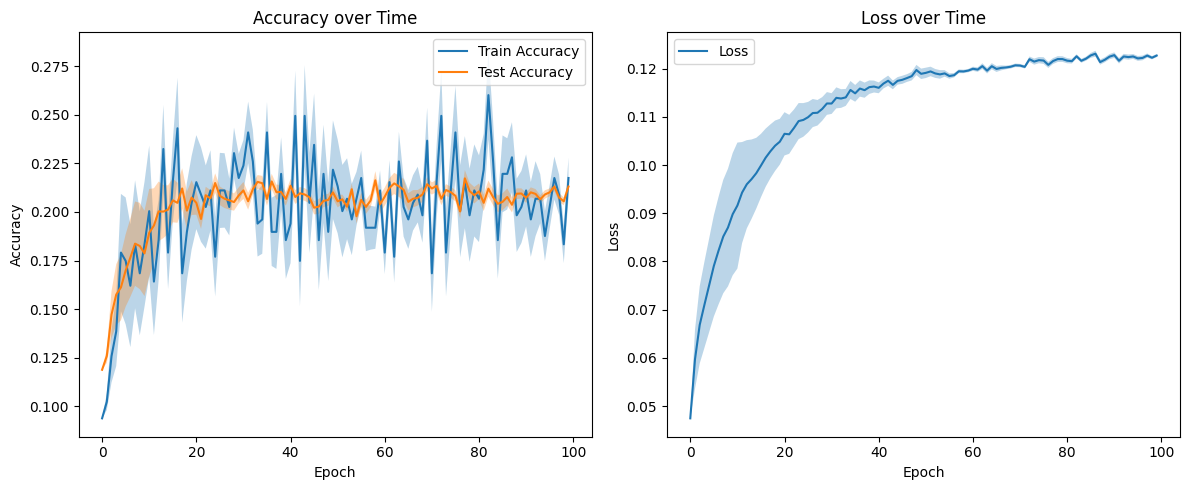

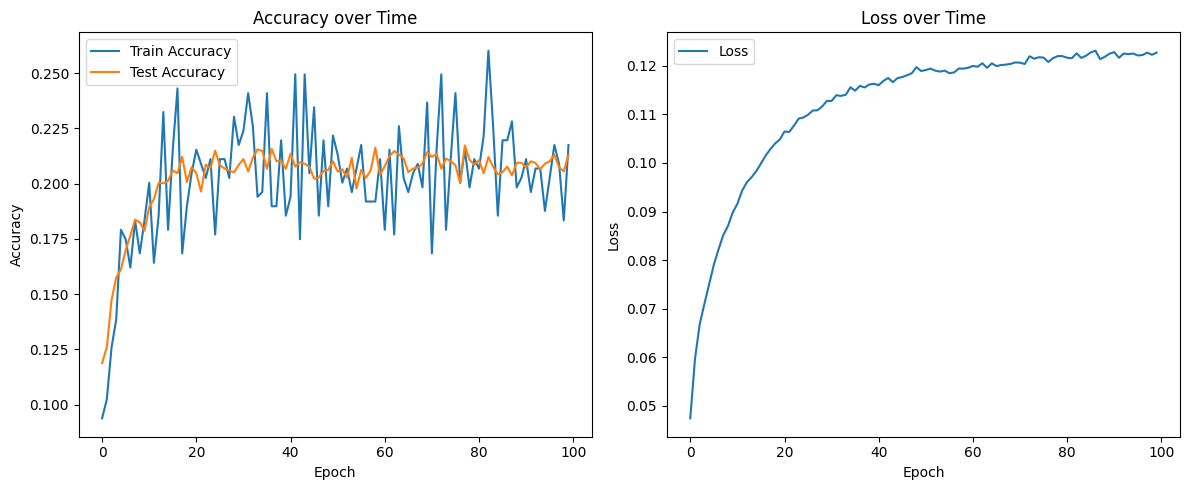

Final Train Accuracy: 0.22 ± 0.01
Final Test Accuracy: 0.21 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1730651041:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.05425813673401692
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1730651041:   1%|          | 1/100 [00:05<08:28,  5.14s/it]

 Test accuracy:  0.4044

correct: 48 total: 469
loss: 0.06531988827785704
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730651041:   2%|▏         | 2/100 [00:10<08:39,  5.30s/it]

 Test accuracy:  0.5315

correct: 276 total: 469
loss: 0.07649615603977683
 Train accuracy:  0.5884861407249466 | 


MLP_MNIST_0_1730651041:   3%|▎         | 3/100 [00:15<08:32,  5.28s/it]

 Test accuracy:  0.6283

correct: 304 total: 469
loss: 0.08698191535053477
 Train accuracy:  0.6481876332622601 | 


MLP_MNIST_0_1730651041:   4%|▍         | 4/100 [00:21<08:26,  5.28s/it]

 Test accuracy:  0.6755

correct: 328 total: 469
loss: 0.0921278628967464
 Train accuracy:  0.6993603411513859 | 


MLP_MNIST_0_1730651041:   5%|▌         | 5/100 [00:26<08:25,  5.32s/it]

 Test accuracy:  0.6969

correct: 322 total: 469
loss: 0.09584881058697507
 Train accuracy:  0.6865671641791045 | 


MLP_MNIST_0_1730651041:   6%|▌         | 6/100 [00:31<08:25,  5.38s/it]

 Test accuracy:  0.7213

correct: 334 total: 469
loss: 0.09857155415994018
 Train accuracy:  0.7121535181236673 | 


MLP_MNIST_0_1730651041:   7%|▋         | 7/100 [00:37<08:28,  5.47s/it]

 Test accuracy:  0.7341

correct: 328 total: 469
loss: 0.10057225497737368
 Train accuracy:  0.6993603411513859 | 


MLP_MNIST_0_1730651041:   8%|▊         | 8/100 [00:43<08:23,  5.47s/it]

 Test accuracy:  0.7399

correct: 339 total: 469
loss: 0.10301538542516704
 Train accuracy:  0.7228144989339019 | 


MLP_MNIST_0_1730651041:   9%|▉         | 9/100 [00:48<08:20,  5.50s/it]

 Test accuracy:  0.746

correct: 324 total: 469
loss: 0.10443812256047466
 Train accuracy:  0.6908315565031983 | 


MLP_MNIST_0_1730651041:  10%|█         | 10/100 [00:54<08:18,  5.53s/it]

 Test accuracy:  0.7593

correct: 348 total: 469
loss: 0.10597371627717639
 Train accuracy:  0.7420042643923241 | 


MLP_MNIST_0_1730651041:  11%|█         | 11/100 [00:59<08:11,  5.52s/it]

 Test accuracy:  0.7596

correct: 367 total: 469
loss: 0.1068890983266617
 Train accuracy:  0.7825159914712153 | 


MLP_MNIST_0_1730651041:  12%|█▏        | 12/100 [01:05<08:08,  5.55s/it]

 Test accuracy:  0.7616

correct: 343 total: 469
loss: 0.10801495170034071
 Train accuracy:  0.7313432835820896 | 


MLP_MNIST_0_1730651041:  13%|█▎        | 13/100 [01:11<08:08,  5.62s/it]

 Test accuracy:  0.7573

correct: 354 total: 469
loss: 0.10899863184006738
 Train accuracy:  0.7547974413646056 | 


MLP_MNIST_0_1730651041:  14%|█▍        | 14/100 [01:16<08:02,  5.61s/it]

 Test accuracy:  0.7671

correct: 338 total: 469
loss: 0.10913988032829025
 Train accuracy:  0.720682302771855 | 


MLP_MNIST_0_1730651041:  15%|█▌        | 15/100 [01:22<07:58,  5.62s/it]

 Test accuracy:  0.7746

correct: 355 total: 469
loss: 0.10982023530613894
 Train accuracy:  0.7569296375266524 | 


MLP_MNIST_0_1730651041:  16%|█▌        | 16/100 [01:28<07:51,  5.61s/it]

 Test accuracy:  0.7672

correct: 366 total: 469
loss: 0.10992086832838527
 Train accuracy:  0.7803837953091685 | 


MLP_MNIST_0_1730651041:  17%|█▋        | 17/100 [01:33<07:45,  5.60s/it]

 Test accuracy:  0.769

correct: 353 total: 469
loss: 0.11074203087576925
 Train accuracy:  0.7526652452025586 | 


MLP_MNIST_0_1730651041:  18%|█▊        | 18/100 [01:39<07:42,  5.64s/it]

 Test accuracy:  0.7712

correct: 353 total: 469
loss: 0.11128889450005122
 Train accuracy:  0.7526652452025586 | 


MLP_MNIST_0_1730651041:  19%|█▉        | 19/100 [01:44<07:36,  5.64s/it]

 Test accuracy:  0.7732

correct: 359 total: 469
loss: 0.11167685846402955
 Train accuracy:  0.7654584221748401 | 


MLP_MNIST_0_1730651041:  20%|██        | 20/100 [01:50<07:31,  5.64s/it]

 Test accuracy:  0.7786

correct: 355 total: 469
loss: 0.11236734094141897
 Train accuracy:  0.7569296375266524 | 


MLP_MNIST_0_1730651041:  21%|██        | 21/100 [01:56<07:26,  5.65s/it]

 Test accuracy:  0.7731

correct: 364 total: 469
loss: 0.11282975109083566
 Train accuracy:  0.7761194029850746 | 


MLP_MNIST_0_1730651041:  22%|██▏       | 22/100 [02:01<07:21,  5.66s/it]

 Test accuracy:  0.7824

correct: 366 total: 469
loss: 0.11297142894855186
 Train accuracy:  0.7803837953091685 | 


MLP_MNIST_0_1730651041:  23%|██▎       | 23/100 [02:07<07:17,  5.68s/it]

 Test accuracy:  0.776

correct: 359 total: 469
loss: 0.112924368571498
 Train accuracy:  0.7654584221748401 | 


MLP_MNIST_0_1730651041:  24%|██▍       | 24/100 [02:13<07:20,  5.80s/it]

 Test accuracy:  0.7735

correct: 380 total: 469
loss: 0.11329260729015
 Train accuracy:  0.8102345415778252 | 


MLP_MNIST_0_1730651041:  25%|██▌       | 25/100 [02:19<07:13,  5.78s/it]

 Test accuracy:  0.778

correct: 361 total: 469
loss: 0.11328791032658457
 Train accuracy:  0.7697228144989339 | 


MLP_MNIST_0_1730651041:  26%|██▌       | 26/100 [02:25<07:07,  5.77s/it]

 Test accuracy:  0.7748

correct: 336 total: 469
loss: 0.11400173798298785
 Train accuracy:  0.7164179104477612 | 


MLP_MNIST_0_1730651041:  27%|██▋       | 27/100 [02:31<07:01,  5.78s/it]

 Test accuracy:  0.7773

correct: 370 total: 469
loss: 0.11316234793172462
 Train accuracy:  0.7889125799573561 | 


MLP_MNIST_0_1730651041:  28%|██▊       | 28/100 [02:36<06:56,  5.78s/it]

 Test accuracy:  0.7802

correct: 344 total: 469
loss: 0.1140094019774435
 Train accuracy:  0.7334754797441365 | 


MLP_MNIST_0_1730651041:  29%|██▉       | 29/100 [02:42<06:52,  5.81s/it]

 Test accuracy:  0.772

correct: 373 total: 469
loss: 0.11428603615715051
 Train accuracy:  0.7953091684434968 | 


MLP_MNIST_0_1730651041:  30%|███       | 30/100 [02:48<06:46,  5.80s/it]

 Test accuracy:  0.7724

correct: 355 total: 469
loss: 0.11391345896065108
 Train accuracy:  0.7569296375266524 | 


MLP_MNIST_0_1730651041:  31%|███       | 31/100 [02:54<06:37,  5.76s/it]

 Test accuracy:  0.7765

correct: 353 total: 469
loss: 0.11434606581862801
 Train accuracy:  0.7526652452025586 | 


MLP_MNIST_0_1730651041:  32%|███▏      | 32/100 [02:59<06:31,  5.76s/it]

 Test accuracy:  0.7809

correct: 367 total: 469
loss: 0.11505421006412649
 Train accuracy:  0.7825159914712153 | 


MLP_MNIST_0_1730651041:  33%|███▎      | 33/100 [03:05<06:27,  5.79s/it]

 Test accuracy:  0.7771

correct: 371 total: 469
loss: 0.11465585822743901
 Train accuracy:  0.7910447761194029 | 


MLP_MNIST_0_1730651041:  34%|███▍      | 34/100 [03:11<06:24,  5.82s/it]

 Test accuracy:  0.7748

correct: 343 total: 469
loss: 0.11556147756988305
 Train accuracy:  0.7313432835820896 | 


MLP_MNIST_0_1730651041:  35%|███▌      | 35/100 [03:17<06:20,  5.85s/it]

 Test accuracy:  0.7781

correct: 359 total: 469
loss: 0.11532328667035743
 Train accuracy:  0.7654584221748401 | 


MLP_MNIST_0_1730651041:  36%|███▌      | 36/100 [03:23<06:12,  5.82s/it]

 Test accuracy:  0.7778

correct: 346 total: 469
loss: 0.11611865290891388
 Train accuracy:  0.7377398720682303 | 


MLP_MNIST_0_1730651041:  37%|███▋      | 37/100 [03:29<06:07,  5.83s/it]

 Test accuracy:  0.7815

correct: 369 total: 469
loss: 0.11590461911105399
 Train accuracy:  0.7867803837953091 | 


MLP_MNIST_0_1730651041:  38%|███▊      | 38/100 [03:34<06:00,  5.82s/it]

 Test accuracy:  0.7763

correct: 345 total: 469
loss: 0.11606085411648252
 Train accuracy:  0.7356076759061834 | 


MLP_MNIST_0_1730651041:  39%|███▉      | 39/100 [03:40<05:54,  5.81s/it]

 Test accuracy:  0.7805

correct: 360 total: 469
loss: 0.11550416981678273
 Train accuracy:  0.767590618336887 | 


MLP_MNIST_0_1730651041:  40%|████      | 40/100 [03:46<05:52,  5.87s/it]

 Test accuracy:  0.7795

correct: 367 total: 469
loss: 0.1150639077493631
 Train accuracy:  0.7825159914712153 | 


MLP_MNIST_0_1730651041:  41%|████      | 41/100 [03:52<05:46,  5.88s/it]

 Test accuracy:  0.7763

correct: 362 total: 469
loss: 0.11569183966371296
 Train accuracy:  0.7718550106609808 | 


MLP_MNIST_0_1730651041:  42%|████▏     | 42/100 [03:58<05:40,  5.87s/it]

 Test accuracy:  0.7794

correct: 355 total: 469
loss: 0.11591510012396362
 Train accuracy:  0.7569296375266524 | 


MLP_MNIST_0_1730651041:  43%|████▎     | 43/100 [04:04<05:36,  5.90s/it]

 Test accuracy:  0.7752

correct: 366 total: 469
loss: 0.11551226599257129
 Train accuracy:  0.7803837953091685 | 


MLP_MNIST_0_1730651041:  44%|████▍     | 44/100 [04:10<05:30,  5.90s/it]

 Test accuracy:  0.7828

correct: 374 total: 469
loss: 0.1163075914038524
 Train accuracy:  0.7974413646055437 | 


MLP_MNIST_0_1730651041:  45%|████▌     | 45/100 [04:16<05:23,  5.88s/it]

 Test accuracy:  0.775

correct: 369 total: 469
loss: 0.11604518332143328
 Train accuracy:  0.7867803837953091 | 


MLP_MNIST_0_1730651041:  46%|████▌     | 46/100 [04:22<05:20,  5.93s/it]

 Test accuracy:  0.7805

correct: 364 total: 469
loss: 0.11563014618750574
 Train accuracy:  0.7761194029850746 | 


MLP_MNIST_0_1730651041:  47%|████▋     | 47/100 [04:28<05:13,  5.91s/it]

 Test accuracy:  0.7751

correct: 356 total: 469
loss: 0.1164528803625849
 Train accuracy:  0.7590618336886994 | 


MLP_MNIST_0_1730651041:  48%|████▊     | 48/100 [04:34<05:08,  5.94s/it]

 Test accuracy:  0.7826

correct: 349 total: 469
loss: 0.11695350539773258
 Train accuracy:  0.744136460554371 | 


MLP_MNIST_0_1730651041:  49%|████▉     | 49/100 [04:40<05:05,  6.00s/it]

 Test accuracy:  0.7813

correct: 351 total: 469
loss: 0.11737428109910188
 Train accuracy:  0.7484008528784648 | 


MLP_MNIST_0_1730651041:  50%|█████     | 50/100 [04:46<04:57,  5.95s/it]

 Test accuracy:  0.778

correct: 367 total: 469
loss: 0.116058098894955
 Train accuracy:  0.7825159914712153 | 


MLP_MNIST_0_1730651041:  51%|█████     | 51/100 [04:52<04:58,  6.09s/it]

 Test accuracy:  0.777

correct: 354 total: 469
loss: 0.11613341652825951
 Train accuracy:  0.7547974413646056 | 


MLP_MNIST_0_1730651041:  52%|█████▏    | 52/100 [04:58<04:49,  6.03s/it]

 Test accuracy:  0.7721

correct: 346 total: 469
loss: 0.11687049984550679
 Train accuracy:  0.7377398720682303 | 


MLP_MNIST_0_1730651041:  53%|█████▎    | 53/100 [05:04<04:40,  5.97s/it]

 Test accuracy:  0.7809

correct: 363 total: 469
loss: 0.11678740844480011
 Train accuracy:  0.7739872068230277 | 


MLP_MNIST_0_1730651041:  54%|█████▍    | 54/100 [05:10<04:35,  5.99s/it]

 Test accuracy:  0.7762

correct: 353 total: 469
loss: 0.11686457148683604
 Train accuracy:  0.7526652452025586 | 


MLP_MNIST_0_1730651041:  55%|█████▌    | 55/100 [05:16<04:28,  5.97s/it]

 Test accuracy:  0.7767

correct: 355 total: 469
loss: 0.1177867645107861
 Train accuracy:  0.7569296375266524 | 


MLP_MNIST_0_1730651041:  56%|█████▌    | 56/100 [05:22<04:24,  6.00s/it]

 Test accuracy:  0.7787

correct: 344 total: 469
loss: 0.11625217103055799
 Train accuracy:  0.7334754797441365 | 


MLP_MNIST_0_1730651041:  57%|█████▋    | 57/100 [05:28<04:17,  5.98s/it]

 Test accuracy:  0.7819

correct: 355 total: 469
loss: 0.11677307476684737
 Train accuracy:  0.7569296375266524 | 


MLP_MNIST_0_1730651041:  58%|█████▊    | 58/100 [05:34<04:11,  5.99s/it]

 Test accuracy:  0.7831

correct: 354 total: 469
loss: 0.11706828549980863
 Train accuracy:  0.7547974413646056 | 


MLP_MNIST_0_1730651041:  59%|█████▉    | 59/100 [05:40<04:06,  6.02s/it]

 Test accuracy:  0.7754

correct: 360 total: 469
loss: 0.11753309716675073
 Train accuracy:  0.767590618336887 | 


MLP_MNIST_0_1730651041:  60%|██████    | 60/100 [05:46<03:58,  5.97s/it]

 Test accuracy:  0.7832

correct: 361 total: 469
loss: 0.11697637420028512
 Train accuracy:  0.7697228144989339 | 


MLP_MNIST_0_1730651041:  61%|██████    | 61/100 [05:52<03:54,  6.00s/it]

 Test accuracy:  0.7777

correct: 352 total: 469
loss: 0.11733486617742571
 Train accuracy:  0.7505330490405118 | 


MLP_MNIST_0_1730651041:  62%|██████▏   | 62/100 [05:58<03:47,  5.98s/it]

 Test accuracy:  0.7751

correct: 355 total: 469
loss: 0.117680675773097
 Train accuracy:  0.7569296375266524 | 


MLP_MNIST_0_1730651041:  63%|██████▎   | 63/100 [06:04<03:41,  5.99s/it]

 Test accuracy:  0.7775

correct: 368 total: 469
loss: 0.11779145866251195
 Train accuracy:  0.7846481876332623 | 


MLP_MNIST_0_1730651041:  64%|██████▍   | 64/100 [06:10<03:37,  6.03s/it]

 Test accuracy:  0.7829

correct: 367 total: 469
loss: 0.11772794624381482
 Train accuracy:  0.7825159914712153 | 


MLP_MNIST_0_1730651041:  65%|██████▌   | 65/100 [06:16<03:30,  6.02s/it]

 Test accuracy:  0.776

correct: 347 total: 469
loss: 0.11818387027361246
 Train accuracy:  0.7398720682302772 | 


MLP_MNIST_0_1730651041:  66%|██████▌   | 66/100 [06:22<03:24,  6.03s/it]

 Test accuracy:  0.7782

correct: 381 total: 469
loss: 0.11782654880015835
 Train accuracy:  0.8123667377398721 | 


MLP_MNIST_0_1730651041:  67%|██████▋   | 67/100 [06:28<03:21,  6.12s/it]

 Test accuracy:  0.7734

correct: 363 total: 469
loss: 0.11779385112496073
 Train accuracy:  0.7739872068230277 | 


MLP_MNIST_0_1730651041:  68%|██████▊   | 68/100 [06:34<03:14,  6.08s/it]

 Test accuracy:  0.7742

correct: 363 total: 469
loss: 0.11779186019955921
 Train accuracy:  0.7739872068230277 | 


MLP_MNIST_0_1730651041:  69%|██████▉   | 69/100 [06:40<03:08,  6.08s/it]

 Test accuracy:  0.7742

correct: 364 total: 469
loss: 0.11740889935605307
 Train accuracy:  0.7761194029850746 | 


MLP_MNIST_0_1730651041:  70%|███████   | 70/100 [06:46<03:02,  6.07s/it]

 Test accuracy:  0.776

correct: 364 total: 469
loss: 0.11774185870184319
 Train accuracy:  0.7761194029850746 | 


MLP_MNIST_0_1730651041:  71%|███████   | 71/100 [06:52<02:55,  6.05s/it]

 Test accuracy:  0.7741

correct: 364 total: 469
loss: 0.1175674825017132
 Train accuracy:  0.7761194029850746 | 


MLP_MNIST_0_1730651041:  72%|███████▏  | 72/100 [06:59<02:51,  6.12s/it]

 Test accuracy:  0.7732

correct: 356 total: 469
loss: 0.11737599711555408
 Train accuracy:  0.7590618336886994 | 


MLP_MNIST_0_1730651041:  73%|███████▎  | 73/100 [07:05<02:44,  6.10s/it]

 Test accuracy:  0.7822

correct: 355 total: 469
loss: 0.11725650654672813
 Train accuracy:  0.7569296375266524 | 


MLP_MNIST_0_1730651041:  74%|███████▍  | 74/100 [07:11<02:38,  6.09s/it]

 Test accuracy:  0.7769

correct: 363 total: 469
loss: 0.11711314427001136
 Train accuracy:  0.7739872068230277 | 


MLP_MNIST_0_1730651041:  75%|███████▌  | 75/100 [07:17<02:31,  6.06s/it]

 Test accuracy:  0.78

correct: 345 total: 469
loss: 0.11829358178860089
 Train accuracy:  0.7356076759061834 | 


MLP_MNIST_0_1730651041:  76%|███████▌  | 76/100 [07:23<02:25,  6.07s/it]

 Test accuracy:  0.7799

correct: 357 total: 469
loss: 0.11798326210426624
 Train accuracy:  0.7611940298507462 | 


MLP_MNIST_0_1730651041:  77%|███████▋  | 77/100 [07:29<02:20,  6.11s/it]

 Test accuracy:  0.7768

correct: 356 total: 469
loss: 0.11753133183984614
 Train accuracy:  0.7590618336886994 | 


MLP_MNIST_0_1730651041:  78%|███████▊  | 78/100 [07:35<02:14,  6.13s/it]

 Test accuracy:  0.7821

correct: 358 total: 469
loss: 0.11820959951132853
 Train accuracy:  0.7633262260127932 | 


MLP_MNIST_0_1730651041:  79%|███████▉  | 79/100 [07:41<02:09,  6.17s/it]

 Test accuracy:  0.773

correct: 359 total: 469
loss: 0.1179192040298285
 Train accuracy:  0.7654584221748401 | 


MLP_MNIST_0_1730651041:  80%|████████  | 80/100 [07:48<02:03,  6.16s/it]

 Test accuracy:  0.7811

correct: 356 total: 469
loss: 0.11830771164789891
 Train accuracy:  0.7590618336886994 | 


MLP_MNIST_0_1730651041:  81%|████████  | 81/100 [07:54<01:57,  6.17s/it]

 Test accuracy:  0.7829

correct: 344 total: 469
loss: 0.11831339768001012
 Train accuracy:  0.7334754797441365 | 


MLP_MNIST_0_1730651041:  82%|████████▏ | 82/100 [08:00<01:52,  6.23s/it]

 Test accuracy:  0.7781

correct: 363 total: 469
loss: 0.11755750317182113
 Train accuracy:  0.7739872068230277 | 


MLP_MNIST_0_1730651041:  83%|████████▎ | 83/100 [08:06<01:45,  6.18s/it]

 Test accuracy:  0.7731

correct: 370 total: 469
loss: 0.1181420853365459
 Train accuracy:  0.7889125799573561 | 


MLP_MNIST_0_1730651041:  84%|████████▍ | 84/100 [08:12<01:38,  6.16s/it]

 Test accuracy:  0.7792

correct: 360 total: 469
loss: 0.1190323114935269
 Train accuracy:  0.767590618336887 | 


MLP_MNIST_0_1730651041:  85%|████████▌ | 85/100 [08:19<01:33,  6.21s/it]

 Test accuracy:  0.7778

correct: 348 total: 469
loss: 0.11835685739321496
 Train accuracy:  0.7420042643923241 | 


MLP_MNIST_0_1730651041:  86%|████████▌ | 86/100 [08:25<01:27,  6.23s/it]

 Test accuracy:  0.7755

correct: 375 total: 469
loss: 0.1187995453633225
 Train accuracy:  0.7995735607675906 | 


MLP_MNIST_0_1730651041:  87%|████████▋ | 87/100 [08:31<01:21,  6.25s/it]

 Test accuracy:  0.7738

correct: 369 total: 469
loss: 0.11786601865596609
 Train accuracy:  0.7867803837953091 | 


MLP_MNIST_0_1730651041:  88%|████████▊ | 88/100 [08:38<01:15,  6.28s/it]

 Test accuracy:  0.7748

correct: 346 total: 469
loss: 0.11829263604144806
 Train accuracy:  0.7377398720682303 | 


MLP_MNIST_0_1730651041:  89%|████████▉ | 89/100 [08:44<01:08,  6.24s/it]

 Test accuracy:  0.7796

correct: 352 total: 469
loss: 0.11894305949526301
 Train accuracy:  0.7505330490405118 | 


MLP_MNIST_0_1730651041:  90%|█████████ | 90/100 [08:50<01:02,  6.22s/it]

 Test accuracy:  0.7795

correct: 358 total: 469
loss: 0.11849169831858007
 Train accuracy:  0.7633262260127932 | 


MLP_MNIST_0_1730651041:  91%|█████████ | 91/100 [08:56<00:55,  6.20s/it]

 Test accuracy:  0.7759

correct: 346 total: 469
loss: 0.11879903027243706
 Train accuracy:  0.7377398720682303 | 


MLP_MNIST_0_1730651041:  92%|█████████▏| 92/100 [09:02<00:49,  6.20s/it]

 Test accuracy:  0.78

correct: 370 total: 469
loss: 0.11841631772866382
 Train accuracy:  0.7889125799573561 | 


MLP_MNIST_0_1730651041:  93%|█████████▎| 93/100 [09:09<00:43,  6.24s/it]

 Test accuracy:  0.7772

correct: 344 total: 469
loss: 0.11878769355478572
 Train accuracy:  0.7334754797441365 | 


MLP_MNIST_0_1730651041:  94%|█████████▍| 94/100 [09:15<00:37,  6.25s/it]

 Test accuracy:  0.7776

correct: 379 total: 469
loss: 0.11841144516015611
 Train accuracy:  0.8081023454157783 | 


MLP_MNIST_0_1730651041:  95%|█████████▌| 95/100 [09:21<00:31,  6.25s/it]

 Test accuracy:  0.7759

correct: 365 total: 469
loss: 0.11891078809176935
 Train accuracy:  0.7782515991471215 | 


MLP_MNIST_0_1730651041:  96%|█████████▌| 96/100 [09:27<00:25,  6.25s/it]

 Test accuracy:  0.7802

correct: 347 total: 469
loss: 0.11833751441509739
 Train accuracy:  0.7398720682302772 | 


MLP_MNIST_0_1730651041:  97%|█████████▋| 97/100 [09:34<00:19,  6.38s/it]

 Test accuracy:  0.7762

correct: 356 total: 469
loss: 0.11881854918910496
 Train accuracy:  0.7590618336886994 | 


MLP_MNIST_0_1730651041:  98%|█████████▊| 98/100 [09:41<00:13,  6.50s/it]

 Test accuracy:  0.7799

correct: 363 total: 469
loss: 0.1179284694225295
 Train accuracy:  0.7739872068230277 | 


MLP_MNIST_0_1730651041:  99%|█████████▉| 99/100 [09:48<00:06,  6.59s/it]

 Test accuracy:  0.7734

correct: 369 total: 469
loss: 0.1189090367764044
 Train accuracy:  0.7867803837953091 | 


MLP_MNIST_0_1730651041: 100%|██████████| 100/100 [09:55<00:00,  5.95s/it]

 Test accuracy:  0.7758


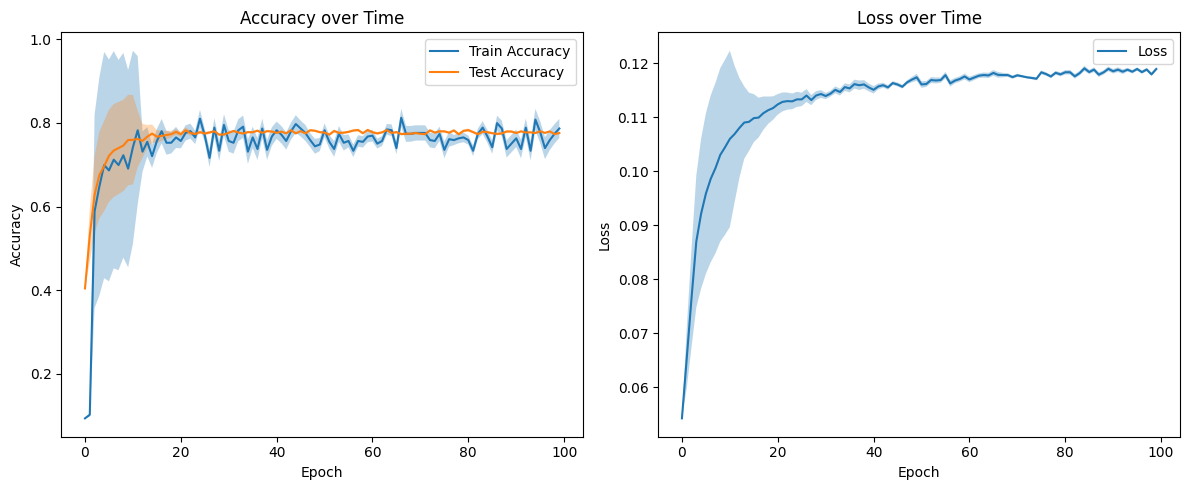

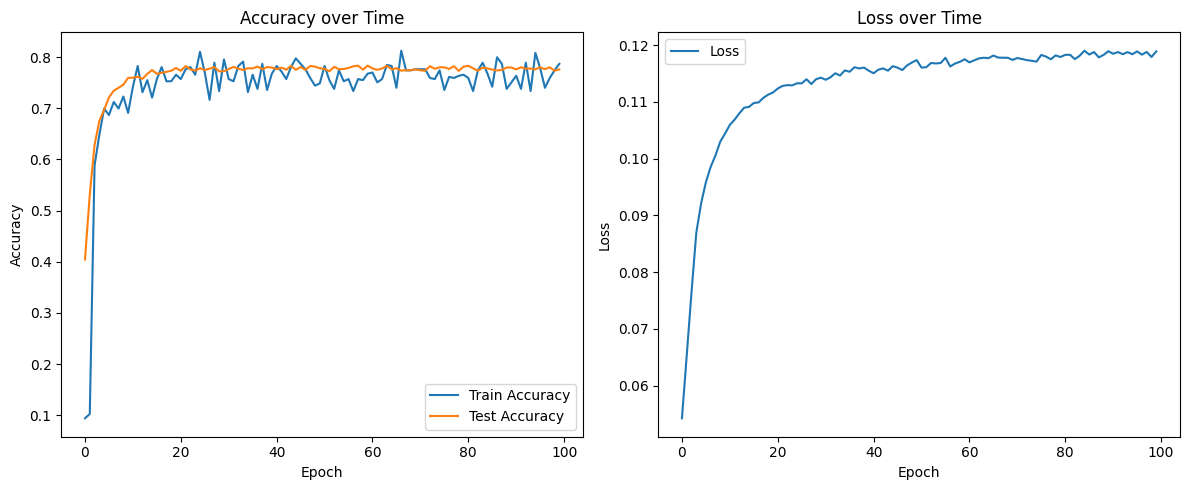

Final Train Accuracy: 0.79 ± 0.02
Final Test Accuracy: 0.78 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1730651639:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.06521496685074844
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1730651639:   1%|          | 1/100 [00:05<08:28,  5.13s/it]

 Test accuracy:  0.1009

correct: 48 total: 469
loss: 0.09088887738139391
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730651639:   2%|▏         | 2/100 [00:11<09:37,  5.90s/it]

 Test accuracy:  0.1009

correct: 75 total: 469
loss: 0.09547011784589621
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1730651639:   3%|▎         | 3/100 [00:17<09:14,  5.72s/it]

 Test accuracy:  0.1189

correct: 78 total: 469
loss: 0.09956221687577681
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1730651639:   4%|▍         | 4/100 [00:22<09:14,  5.77s/it]

 Test accuracy:  0.1417

correct: 72 total: 469
loss: 0.10245386080574125
 Train accuracy:  0.1535181236673774 | 


MLP_MNIST_0_1730651639:   5%|▌         | 5/100 [00:29<09:24,  5.95s/it]

 Test accuracy:  0.1815

correct: 69 total: 469
loss: 0.10102269549105468
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1730651639:   6%|▌         | 6/100 [00:36<09:55,  6.33s/it]

 Test accuracy:  0.1687

correct: 89 total: 469
loss: 0.1017794783181473
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1730651639:   7%|▋         | 7/100 [00:43<10:22,  6.69s/it]

 Test accuracy:  0.1831

correct: 96 total: 469
loss: 0.10220495689271102
 Train accuracy:  0.2046908315565032 | 


MLP_MNIST_0_1730651639:   8%|▊         | 8/100 [00:50<10:14,  6.68s/it]

 Test accuracy:  0.1979

correct: 78 total: 469
loss: 0.10222486619438444
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1730651639:   9%|▉         | 9/100 [00:57<10:10,  6.71s/it]

 Test accuracy:  0.2094

correct: 95 total: 469
loss: 0.10423864786431733
 Train accuracy:  0.2025586353944563 | 


MLP_MNIST_0_1730651639:  10%|█         | 10/100 [01:03<10:03,  6.70s/it]

 Test accuracy:  0.2044

correct: 84 total: 469
loss: 0.10456606192883652
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1730651639:  11%|█         | 11/100 [01:10<10:08,  6.83s/it]

 Test accuracy:  0.1927

correct: 101 total: 469
loss: 0.10603951780335989
 Train accuracy:  0.21535181236673773 | 


MLP_MNIST_0_1730651639:  12%|█▏        | 12/100 [01:17<09:57,  6.79s/it]

 Test accuracy:  0.1907

correct: 87 total: 469
loss: 0.10603669592375949
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1730651639:  13%|█▎        | 13/100 [01:24<09:46,  6.74s/it]

 Test accuracy:  0.2043

correct: 92 total: 469
loss: 0.10674370308992451
 Train accuracy:  0.19616204690831557 | 


MLP_MNIST_0_1730651639:  14%|█▍        | 14/100 [01:30<09:34,  6.68s/it]

 Test accuracy:  0.2128

correct: 94 total: 469
loss: 0.10664556650464722
 Train accuracy:  0.20042643923240938 | 


MLP_MNIST_0_1730651639:  15%|█▌        | 15/100 [01:37<09:31,  6.72s/it]

 Test accuracy:  0.2077

correct: 99 total: 469
loss: 0.10885423850784423
 Train accuracy:  0.21108742004264391 | 


MLP_MNIST_0_1730651639:  16%|█▌        | 16/100 [01:44<09:31,  6.81s/it]

 Test accuracy:  0.2144

correct: 92 total: 469
loss: 0.10756199516213016
 Train accuracy:  0.19616204690831557 | 


MLP_MNIST_0_1730651639:  17%|█▋        | 17/100 [01:51<09:15,  6.70s/it]

 Test accuracy:  0.214

correct: 98 total: 469
loss: 0.10903619601528274
 Train accuracy:  0.208955223880597 | 


MLP_MNIST_0_1730651639:  18%|█▊        | 18/100 [01:57<09:08,  6.68s/it]

 Test accuracy:  0.2115

correct: 102 total: 469
loss: 0.11035134443151418
 Train accuracy:  0.21748400852878466 | 


MLP_MNIST_0_1730651639:  19%|█▉        | 19/100 [02:04<09:00,  6.67s/it]

 Test accuracy:  0.2119

correct: 98 total: 469
loss: 0.11045861175891433
 Train accuracy:  0.208955223880597 | 


MLP_MNIST_0_1730651639:  20%|██        | 20/100 [02:10<08:51,  6.64s/it]

 Test accuracy:  0.2159

correct: 101 total: 469
loss: 0.10942457975355038
 Train accuracy:  0.21535181236673773 | 


MLP_MNIST_0_1730651639:  21%|██        | 21/100 [02:17<08:44,  6.64s/it]

 Test accuracy:  0.215

correct: 83 total: 469
loss: 0.10958001463969888
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1730651639:  22%|██▏       | 22/100 [02:23<08:30,  6.55s/it]

 Test accuracy:  0.2186

correct: 102 total: 469
loss: 0.1110385989329454
 Train accuracy:  0.21748400852878466 | 


MLP_MNIST_0_1730651639:  23%|██▎       | 23/100 [02:30<08:15,  6.44s/it]

 Test accuracy:  0.2157

correct: 103 total: 469
loss: 0.11127355470776812
 Train accuracy:  0.21961620469083157 | 


MLP_MNIST_0_1730651639:  24%|██▍       | 24/100 [02:36<08:07,  6.41s/it]

 Test accuracy:  0.2148

correct: 97 total: 469
loss: 0.11120981699240996
 Train accuracy:  0.2068230277185501 | 


MLP_MNIST_0_1730651639:  25%|██▌       | 25/100 [02:42<08:00,  6.41s/it]

 Test accuracy:  0.2171

correct: 96 total: 469
loss: 0.11088684015373178
 Train accuracy:  0.2046908315565032 | 


MLP_MNIST_0_1730651639:  26%|██▌       | 26/100 [02:49<07:59,  6.48s/it]

 Test accuracy:  0.2098

correct: 90 total: 469
loss: 0.11162151205641374
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1730651639:  27%|██▋       | 27/100 [02:55<07:48,  6.42s/it]

 Test accuracy:  0.2129

correct: 105 total: 469
loss: 0.11167981329439546
 Train accuracy:  0.22388059701492538 | 


MLP_MNIST_0_1730651639:  28%|██▊       | 28/100 [03:02<07:44,  6.45s/it]

 Test accuracy:  0.2146

correct: 85 total: 469
loss: 0.11107050860995676
 Train accuracy:  0.1812366737739872 | 


MLP_MNIST_0_1730651639:  29%|██▉       | 29/100 [03:08<07:35,  6.42s/it]

 Test accuracy:  0.2136

correct: 95 total: 469
loss: 0.1115764645116924
 Train accuracy:  0.2025586353944563 | 


MLP_MNIST_0_1730651639:  30%|███       | 30/100 [03:15<07:28,  6.41s/it]

 Test accuracy:  0.2146

correct: 92 total: 469
loss: 0.11255265858127618
 Train accuracy:  0.19616204690831557 | 


MLP_MNIST_0_1730651639:  31%|███       | 31/100 [03:21<07:26,  6.47s/it]

 Test accuracy:  0.2121

correct: 108 total: 469
loss: 0.11301096605021817
 Train accuracy:  0.2302771855010661 | 


MLP_MNIST_0_1730651639:  32%|███▏      | 32/100 [03:27<07:17,  6.43s/it]

 Test accuracy:  0.214

correct: 105 total: 469
loss: 0.11291072336531906
 Train accuracy:  0.22388059701492538 | 


MLP_MNIST_0_1730651639:  33%|███▎      | 33/100 [03:34<07:09,  6.41s/it]

 Test accuracy:  0.2065

correct: 92 total: 469
loss: 0.11289043549789803
 Train accuracy:  0.19616204690831557 | 


MLP_MNIST_0_1730651639:  34%|███▍      | 34/100 [03:40<07:04,  6.43s/it]

 Test accuracy:  0.2081

correct: 105 total: 469
loss: 0.11258571102484458
 Train accuracy:  0.22388059701492538 | 


MLP_MNIST_0_1730651639:  35%|███▌      | 35/100 [03:47<06:55,  6.38s/it]

 Test accuracy:  0.2121

correct: 93 total: 469
loss: 0.11318445324834221
 Train accuracy:  0.19829424307036247 | 


MLP_MNIST_0_1730651639:  36%|███▌      | 36/100 [03:53<06:50,  6.42s/it]

 Test accuracy:  0.2112

correct: 90 total: 469
loss: 0.11331219404046215
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1730651639:  37%|███▋      | 37/100 [04:00<06:44,  6.42s/it]

 Test accuracy:  0.2116

correct: 108 total: 469
loss: 0.11444191450376247
 Train accuracy:  0.2302771855010661 | 


MLP_MNIST_0_1730651639:  38%|███▊      | 38/100 [04:06<06:40,  6.46s/it]

 Test accuracy:  0.2099

correct: 90 total: 469
loss: 0.11379948048703452
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1730651639:  39%|███▉      | 39/100 [04:13<06:34,  6.47s/it]

 Test accuracy:  0.2128

correct: 102 total: 469
loss: 0.11303968351088099
 Train accuracy:  0.21748400852878466 | 


MLP_MNIST_0_1730651639:  40%|████      | 40/100 [04:19<06:28,  6.48s/it]

 Test accuracy:  0.2112

correct: 82 total: 469
loss: 0.11380270539697554
 Train accuracy:  0.17484008528784648 | 


MLP_MNIST_0_1730651639:  41%|████      | 41/100 [04:26<06:24,  6.52s/it]

 Test accuracy:  0.2108

correct: 99 total: 469
loss: 0.11301109973174422
 Train accuracy:  0.21108742004264391 | 


MLP_MNIST_0_1730651639:  42%|████▏     | 42/100 [04:32<06:16,  6.49s/it]

 Test accuracy:  0.2126

correct: 102 total: 469
loss: 0.11383085043382035
 Train accuracy:  0.21748400852878466 | 


MLP_MNIST_0_1730651639:  43%|████▎     | 43/100 [04:39<06:09,  6.48s/it]

 Test accuracy:  0.2112

correct: 96 total: 469
loss: 0.11361717002224057
 Train accuracy:  0.2046908315565032 | 


MLP_MNIST_0_1730651639:  44%|████▍     | 44/100 [04:45<06:03,  6.49s/it]

 Test accuracy:  0.2082

correct: 101 total: 469
loss: 0.11403610353975661
 Train accuracy:  0.21535181236673773 | 


MLP_MNIST_0_1730651639:  45%|████▌     | 45/100 [04:51<05:55,  6.46s/it]

 Test accuracy:  0.2151

correct: 119 total: 469
loss: 0.11444286372997105
 Train accuracy:  0.2537313432835821 | 


MLP_MNIST_0_1730651639:  46%|████▌     | 46/100 [04:58<05:51,  6.52s/it]

 Test accuracy:  0.2087

correct: 92 total: 469
loss: 0.11487115633640207
 Train accuracy:  0.19616204690831557 | 


MLP_MNIST_0_1730651639:  47%|████▋     | 47/100 [05:05<05:46,  6.53s/it]

 Test accuracy:  0.2105

correct: 93 total: 469
loss: 0.11491459350723193
 Train accuracy:  0.19829424307036247 | 


MLP_MNIST_0_1730651639:  48%|████▊     | 48/100 [05:11<05:43,  6.61s/it]

 Test accuracy:  0.2102

correct: 99 total: 469
loss: 0.1140825317612589
 Train accuracy:  0.21108742004264391 | 


MLP_MNIST_0_1730651639:  49%|████▉     | 49/100 [05:18<05:35,  6.58s/it]

 Test accuracy:  0.2137

correct: 95 total: 469
loss: 0.11459816631668412
 Train accuracy:  0.2025586353944563 | 


MLP_MNIST_0_1730651639:  50%|█████     | 50/100 [05:25<05:29,  6.59s/it]

 Test accuracy:  0.2128

correct: 89 total: 469
loss: 0.1151204320635877
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1730651639:  51%|█████     | 51/100 [05:31<05:22,  6.59s/it]

 Test accuracy:  0.2108

correct: 82 total: 469
loss: 0.11487750640746627
 Train accuracy:  0.17484008528784648 | 


MLP_MNIST_0_1730651639:  52%|█████▏    | 52/100 [05:38<05:17,  6.62s/it]

 Test accuracy:  0.2098

correct: 84 total: 469
loss: 0.11414810217646902
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1730651639:  53%|█████▎    | 53/100 [05:44<05:10,  6.60s/it]

 Test accuracy:  0.2132

correct: 107 total: 469
loss: 0.1148617921480492
 Train accuracy:  0.2281449893390192 | 


MLP_MNIST_0_1730651639:  54%|█████▍    | 54/100 [05:51<05:02,  6.58s/it]

 Test accuracy:  0.211

correct: 99 total: 469
loss: 0.11525664041672688
 Train accuracy:  0.21108742004264391 | 


MLP_MNIST_0_1730651639:  55%|█████▌    | 55/100 [05:58<04:57,  6.62s/it]

 Test accuracy:  0.214

correct: 104 total: 469
loss: 0.114742125974281
 Train accuracy:  0.22174840085287847 | 


MLP_MNIST_0_1730651639:  56%|█████▌    | 56/100 [06:05<04:55,  6.71s/it]

 Test accuracy:  0.2139

correct: 92 total: 469
loss: 0.11576540010379575
 Train accuracy:  0.19616204690831557 | 


MLP_MNIST_0_1730651639:  57%|█████▋    | 57/100 [06:11<04:50,  6.76s/it]

 Test accuracy:  0.2116

correct: 94 total: 469
loss: 0.11494194792468411
 Train accuracy:  0.20042643923240938 | 


MLP_MNIST_0_1730651639:  58%|█████▊    | 58/100 [06:18<04:40,  6.69s/it]

 Test accuracy:  0.2118

correct: 71 total: 469
loss: 0.11471988378303137
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1730651639:  59%|█████▉    | 59/100 [06:24<04:31,  6.62s/it]

 Test accuracy:  0.2117

correct: 78 total: 469
loss: 0.11453258814905752
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1730651639:  60%|██████    | 60/100 [06:31<04:26,  6.66s/it]

 Test accuracy:  0.2108

correct: 96 total: 469
loss: 0.11402070970296352
 Train accuracy:  0.2046908315565032 | 


MLP_MNIST_0_1730651639:  61%|██████    | 61/100 [06:38<04:19,  6.65s/it]

 Test accuracy:  0.2116

correct: 84 total: 469
loss: 0.11510574015409453
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1730651639:  62%|██████▏   | 62/100 [06:44<04:12,  6.66s/it]

 Test accuracy:  0.2105

correct: 89 total: 469
loss: 0.11474543346016645
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1730651639:  63%|██████▎   | 63/100 [06:51<04:05,  6.63s/it]

 Test accuracy:  0.2129

correct: 109 total: 469
loss: 0.11445767986876115
 Train accuracy:  0.232409381663113 | 


MLP_MNIST_0_1730651639:  64%|██████▍   | 64/100 [06:58<03:56,  6.57s/it]

 Test accuracy:  0.211

correct: 102 total: 469
loss: 0.11475029859397966
 Train accuracy:  0.21748400852878466 | 


MLP_MNIST_0_1730651639:  65%|██████▌   | 65/100 [07:04<03:53,  6.66s/it]

 Test accuracy:  0.2108

correct: 97 total: 469
loss: 0.11521428597888458
 Train accuracy:  0.2068230277185501 | 


MLP_MNIST_0_1730651639:  66%|██████▌   | 66/100 [07:11<03:45,  6.63s/it]

 Test accuracy:  0.2136

correct: 111 total: 469
loss: 0.11505084721518478
 Train accuracy:  0.23667377398720682 | 


MLP_MNIST_0_1730651639:  67%|██████▋   | 67/100 [07:18<03:38,  6.62s/it]

 Test accuracy:  0.2104

correct: 96 total: 469
loss: 0.11531295965729492
 Train accuracy:  0.2046908315565032 | 


MLP_MNIST_0_1730651639:  68%|██████▊   | 68/100 [07:24<03:29,  6.56s/it]

 Test accuracy:  0.2128

correct: 104 total: 469
loss: 0.115497270102567
 Train accuracy:  0.22174840085287847 | 


MLP_MNIST_0_1730651639:  69%|██████▉   | 69/100 [07:31<03:23,  6.56s/it]

 Test accuracy:  0.2151

correct: 78 total: 469
loss: 0.115738534549279
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1730651639:  70%|███████   | 70/100 [07:37<03:20,  6.67s/it]

 Test accuracy:  0.2114

correct: 82 total: 469
loss: 0.11512086653251892
 Train accuracy:  0.17484008528784648 | 


MLP_MNIST_0_1730651639:  71%|███████   | 71/100 [07:44<03:13,  6.68s/it]

 Test accuracy:  0.2117

correct: 93 total: 469
loss: 0.11476999713477296
 Train accuracy:  0.19829424307036247 | 


MLP_MNIST_0_1730651639:  72%|███████▏  | 72/100 [07:51<03:07,  6.69s/it]

 Test accuracy:  0.2123

correct: 105 total: 469
loss: 0.11448024610466541
 Train accuracy:  0.22388059701492538 | 


MLP_MNIST_0_1730651639:  73%|███████▎  | 73/100 [07:58<03:00,  6.68s/it]

 Test accuracy:  0.2102

correct: 96 total: 469
loss: 0.11576970410880758
 Train accuracy:  0.2046908315565032 | 


MLP_MNIST_0_1730651639:  74%|███████▍  | 74/100 [08:04<02:55,  6.76s/it]

 Test accuracy:  0.2144

correct: 106 total: 469
loss: 0.11528020828708148
 Train accuracy:  0.2260127931769723 | 


MLP_MNIST_0_1730651639:  75%|███████▌  | 75/100 [08:11<02:48,  6.72s/it]

 Test accuracy:  0.214

correct: 88 total: 469
loss: 0.1152848320792733
 Train accuracy:  0.18763326226012794 | 


MLP_MNIST_0_1730651639:  76%|███████▌  | 76/100 [08:18<02:40,  6.70s/it]

 Test accuracy:  0.2143

correct: 92 total: 469
loss: 0.11446067295285431
 Train accuracy:  0.19616204690831557 | 


MLP_MNIST_0_1730651639:  77%|███████▋  | 77/100 [08:24<02:34,  6.70s/it]

 Test accuracy:  0.2124

correct: 99 total: 469
loss: 0.11514880800488661
 Train accuracy:  0.21108742004264391 | 


MLP_MNIST_0_1730651639:  78%|███████▊  | 78/100 [08:31<02:26,  6.66s/it]

 Test accuracy:  0.2112

correct: 107 total: 469
loss: 0.11587429796454748
 Train accuracy:  0.2281449893390192 | 


MLP_MNIST_0_1730651639:  79%|███████▉  | 79/100 [08:38<02:21,  6.73s/it]

 Test accuracy:  0.2137

correct: 97 total: 469
loss: 0.11536883723252872
 Train accuracy:  0.2068230277185501 | 


MLP_MNIST_0_1730651639:  80%|████████  | 80/100 [08:44<02:13,  6.68s/it]

 Test accuracy:  0.2116

correct: 102 total: 469
loss: 0.11552700945245686
 Train accuracy:  0.21748400852878466 | 


MLP_MNIST_0_1730651639:  81%|████████  | 81/100 [08:51<02:06,  6.68s/it]

 Test accuracy:  0.2098

correct: 99 total: 469
loss: 0.11469260514227313
 Train accuracy:  0.21108742004264391 | 


MLP_MNIST_0_1730651639:  82%|████████▏ | 82/100 [08:58<01:59,  6.66s/it]

 Test accuracy:  0.2116

correct: 95 total: 469
loss: 0.11542702456717806
 Train accuracy:  0.2025586353944563 | 


MLP_MNIST_0_1730651639:  83%|████████▎ | 83/100 [09:04<01:53,  6.66s/it]

 Test accuracy:  0.2131

correct: 96 total: 469
loss: 0.11584904661247217
 Train accuracy:  0.2046908315565032 | 


MLP_MNIST_0_1730651639:  84%|████████▍ | 84/100 [09:11<01:47,  6.73s/it]

 Test accuracy:  0.2078

correct: 90 total: 469
loss: 0.11596424378820065
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1730651639:  85%|████████▌ | 85/100 [09:18<01:40,  6.69s/it]

 Test accuracy:  0.2114

correct: 89 total: 469
loss: 0.11566690373014031
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1730651639:  86%|████████▌ | 86/100 [09:25<01:33,  6.69s/it]

 Test accuracy:  0.2109

correct: 106 total: 469
loss: 0.11545376574942298
 Train accuracy:  0.2260127931769723 | 


MLP_MNIST_0_1730651639:  87%|████████▋ | 87/100 [09:31<01:26,  6.68s/it]

 Test accuracy:  0.2119

correct: 87 total: 469
loss: 0.11573943003281348
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1730651639:  88%|████████▊ | 88/100 [09:38<01:20,  6.71s/it]

 Test accuracy:  0.21

correct: 97 total: 469
loss: 0.11604036246217898
 Train accuracy:  0.2068230277185501 | 


MLP_MNIST_0_1730651639:  89%|████████▉ | 89/100 [09:45<01:13,  6.72s/it]

 Test accuracy:  0.212

correct: 97 total: 469
loss: 0.11612487520808096
 Train accuracy:  0.2068230277185501 | 


MLP_MNIST_0_1730651639:  90%|█████████ | 90/100 [09:51<01:07,  6.70s/it]

 Test accuracy:  0.2111

correct: 95 total: 469
loss: 0.11656241784535491
 Train accuracy:  0.2025586353944563 | 


MLP_MNIST_0_1730651639:  91%|█████████ | 91/100 [09:58<01:00,  6.70s/it]

 Test accuracy:  0.211

correct: 97 total: 469
loss: 0.11608203470325673
 Train accuracy:  0.2068230277185501 | 


MLP_MNIST_0_1730651639:  92%|█████████▏| 92/100 [10:05<00:53,  6.72s/it]

 Test accuracy:  0.2094

correct: 90 total: 469
loss: 0.1155121825111192
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1730651639:  93%|█████████▎| 93/100 [10:12<00:47,  6.81s/it]

 Test accuracy:  0.2094

correct: 101 total: 469
loss: 0.11573485345410894
 Train accuracy:  0.21535181236673773 | 


MLP_MNIST_0_1730651639:  94%|█████████▍| 94/100 [10:19<00:40,  6.81s/it]

 Test accuracy:  0.2096

correct: 73 total: 469
loss: 0.11528291648575492
 Train accuracy:  0.15565031982942432 | 


MLP_MNIST_0_1730651639:  95%|█████████▌| 95/100 [10:25<00:33,  6.79s/it]

 Test accuracy:  0.2121

correct: 88 total: 469
loss: 0.11572736492162065
 Train accuracy:  0.18763326226012794 | 


MLP_MNIST_0_1730651639:  96%|█████████▌| 96/100 [10:32<00:27,  6.79s/it]

 Test accuracy:  0.211

correct: 79 total: 469
loss: 0.11551360503188583
 Train accuracy:  0.16844349680170576 | 


MLP_MNIST_0_1730651639:  97%|█████████▋| 97/100 [10:39<00:20,  6.81s/it]

 Test accuracy:  0.2095

correct: 86 total: 469
loss: 0.1152462165778888
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1730651639:  98%|█████████▊| 98/100 [10:46<00:13,  6.84s/it]

 Test accuracy:  0.2117

correct: 96 total: 469
loss: 0.11492815534316146
 Train accuracy:  0.2046908315565032 | 


MLP_MNIST_0_1730651639:  99%|█████████▉| 99/100 [10:53<00:06,  6.80s/it]

 Test accuracy:  0.2075

correct: 81 total: 469
loss: 0.11604507151506603
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1730651639: 100%|██████████| 100/100 [11:00<00:00,  6.60s/it]

 Test accuracy:  0.2152


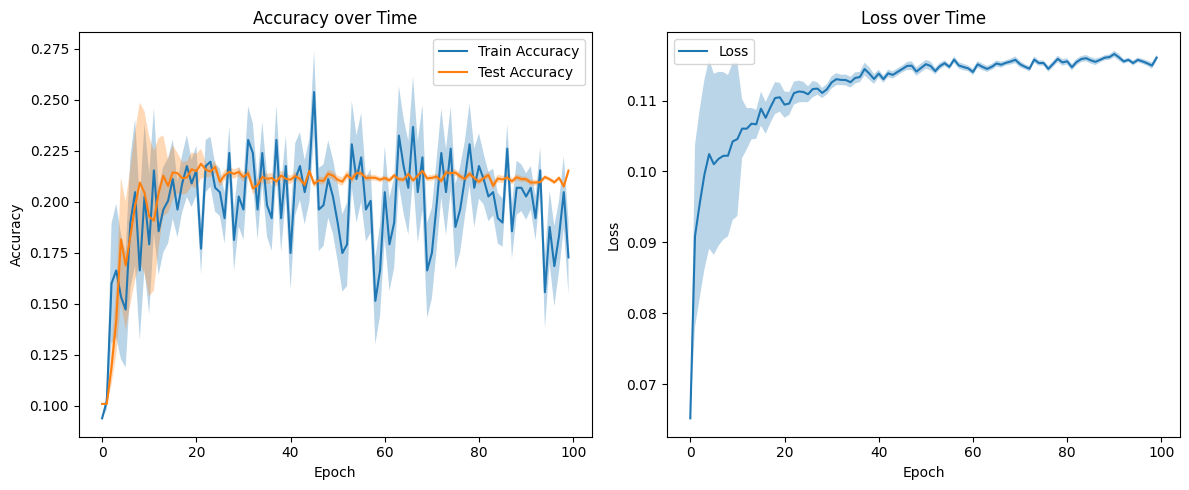

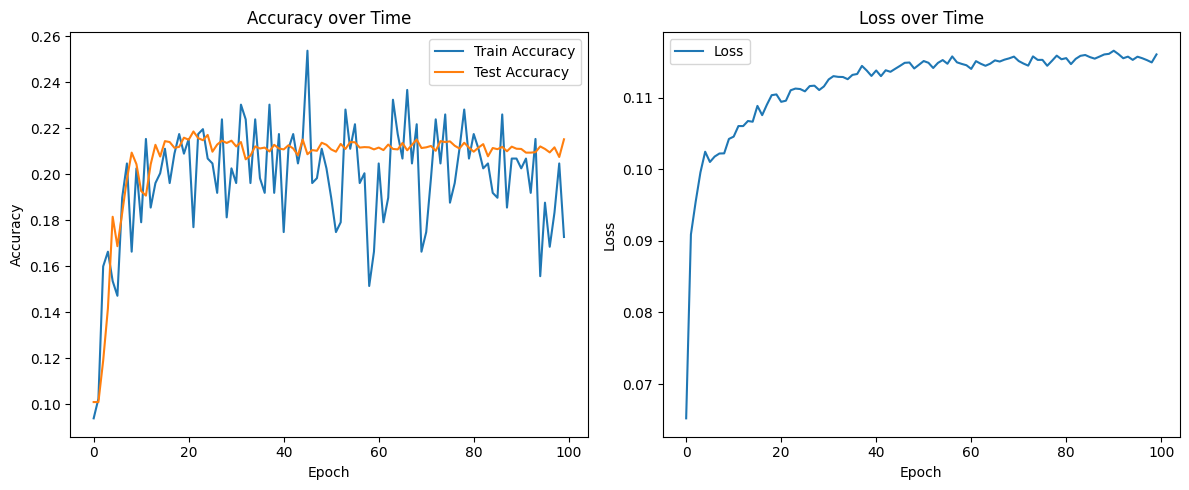

Final Train Accuracy: 0.17 ± 0.02
Final Test Accuracy: 0.22 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1730652302:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.06138336051628788
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1730652302:   1%|          | 1/100 [00:05<09:22,  5.68s/it]

 Test accuracy:  0.1075

correct: 48 total: 469
loss: 0.08292611346030032
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730652302:   2%|▏         | 2/100 [00:11<09:13,  5.65s/it]

 Test accuracy:  0.1086

correct: 65 total: 469
loss: 0.08887163526626793
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1730652302:   3%|▎         | 3/100 [00:16<09:00,  5.57s/it]

 Test accuracy:  0.1155

correct: 52 total: 469
loss: 0.09265525327689612
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730652302:   4%|▍         | 4/100 [00:22<08:54,  5.57s/it]

 Test accuracy:  0.1177

correct: 63 total: 469
loss: 0.09539943638005491
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730652302:   5%|▌         | 5/100 [00:27<08:47,  5.55s/it]

 Test accuracy:  0.1102

correct: 56 total: 469
loss: 0.09596211288465874
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730652302:   6%|▌         | 6/100 [00:33<08:42,  5.56s/it]

 Test accuracy:  0.1086

correct: 62 total: 469
loss: 0.09869153403651232
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730652302:   7%|▋         | 7/100 [00:39<08:41,  5.61s/it]

 Test accuracy:  0.1199

correct: 58 total: 469
loss: 0.09817266642157711
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730652302:   8%|▊         | 8/100 [00:44<08:41,  5.67s/it]

 Test accuracy:  0.1125

correct: 48 total: 469
loss: 0.09723634376073442
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730652302:   9%|▉         | 9/100 [00:50<08:36,  5.67s/it]

 Test accuracy:  0.1138

correct: 64 total: 469
loss: 0.09803908950547928
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730652302:  10%|█         | 10/100 [00:56<08:30,  5.67s/it]

 Test accuracy:  0.1133

correct: 45 total: 469
loss: 0.09749959801623562
 Train accuracy:  0.09594882729211088 | 


MLP_MNIST_0_1730652302:  11%|█         | 11/100 [01:02<08:27,  5.70s/it]

 Test accuracy:  0.1164

correct: 44 total: 469
loss: 0.09763205208694503
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1730652302:  12%|█▏        | 12/100 [01:07<08:21,  5.70s/it]

 Test accuracy:  0.1168

correct: 49 total: 469
loss: 0.09760141833377545
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1730652302:  13%|█▎        | 13/100 [01:13<08:14,  5.68s/it]

 Test accuracy:  0.1183

correct: 31 total: 469
loss: 0.09591500448392652
 Train accuracy:  0.06609808102345416 | 


MLP_MNIST_0_1730652302:  14%|█▍        | 14/100 [01:19<08:10,  5.70s/it]

 Test accuracy:  0.1137

correct: 50 total: 469
loss: 0.096011498986658
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1730652302:  15%|█▌        | 15/100 [01:24<08:03,  5.69s/it]

 Test accuracy:  0.1216

correct: 50 total: 469
loss: 0.0960766297858407
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1730652302:  16%|█▌        | 16/100 [01:30<07:57,  5.69s/it]

 Test accuracy:  0.1163

correct: 60 total: 469
loss: 0.09536341669907702
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730652302:  17%|█▋        | 17/100 [01:36<07:53,  5.70s/it]

 Test accuracy:  0.121

correct: 61 total: 469
loss: 0.09611340032330454
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1730652302:  18%|█▊        | 18/100 [01:41<07:47,  5.71s/it]

 Test accuracy:  0.1171

correct: 54 total: 469
loss: 0.09793163299052192
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1730652302:  19%|█▉        | 19/100 [01:48<07:53,  5.85s/it]

 Test accuracy:  0.1223

correct: 51 total: 469
loss: 0.09747962010249908
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1730652302:  20%|██        | 20/100 [01:53<07:41,  5.77s/it]

 Test accuracy:  0.118

correct: 54 total: 469
loss: 0.09612882567017572
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1730652302:  21%|██        | 21/100 [01:59<07:34,  5.75s/it]

 Test accuracy:  0.1206

correct: 49 total: 469
loss: 0.09584553736740592
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1730652302:  22%|██▏       | 22/100 [02:05<07:28,  5.75s/it]

 Test accuracy:  0.1191

correct: 60 total: 469
loss: 0.09689575768927776
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730652302:  23%|██▎       | 23/100 [02:10<07:21,  5.73s/it]

 Test accuracy:  0.1241

correct: 55 total: 469
loss: 0.09712422507276922
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730652302:  24%|██▍       | 24/100 [02:16<07:15,  5.73s/it]

 Test accuracy:  0.1191

correct: 55 total: 469
loss: 0.09700124312057169
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730652302:  25%|██▌       | 25/100 [02:22<07:12,  5.76s/it]

 Test accuracy:  0.122

correct: 56 total: 469
loss: 0.09694533567947111
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730652302:  26%|██▌       | 26/100 [02:28<07:05,  5.75s/it]

 Test accuracy:  0.118

correct: 62 total: 469
loss: 0.09816178921729263
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730652302:  27%|██▋       | 27/100 [02:33<06:56,  5.70s/it]

 Test accuracy:  0.119

correct: 50 total: 469
loss: 0.09680957636281626
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1730652302:  28%|██▊       | 28/100 [02:39<06:51,  5.72s/it]

 Test accuracy:  0.1227

correct: 60 total: 469
loss: 0.09738856136226959
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730652302:  29%|██▉       | 29/100 [02:45<06:44,  5.70s/it]

 Test accuracy:  0.1191

correct: 54 total: 469
loss: 0.09869256585455144
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1730652302:  30%|███       | 30/100 [02:50<06:42,  5.74s/it]

 Test accuracy:  0.1207

correct: 48 total: 469
loss: 0.09889792970248631
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730652302:  31%|███       | 31/100 [02:56<06:37,  5.76s/it]

 Test accuracy:  0.1202

correct: 71 total: 469
loss: 0.09820937055514566
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1730652302:  32%|███▏      | 32/100 [03:02<06:36,  5.84s/it]

 Test accuracy:  0.1195

correct: 60 total: 469
loss: 0.0983002215051956
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730652302:  33%|███▎      | 33/100 [03:08<06:35,  5.90s/it]

 Test accuracy:  0.1189

correct: 54 total: 469
loss: 0.09820104944807634
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1730652302:  34%|███▍      | 34/100 [03:14<06:26,  5.85s/it]

 Test accuracy:  0.1217

correct: 68 total: 469
loss: 0.09851212455615052
 Train accuracy:  0.14498933901918976 | 


MLP_MNIST_0_1730652302:  35%|███▌      | 35/100 [03:20<06:20,  5.85s/it]

 Test accuracy:  0.1212

correct: 56 total: 469
loss: 0.09881840546184512
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730652302:  36%|███▌      | 36/100 [03:26<06:12,  5.81s/it]

 Test accuracy:  0.1236

correct: 52 total: 469
loss: 0.09859078218624281
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730652302:  37%|███▋      | 37/100 [03:31<06:05,  5.80s/it]

 Test accuracy:  0.1181

correct: 59 total: 469
loss: 0.09919211881628423
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730652302:  38%|███▊      | 38/100 [03:37<06:01,  5.82s/it]

 Test accuracy:  0.122

correct: 47 total: 469
loss: 0.09903487864969128
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1730652302:  39%|███▉      | 39/100 [03:43<05:55,  5.83s/it]

 Test accuracy:  0.1214

correct: 60 total: 469
loss: 0.09928226415345918
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730652302:  40%|████      | 40/100 [03:49<05:53,  5.88s/it]

 Test accuracy:  0.122

correct: 57 total: 469
loss: 0.09990996972266544
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1730652302:  41%|████      | 41/100 [03:55<05:47,  5.89s/it]

 Test accuracy:  0.1217

correct: 55 total: 469
loss: 0.09763746950894531
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730652302:  42%|████▏     | 42/100 [04:01<05:39,  5.86s/it]

 Test accuracy:  0.1184

correct: 55 total: 469
loss: 0.09916184848940957
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730652302:  43%|████▎     | 43/100 [04:07<05:36,  5.90s/it]

 Test accuracy:  0.1261

correct: 57 total: 469
loss: 0.0989337869639844
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1730652302:  44%|████▍     | 44/100 [04:13<05:27,  5.86s/it]

 Test accuracy:  0.1269

correct: 63 total: 469
loss: 0.09927123956588794
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730652302:  45%|████▌     | 45/100 [04:18<05:20,  5.83s/it]

 Test accuracy:  0.1215

correct: 66 total: 469
loss: 0.10034278375126406
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1730652302:  46%|████▌     | 46/100 [04:24<05:14,  5.83s/it]

 Test accuracy:  0.1266

correct: 62 total: 469
loss: 0.10006270028634874
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730652302:  47%|████▋     | 47/100 [04:30<05:07,  5.80s/it]

 Test accuracy:  0.1195

correct: 56 total: 469
loss: 0.09955185233974762
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730652302:  48%|████▊     | 48/100 [04:36<05:02,  5.82s/it]

 Test accuracy:  0.1184

correct: 57 total: 469
loss: 0.09828381383342784
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1730652302:  49%|████▉     | 49/100 [04:42<04:57,  5.83s/it]

 Test accuracy:  0.1224

correct: 71 total: 469
loss: 0.09995257276207653
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1730652302:  50%|█████     | 50/100 [04:47<04:51,  5.82s/it]

 Test accuracy:  0.118

correct: 57 total: 469
loss: 0.1009730343689034
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1730652302:  51%|█████     | 51/100 [04:53<04:43,  5.78s/it]

 Test accuracy:  0.1191

correct: 51 total: 469
loss: 0.09997901059925429
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1730652302:  52%|█████▏    | 52/100 [04:59<04:42,  5.89s/it]

 Test accuracy:  0.1183

correct: 57 total: 469
loss: 0.0991105154029596
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1730652302:  53%|█████▎    | 53/100 [05:05<04:36,  5.88s/it]

 Test accuracy:  0.1171

correct: 57 total: 469
loss: 0.10011577555365654
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1730652302:  54%|█████▍    | 54/100 [05:11<04:30,  5.89s/it]

 Test accuracy:  0.1188

correct: 62 total: 469
loss: 0.09970707017412064
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730652302:  55%|█████▌    | 55/100 [05:17<04:24,  5.88s/it]

 Test accuracy:  0.1157

correct: 64 total: 469
loss: 0.09991461856723595
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730652302:  56%|█████▌    | 56/100 [05:23<04:18,  5.87s/it]

 Test accuracy:  0.1216

correct: 58 total: 469
loss: 0.09965047658061676
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730652302:  57%|█████▋    | 57/100 [05:29<04:13,  5.89s/it]

 Test accuracy:  0.12

correct: 52 total: 469
loss: 0.09974217438685105
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730652302:  58%|█████▊    | 58/100 [05:34<04:06,  5.87s/it]

 Test accuracy:  0.1214

correct: 47 total: 469
loss: 0.0993353806928531
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1730652302:  59%|█████▉    | 59/100 [05:40<03:59,  5.84s/it]

 Test accuracy:  0.1209

correct: 48 total: 469
loss: 0.10045124706365406
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730652302:  60%|██████    | 60/100 [05:46<03:52,  5.81s/it]

 Test accuracy:  0.1225

correct: 56 total: 469
loss: 0.09917003418336799
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730652302:  61%|██████    | 61/100 [05:52<03:46,  5.81s/it]

 Test accuracy:  0.1215

correct: 42 total: 469
loss: 0.09929656424819788
 Train accuracy:  0.08955223880597014 | 


MLP_MNIST_0_1730652302:  62%|██████▏   | 62/100 [05:58<03:40,  5.80s/it]

 Test accuracy:  0.1204

correct: 51 total: 469
loss: 0.10053526443331989
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1730652302:  63%|██████▎   | 63/100 [06:04<03:36,  5.85s/it]

 Test accuracy:  0.1218

correct: 60 total: 469
loss: 0.09861961080194283
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730652302:  64%|██████▍   | 64/100 [06:10<03:31,  5.88s/it]

 Test accuracy:  0.1201

correct: 48 total: 469
loss: 0.09906460311430604
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730652302:  65%|██████▌   | 65/100 [06:15<03:24,  5.83s/it]

 Test accuracy:  0.1229

correct: 59 total: 469
loss: 0.09978277916148273
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730652302:  66%|██████▌   | 66/100 [06:21<03:18,  5.84s/it]

 Test accuracy:  0.1239

correct: 60 total: 469
loss: 0.09982112107246416
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730652302:  67%|██████▋   | 67/100 [06:27<03:12,  5.84s/it]

 Test accuracy:  0.1239

correct: 53 total: 469
loss: 0.10038385778538454
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730652302:  68%|██████▊   | 68/100 [06:33<03:09,  5.91s/it]

 Test accuracy:  0.1213

correct: 55 total: 469
loss: 0.09956664417280571
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730652302:  69%|██████▉   | 69/100 [06:39<03:02,  5.90s/it]

 Test accuracy:  0.1235

correct: 51 total: 469
loss: 0.09920531843326238
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1730652302:  70%|███████   | 70/100 [06:45<02:57,  5.91s/it]

 Test accuracy:  0.1206

correct: 62 total: 469
loss: 0.09979282054247887
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730652302:  71%|███████   | 71/100 [06:51<02:51,  5.90s/it]

 Test accuracy:  0.1194

correct: 43 total: 469
loss: 0.09947543405393548
 Train accuracy:  0.09168443496801706 | 


MLP_MNIST_0_1730652302:  72%|███████▏  | 72/100 [06:57<02:44,  5.89s/it]

 Test accuracy:  0.1218

correct: 59 total: 469
loss: 0.09958985941941297
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730652302:  73%|███████▎  | 73/100 [07:03<02:40,  5.93s/it]

 Test accuracy:  0.1217

correct: 55 total: 469
loss: 0.1004127613675874
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730652302:  74%|███████▍  | 74/100 [07:09<02:34,  5.93s/it]

 Test accuracy:  0.1219

correct: 50 total: 469
loss: 0.09896208196560712
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1730652302:  75%|███████▌  | 75/100 [07:14<02:27,  5.88s/it]

 Test accuracy:  0.1215

correct: 56 total: 469
loss: 0.0996674330694589
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730652302:  76%|███████▌  | 76/100 [07:20<02:21,  5.90s/it]

 Test accuracy:  0.1234

correct: 59 total: 469
loss: 0.09882428022081664
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730652302:  77%|███████▋  | 77/100 [07:26<02:15,  5.88s/it]

 Test accuracy:  0.1209

correct: 54 total: 469
loss: 0.10044293590128295
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1730652302:  78%|███████▊  | 78/100 [07:32<02:12,  6.01s/it]

 Test accuracy:  0.1224

correct: 59 total: 469
loss: 0.09998535903405024
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730652302:  79%|███████▉  | 79/100 [07:39<02:07,  6.05s/it]

 Test accuracy:  0.1205

correct: 54 total: 469
loss: 0.09961110250210203
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1730652302:  80%|████████  | 80/100 [07:44<02:00,  6.01s/it]

 Test accuracy:  0.1233

correct: 52 total: 469
loss: 0.09887449049365038
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730652302:  81%|████████  | 81/100 [07:50<01:53,  5.98s/it]

 Test accuracy:  0.1202

correct: 53 total: 469
loss: 0.0997324827542183
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730652302:  82%|████████▏ | 82/100 [07:56<01:47,  5.95s/it]

 Test accuracy:  0.119

correct: 48 total: 469
loss: 0.1001893122122486
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730652302:  83%|████████▎ | 83/100 [08:02<01:41,  5.96s/it]

 Test accuracy:  0.1195

correct: 52 total: 469
loss: 0.10007348785331763
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730652302:  84%|████████▍ | 84/100 [08:08<01:36,  6.02s/it]

 Test accuracy:  0.1218

correct: 57 total: 469
loss: 0.09959305214411668
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1730652302:  85%|████████▌ | 85/100 [08:14<01:30,  6.01s/it]

 Test accuracy:  0.1211

correct: 51 total: 469
loss: 0.09885072657294365
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1730652302:  86%|████████▌ | 86/100 [08:20<01:23,  5.99s/it]

 Test accuracy:  0.1228

correct: 56 total: 469
loss: 0.09963645031457262
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730652302:  87%|████████▋ | 87/100 [08:26<01:17,  5.96s/it]

 Test accuracy:  0.1193

correct: 63 total: 469
loss: 0.10035772092624513
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730652302:  88%|████████▊ | 88/100 [08:32<01:11,  5.97s/it]

 Test accuracy:  0.121

correct: 52 total: 469
loss: 0.10049499326677465
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730652302:  89%|████████▉ | 89/100 [08:38<01:06,  6.00s/it]

 Test accuracy:  0.1208

correct: 58 total: 469
loss: 0.0993698730524669
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730652302:  90%|█████████ | 90/100 [08:44<00:59,  5.98s/it]

 Test accuracy:  0.1243

correct: 46 total: 469
loss: 0.09975031709302463
 Train accuracy:  0.09808102345415778 | 


MLP_MNIST_0_1730652302:  91%|█████████ | 91/100 [08:50<00:53,  6.00s/it]

 Test accuracy:  0.1218

correct: 48 total: 469
loss: 0.09892526685174849
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730652302:  92%|█████████▏| 92/100 [08:56<00:48,  6.02s/it]

 Test accuracy:  0.1216

correct: 42 total: 469
loss: 0.09956571809264389
 Train accuracy:  0.08955223880597014 | 


MLP_MNIST_0_1730652302:  93%|█████████▎| 93/100 [09:02<00:42,  6.02s/it]

 Test accuracy:  0.1234

correct: 64 total: 469
loss: 0.09948566581394627
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730652302:  94%|█████████▍| 94/100 [09:09<00:36,  6.08s/it]

 Test accuracy:  0.1205

correct: 64 total: 469
loss: 0.09989458927785409
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730652302:  95%|█████████▌| 95/100 [09:15<00:30,  6.08s/it]

 Test accuracy:  0.1193

correct: 47 total: 469
loss: 0.09903114945141238
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1730652302:  96%|█████████▌| 96/100 [09:21<00:24,  6.05s/it]

 Test accuracy:  0.123

correct: 49 total: 469
loss: 0.09907855060118348
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1730652302:  97%|█████████▋| 97/100 [09:27<00:18,  6.08s/it]

 Test accuracy:  0.1208

correct: 59 total: 469
loss: 0.09913663925138363
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730652302:  98%|█████████▊| 98/100 [09:33<00:12,  6.06s/it]

 Test accuracy:  0.1196

correct: 47 total: 469
loss: 0.09887318047823937
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1730652302:  99%|█████████▉| 99/100 [09:39<00:06,  6.07s/it]

 Test accuracy:  0.1197

correct: 46 total: 469
loss: 0.09975136187412083
 Train accuracy:  0.09808102345415778 | 


MLP_MNIST_0_1730652302: 100%|██████████| 100/100 [09:45<00:00,  5.86s/it]

 Test accuracy:  0.1205


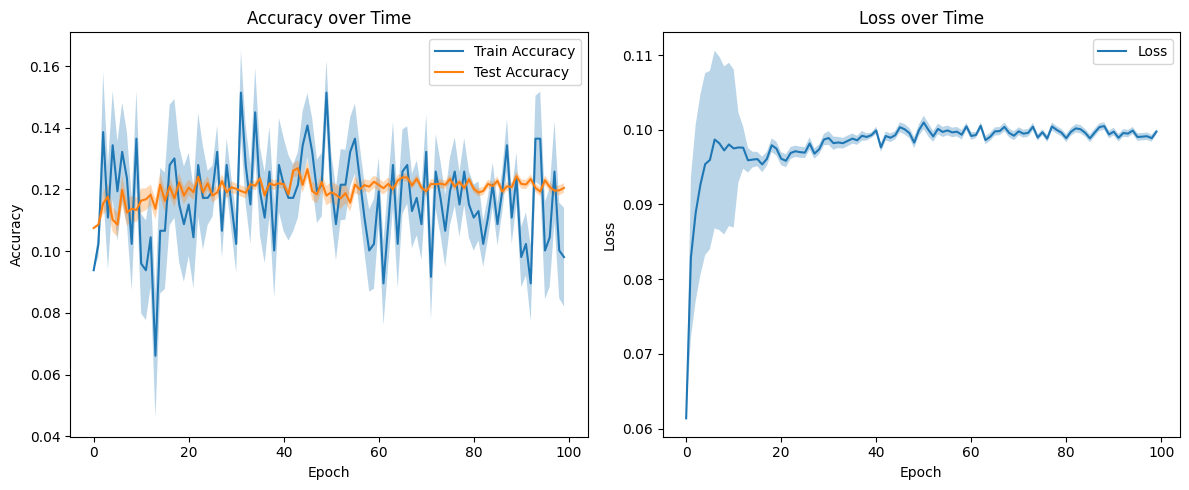

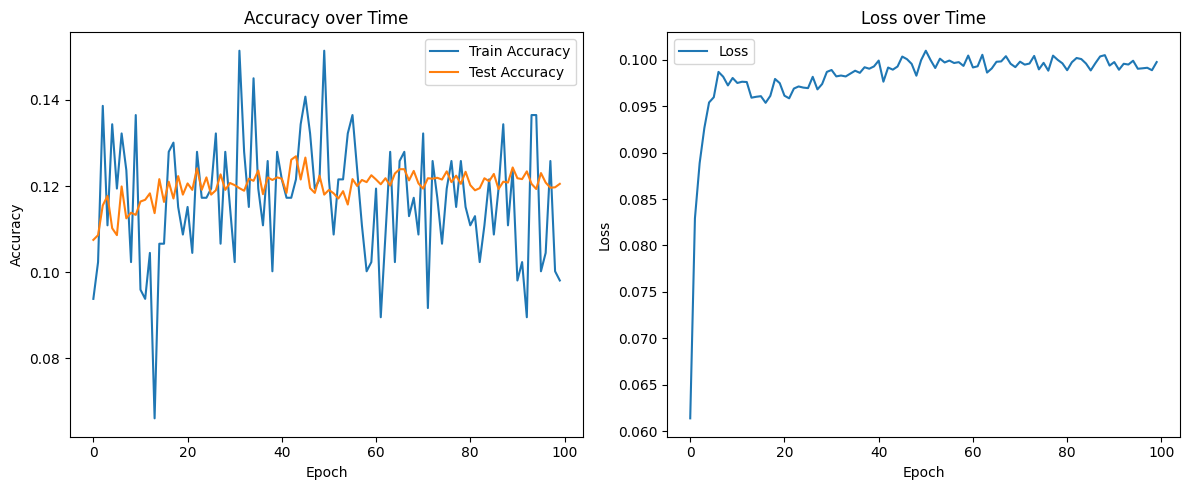

Final Train Accuracy: 0.10 ± 0.02
Final Test Accuracy: 0.12 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1730652890:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.12140564846871758
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1730652890:   1%|          | 1/100 [00:04<07:27,  4.52s/it]

 Test accuracy:  0.107

correct: 48 total: 469
loss: 0.32888054884255313
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730652890:   2%|▏         | 2/100 [00:09<07:40,  4.70s/it]

 Test accuracy:  0.1061

correct: 50 total: 469
loss: 0.263654201889216
 Train accuracy:  0.10660980810234541 | 


MLP_MNIST_0_1730652890:   3%|▎         | 3/100 [00:14<07:45,  4.80s/it]

 Test accuracy:  0.1093

correct: 52 total: 469
loss: 0.17738254938616174
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730652890:   4%|▍         | 4/100 [00:19<07:45,  4.85s/it]

 Test accuracy:  0.116

correct: 58 total: 469
loss: 0.18016167734858832
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730652890:   5%|▌         | 5/100 [00:24<07:42,  4.87s/it]

 Test accuracy:  0.1192

correct: 53 total: 469
loss: 0.15763632570311967
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730652890:   6%|▌         | 6/100 [00:29<07:39,  4.89s/it]

 Test accuracy:  0.1147

correct: 47 total: 469
loss: 0.15435588085003246
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1730652890:   7%|▋         | 7/100 [00:33<07:34,  4.89s/it]

 Test accuracy:  0.114

correct: 47 total: 469
loss: 0.14655647436375302
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1730652890:   8%|▊         | 8/100 [00:38<07:30,  4.89s/it]

 Test accuracy:  0.1207

correct: 48 total: 469
loss: 0.12333454693685462
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730652890:   9%|▉         | 9/100 [00:43<07:25,  4.90s/it]

 Test accuracy:  0.1189

correct: 52 total: 469
loss: 0.11297124795822193
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730652890:  10%|█         | 10/100 [00:48<07:25,  4.95s/it]

 Test accuracy:  0.1182

correct: 66 total: 469
loss: 0.11821730498438959
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1730652890:  11%|█         | 11/100 [00:53<07:21,  4.96s/it]

 Test accuracy:  0.1219

correct: 67 total: 469
loss: 0.105863809379052
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1730652890:  12%|█▏        | 12/100 [00:58<07:17,  4.97s/it]

 Test accuracy:  0.1169

correct: 52 total: 469
loss: 0.10622494736078705
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730652890:  13%|█▎        | 13/100 [01:03<07:11,  4.96s/it]

 Test accuracy:  0.1189

correct: 66 total: 469
loss: 0.1053284438910769
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1730652890:  14%|█▍        | 14/100 [01:08<07:05,  4.95s/it]

 Test accuracy:  0.1198

correct: 58 total: 469
loss: 0.1095472961695972
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730652890:  15%|█▌        | 15/100 [01:13<07:01,  4.96s/it]

 Test accuracy:  0.1245

correct: 52 total: 469
loss: 0.11502954600525818
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730652890:  16%|█▌        | 16/100 [01:18<06:58,  4.98s/it]

 Test accuracy:  0.1209

correct: 61 total: 469
loss: 0.1195335185476966
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1730652890:  17%|█▋        | 17/100 [01:23<06:54,  4.99s/it]

 Test accuracy:  0.1219

correct: 53 total: 469
loss: 0.1312327279782753
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730652890:  18%|█▊        | 18/100 [01:28<06:52,  5.03s/it]

 Test accuracy:  0.1246

correct: 57 total: 469
loss: 0.11807031325821175
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1730652890:  19%|█▉        | 19/100 [01:33<06:46,  5.01s/it]

 Test accuracy:  0.1227

correct: 46 total: 469
loss: 0.12376007491718731
 Train accuracy:  0.09808102345415778 | 


MLP_MNIST_0_1730652890:  20%|██        | 20/100 [01:38<06:40,  5.01s/it]

 Test accuracy:  0.1222

correct: 60 total: 469
loss: 0.11744801393513486
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730652890:  21%|██        | 21/100 [01:43<06:34,  5.00s/it]

 Test accuracy:  0.1193

correct: 52 total: 469
loss: 0.11320142414587647
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730652890:  22%|██▏       | 22/100 [01:48<06:30,  5.01s/it]

 Test accuracy:  0.1285

correct: 46 total: 469
loss: 0.1126584592880979
 Train accuracy:  0.09808102345415778 | 


MLP_MNIST_0_1730652890:  23%|██▎       | 23/100 [01:53<06:23,  4.97s/it]

 Test accuracy:  0.1199

correct: 69 total: 469
loss: 0.12313528443132636
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1730652890:  24%|██▍       | 24/100 [01:58<06:21,  5.02s/it]

 Test accuracy:  0.1181

correct: 53 total: 469
loss: 0.12278636722867169
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730652890:  25%|██▌       | 25/100 [02:03<06:16,  5.02s/it]

 Test accuracy:  0.1202

correct: 44 total: 469
loss: 0.11846363933673545
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1730652890:  26%|██▌       | 26/100 [02:08<06:12,  5.03s/it]

 Test accuracy:  0.1258

correct: 59 total: 469
loss: 0.11373067356503086
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730652890:  27%|██▋       | 27/100 [02:13<06:06,  5.03s/it]

 Test accuracy:  0.1233

correct: 51 total: 469
loss: 0.11378148781147593
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1730652890:  28%|██▊       | 28/100 [02:18<06:03,  5.04s/it]

 Test accuracy:  0.12

correct: 63 total: 469
loss: 0.10868308944170917
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730652890:  29%|██▉       | 29/100 [02:23<05:56,  5.02s/it]

 Test accuracy:  0.1199

correct: 47 total: 469
loss: 0.12697843241411993
 Train accuracy:  0.10021321961620469 | 


MLP_MNIST_0_1730652890:  30%|███       | 30/100 [02:28<05:49,  5.00s/it]

 Test accuracy:  0.1195

correct: 63 total: 469
loss: 0.11819173946881345
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730652890:  31%|███       | 31/100 [02:33<05:46,  5.03s/it]

 Test accuracy:  0.1168

correct: 61 total: 469
loss: 0.11788151834183919
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1730652890:  32%|███▏      | 32/100 [02:38<05:40,  5.01s/it]

 Test accuracy:  0.1218

correct: 66 total: 469
loss: 0.11653410098445949
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1730652890:  33%|███▎      | 33/100 [02:43<05:35,  5.01s/it]

 Test accuracy:  0.1273

correct: 56 total: 469
loss: 0.11792744030512727
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730652890:  34%|███▍      | 34/100 [02:49<05:32,  5.04s/it]

 Test accuracy:  0.1212

correct: 64 total: 469
loss: 0.11657702976833782
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730652890:  35%|███▌      | 35/100 [02:54<05:26,  5.02s/it]

 Test accuracy:  0.122

correct: 58 total: 469
loss: 0.12914158718418212
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730652890:  36%|███▌      | 36/100 [02:59<05:22,  5.03s/it]

 Test accuracy:  0.1259

correct: 49 total: 469
loss: 0.12540094908684302
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1730652890:  37%|███▋      | 37/100 [03:04<05:19,  5.08s/it]

 Test accuracy:  0.1266

correct: 54 total: 469
loss: 0.18077868739488537
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1730652890:  38%|███▊      | 38/100 [03:09<05:17,  5.13s/it]

 Test accuracy:  0.1213

correct: 49 total: 469
loss: 0.12101779399967905
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1730652890:  39%|███▉      | 39/100 [03:14<05:12,  5.13s/it]

 Test accuracy:  0.1299

correct: 55 total: 469
loss: 0.14535226666533363
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730652890:  40%|████      | 40/100 [03:19<05:10,  5.17s/it]

 Test accuracy:  0.1222

correct: 62 total: 469
loss: 0.15208125112852308
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730652890:  41%|████      | 41/100 [03:24<05:02,  5.13s/it]

 Test accuracy:  0.1219

correct: 67 total: 469
loss: 0.13710781930288526
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1730652890:  42%|████▏     | 42/100 [03:30<04:58,  5.14s/it]

 Test accuracy:  0.12

correct: 58 total: 469
loss: 0.1675203278787863
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730652890:  43%|████▎     | 43/100 [03:35<05:00,  5.27s/it]

 Test accuracy:  0.1283

correct: 58 total: 469
loss: 0.1432147631481258
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730652890:  44%|████▍     | 44/100 [03:40<04:53,  5.25s/it]

 Test accuracy:  0.1215

correct: 62 total: 469
loss: 0.16933938238158155
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730652890:  45%|████▌     | 45/100 [03:46<04:50,  5.28s/it]

 Test accuracy:  0.1218

correct: 52 total: 469
loss: 0.1542982491158219
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730652890:  46%|████▌     | 46/100 [03:51<04:49,  5.36s/it]

 Test accuracy:  0.1282

correct: 70 total: 469
loss: 0.16647754217198155
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1730652890:  47%|████▋     | 47/100 [03:57<04:47,  5.42s/it]

 Test accuracy:  0.1222

correct: 58 total: 469
loss: 0.1524845206978987
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730652890:  48%|████▊     | 48/100 [04:03<04:48,  5.54s/it]

 Test accuracy:  0.1194

correct: 60 total: 469
loss: 0.1598003470440155
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730652890:  49%|████▉     | 49/100 [04:09<04:56,  5.81s/it]

 Test accuracy:  0.1241

correct: 62 total: 469
loss: 0.15781338638397677
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730652890:  50%|█████     | 50/100 [04:15<04:51,  5.83s/it]

 Test accuracy:  0.1196

correct: 60 total: 469
loss: 0.13932508670254304
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730652890:  51%|█████     | 51/100 [04:21<04:50,  5.92s/it]

 Test accuracy:  0.122

correct: 54 total: 469
loss: 0.1451306399315405
 Train accuracy:  0.11513859275053305 | 


MLP_MNIST_0_1730652890:  52%|█████▏    | 52/100 [04:27<04:42,  5.88s/it]

 Test accuracy:  0.1238

correct: 40 total: 469
loss: 0.15536924186291726
 Train accuracy:  0.08528784648187633 | 


MLP_MNIST_0_1730652890:  53%|█████▎    | 53/100 [04:32<04:31,  5.79s/it]

 Test accuracy:  0.117

correct: 65 total: 469
loss: 0.15904611847929354
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1730652890:  54%|█████▍    | 54/100 [04:38<04:25,  5.77s/it]

 Test accuracy:  0.1168

correct: 69 total: 469
loss: 0.1398207830753662
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1730652890:  55%|█████▌    | 55/100 [04:44<04:25,  5.89s/it]

 Test accuracy:  0.1225

correct: 70 total: 469
loss: 0.16833633850060548
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1730652890:  56%|█████▌    | 56/100 [04:50<04:18,  5.87s/it]

 Test accuracy:  0.1219

correct: 62 total: 469
loss: 0.17620768819028126
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730652890:  57%|█████▋    | 57/100 [04:56<04:07,  5.77s/it]

 Test accuracy:  0.1264

correct: 58 total: 469
loss: 0.14580445460228522
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730652890:  58%|█████▊    | 58/100 [05:02<04:02,  5.78s/it]

 Test accuracy:  0.1255

correct: 59 total: 469
loss: 0.1397910542897324
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730652890:  59%|█████▉    | 59/100 [05:07<03:53,  5.70s/it]

 Test accuracy:  0.1212

correct: 49 total: 469
loss: 0.16262353376856745
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1730652890:  60%|██████    | 60/100 [05:13<03:49,  5.74s/it]

 Test accuracy:  0.1238

correct: 48 total: 469
loss: 0.15421823420122996
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730652890:  61%|██████    | 61/100 [05:18<03:42,  5.70s/it]

 Test accuracy:  0.1261

correct: 49 total: 469
loss: 0.16615933308532752
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1730652890:  62%|██████▏   | 62/100 [05:24<03:33,  5.62s/it]

 Test accuracy:  0.1246

correct: 52 total: 469
loss: 0.1615688027953034
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730652890:  63%|██████▎   | 63/100 [05:29<03:25,  5.56s/it]

 Test accuracy:  0.1252

correct: 63 total: 469
loss: 0.1468200589071459
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730652890:  64%|██████▍   | 64/100 [05:35<03:18,  5.52s/it]

 Test accuracy:  0.1253

correct: 68 total: 469
loss: 0.17054166223829997
 Train accuracy:  0.14498933901918976 | 


MLP_MNIST_0_1730652890:  65%|██████▌   | 65/100 [05:40<03:13,  5.53s/it]

 Test accuracy:  0.1215

correct: 63 total: 469
loss: 0.14603821812535145
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730652890:  66%|██████▌   | 66/100 [05:46<03:06,  5.49s/it]

 Test accuracy:  0.1241

correct: 45 total: 469
loss: 0.16299769247391585
 Train accuracy:  0.09594882729211088 | 


MLP_MNIST_0_1730652890:  67%|██████▋   | 67/100 [05:51<03:00,  5.48s/it]

 Test accuracy:  0.1183

correct: 45 total: 469
loss: 0.18372041309502588
 Train accuracy:  0.09594882729211088 | 


MLP_MNIST_0_1730652890:  68%|██████▊   | 68/100 [05:57<02:56,  5.51s/it]

 Test accuracy:  0.1248

correct: 53 total: 469
loss: 0.14899675123917777
 Train accuracy:  0.11300639658848614 | 


MLP_MNIST_0_1730652890:  69%|██████▉   | 69/100 [06:02<02:50,  5.51s/it]

 Test accuracy:  0.1202

correct: 49 total: 469
loss: 0.18372294616534005
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1730652890:  70%|███████   | 70/100 [06:08<02:45,  5.52s/it]

 Test accuracy:  0.1211

correct: 62 total: 469
loss: 0.14863131471724908
 Train accuracy:  0.13219616204690832 | 


MLP_MNIST_0_1730652890:  71%|███████   | 71/100 [06:14<02:44,  5.69s/it]

 Test accuracy:  0.1223

correct: 63 total: 469
loss: 0.16886276348249746
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730652890:  72%|███████▏  | 72/100 [06:19<02:37,  5.64s/it]

 Test accuracy:  0.117

correct: 55 total: 469
loss: 0.17563939162853684
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730652890:  73%|███████▎  | 73/100 [06:25<02:31,  5.60s/it]

 Test accuracy:  0.1201

correct: 56 total: 469
loss: 0.16548579475328104
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730652890:  74%|███████▍  | 74/100 [06:30<02:24,  5.55s/it]

 Test accuracy:  0.1213

correct: 51 total: 469
loss: 0.15127968097101652
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1730652890:  75%|███████▌  | 75/100 [06:36<02:17,  5.49s/it]

 Test accuracy:  0.1191

correct: 61 total: 469
loss: 0.1393181456685829
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1730652890:  76%|███████▌  | 76/100 [06:41<02:11,  5.49s/it]

 Test accuracy:  0.1271

correct: 66 total: 469
loss: 0.14654317012092452
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1730652890:  77%|███████▋  | 77/100 [06:47<02:08,  5.61s/it]

 Test accuracy:  0.1236

correct: 59 total: 469
loss: 0.17132513207603872
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730652890:  78%|███████▊  | 78/100 [06:53<02:03,  5.62s/it]

 Test accuracy:  0.1213

correct: 64 total: 469
loss: 0.15619076977470028
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730652890:  79%|███████▉  | 79/100 [06:59<01:59,  5.71s/it]

 Test accuracy:  0.1271

correct: 51 total: 469
loss: 0.16116129597430545
 Train accuracy:  0.10874200426439233 | 


MLP_MNIST_0_1730652890:  80%|████████  | 80/100 [07:04<01:54,  5.72s/it]

 Test accuracy:  0.121

correct: 48 total: 469
loss: 0.16083871306323294
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730652890:  81%|████████  | 81/100 [07:10<01:48,  5.69s/it]

 Test accuracy:  0.1267

correct: 74 total: 469
loss: 0.1735558633102791
 Train accuracy:  0.15778251599147122 | 


MLP_MNIST_0_1730652890:  82%|████████▏ | 82/100 [07:16<01:42,  5.69s/it]

 Test accuracy:  0.1202

correct: 57 total: 469
loss: 0.13115586681978536
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1730652890:  83%|████████▎ | 83/100 [07:21<01:36,  5.65s/it]

 Test accuracy:  0.1195

correct: 55 total: 469
loss: 0.16388038374277067
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730652890:  84%|████████▍ | 84/100 [07:27<01:30,  5.65s/it]

 Test accuracy:  0.1233

correct: 52 total: 469
loss: 0.16254343650043646
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730652890:  85%|████████▌ | 85/100 [07:32<01:24,  5.62s/it]

 Test accuracy:  0.1238

correct: 52 total: 469
loss: 0.16141121291211927
 Train accuracy:  0.11087420042643924 | 


MLP_MNIST_0_1730652890:  86%|████████▌ | 86/100 [07:38<01:18,  5.60s/it]

 Test accuracy:  0.1231

correct: 70 total: 469
loss: 0.1400991237080936
 Train accuracy:  0.14925373134328357 | 


MLP_MNIST_0_1730652890:  87%|████████▋ | 87/100 [07:44<01:12,  5.57s/it]

 Test accuracy:  0.1232

correct: 57 total: 469
loss: 0.16258392718110257
 Train accuracy:  0.12153518123667377 | 


MLP_MNIST_0_1730652890:  88%|████████▊ | 88/100 [07:49<01:07,  5.65s/it]

 Test accuracy:  0.1164

correct: 58 total: 469
loss: 0.15827000998993163
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730652890:  89%|████████▉ | 89/100 [07:55<01:01,  5.59s/it]

 Test accuracy:  0.1249

correct: 59 total: 469
loss: 0.14185570730075145
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730652890:  90%|█████████ | 90/100 [08:00<00:55,  5.57s/it]

 Test accuracy:  0.1244

correct: 63 total: 469
loss: 0.14750272605909723
 Train accuracy:  0.13432835820895522 | 


MLP_MNIST_0_1730652890:  91%|█████████ | 91/100 [08:06<00:50,  5.58s/it]

 Test accuracy:  0.1202

correct: 56 total: 469
loss: 0.18037901852113097
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730652890:  92%|█████████▏| 92/100 [08:12<00:44,  5.60s/it]

 Test accuracy:  0.1208

correct: 49 total: 469
loss: 0.13022339234410574
 Train accuracy:  0.1044776119402985 | 


MLP_MNIST_0_1730652890:  93%|█████████▎| 93/100 [08:17<00:39,  5.64s/it]

 Test accuracy:  0.1217

correct: 56 total: 469
loss: 0.1564146802941365
 Train accuracy:  0.11940298507462686 | 


MLP_MNIST_0_1730652890:  94%|█████████▍| 94/100 [08:23<00:34,  5.68s/it]

 Test accuracy:  0.1233

correct: 59 total: 469
loss: 0.14189834670344395
 Train accuracy:  0.1257995735607676 | 


MLP_MNIST_0_1730652890:  95%|█████████▌| 95/100 [08:29<00:28,  5.66s/it]

 Test accuracy:  0.1294

correct: 65 total: 469
loss: 0.15351766347885132
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1730652890:  96%|█████████▌| 96/100 [08:34<00:22,  5.64s/it]

 Test accuracy:  0.1203

correct: 58 total: 469
loss: 0.1692134729548812
 Train accuracy:  0.12366737739872068 | 


MLP_MNIST_0_1730652890:  97%|█████████▋| 97/100 [08:40<00:16,  5.62s/it]

 Test accuracy:  0.1185

correct: 61 total: 469
loss: 0.1449292422707147
 Train accuracy:  0.1300639658848614 | 


MLP_MNIST_0_1730652890:  98%|█████████▊| 98/100 [08:45<00:11,  5.58s/it]

 Test accuracy:  0.1179

correct: 66 total: 469
loss: 0.1493100949060688
 Train accuracy:  0.14072494669509594 | 


MLP_MNIST_0_1730652890:  99%|█████████▉| 99/100 [08:51<00:05,  5.61s/it]

 Test accuracy:  0.1202

correct: 55 total: 469
loss: 0.15939399986061206
 Train accuracy:  0.11727078891257996 | 


MLP_MNIST_0_1730652890: 100%|██████████| 100/100 [08:57<00:00,  5.37s/it]

 Test accuracy:  0.121


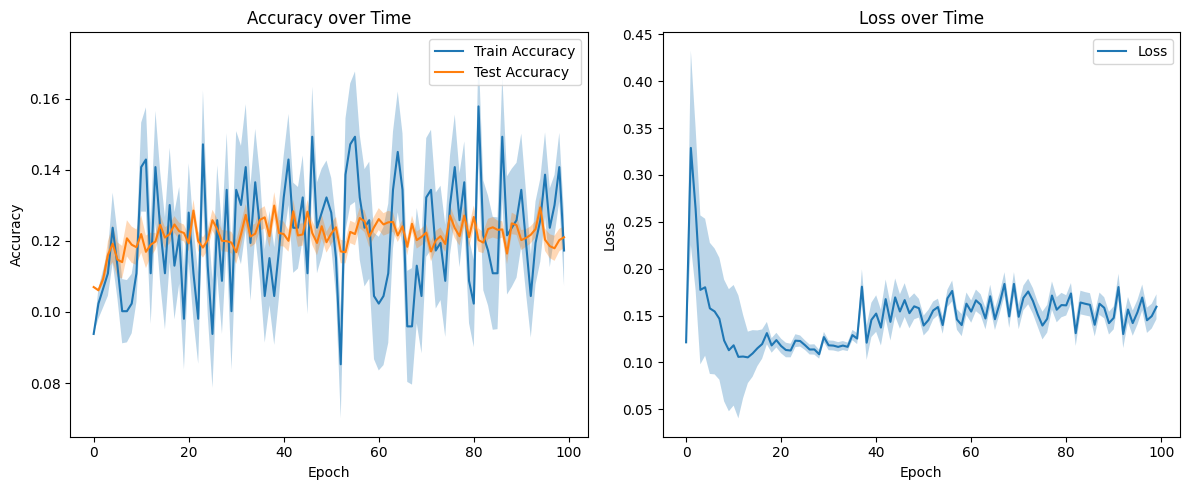

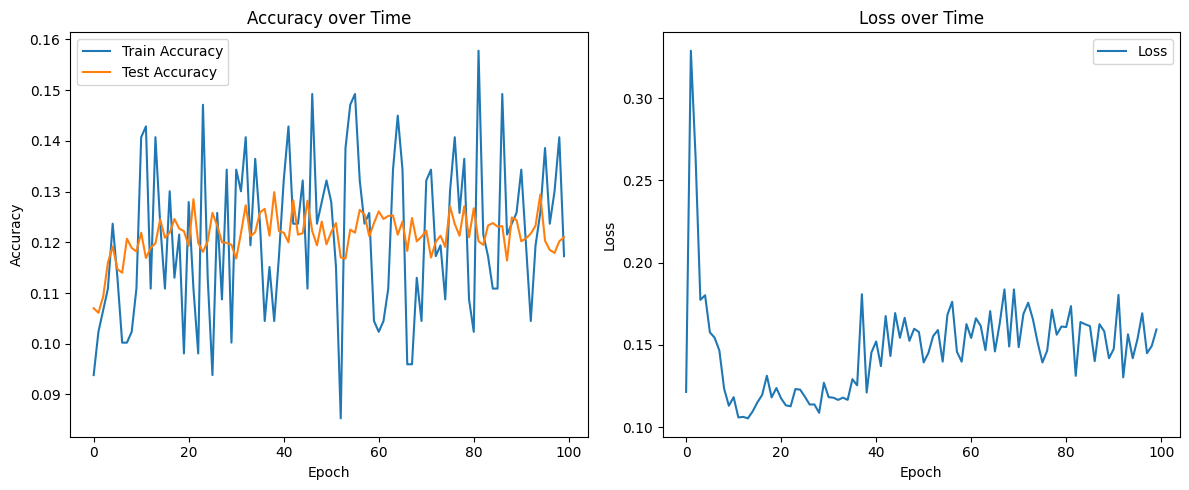

Final Train Accuracy: 0.12 ± 0.01
Final Test Accuracy: 0.12 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1730653430:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.046023128002183014
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1730653430:   1%|          | 1/100 [00:04<07:44,  4.70s/it]

 Test accuracy:  0.1103

correct: 48 total: 469
loss: 0.059829182271510045
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730653430:   2%|▏         | 2/100 [00:10<08:15,  5.05s/it]

 Test accuracy:  0.112

correct: 60 total: 469
loss: 0.06682668973419711
 Train accuracy:  0.1279317697228145 | 


MLP_MNIST_0_1730653430:   3%|▎         | 3/100 [00:14<08:04,  5.00s/it]

 Test accuracy:  0.1334

correct: 64 total: 469
loss: 0.07129264005751752
 Train accuracy:  0.13646055437100213 | 


MLP_MNIST_0_1730653430:   4%|▍         | 4/100 [00:19<08:00,  5.00s/it]

 Test accuracy:  0.1413

correct: 75 total: 469
loss: 0.07442266826055197
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1730653430:   5%|▌         | 5/100 [00:25<07:57,  5.03s/it]

 Test accuracy:  0.1525

correct: 65 total: 469
loss: 0.0778373080625463
 Train accuracy:  0.13859275053304904 | 


MLP_MNIST_0_1730653430:   6%|▌         | 6/100 [00:30<07:52,  5.03s/it]

 Test accuracy:  0.16

correct: 68 total: 469
loss: 0.08093798440148327
 Train accuracy:  0.14498933901918976 | 


MLP_MNIST_0_1730653430:   7%|▋         | 7/100 [00:35<07:47,  5.02s/it]

 Test accuracy:  0.1631

correct: 76 total: 469
loss: 0.08246895357934651
 Train accuracy:  0.16204690831556504 | 


MLP_MNIST_0_1730653430:   8%|▊         | 8/100 [00:40<07:41,  5.02s/it]

 Test accuracy:  0.1609

correct: 92 total: 469
loss: 0.08655927382679636
 Train accuracy:  0.19616204690831557 | 


MLP_MNIST_0_1730653430:   9%|▉         | 9/100 [00:45<07:38,  5.04s/it]

 Test accuracy:  0.167

correct: 84 total: 469
loss: 0.08841939046502367
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1730653430:  10%|█         | 10/100 [00:50<07:40,  5.12s/it]

 Test accuracy:  0.167

correct: 83 total: 469
loss: 0.09003662546751087
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1730653430:  11%|█         | 11/100 [00:55<07:33,  5.09s/it]

 Test accuracy:  0.1736

correct: 81 total: 469
loss: 0.09169048186876118
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1730653430:  12%|█▏        | 12/100 [01:00<07:22,  5.03s/it]

 Test accuracy:  0.1732

correct: 82 total: 469
loss: 0.09395867422509041
 Train accuracy:  0.17484008528784648 | 


MLP_MNIST_0_1730653430:  13%|█▎        | 13/100 [01:05<07:18,  5.04s/it]

 Test accuracy:  0.1686

correct: 78 total: 469
loss: 0.09580296179506062
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1730653430:  14%|█▍        | 14/100 [01:10<07:15,  5.06s/it]

 Test accuracy:  0.1789

correct: 71 total: 469
loss: 0.09610688867472382
 Train accuracy:  0.1513859275053305 | 


MLP_MNIST_0_1730653430:  15%|█▌        | 15/100 [01:15<07:12,  5.09s/it]

 Test accuracy:  0.1787

correct: 80 total: 469
loss: 0.0966766465828617
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1730653430:  16%|█▌        | 16/100 [01:20<07:09,  5.11s/it]

 Test accuracy:  0.1821

correct: 86 total: 469
loss: 0.09875099570639352
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1730653430:  17%|█▋        | 17/100 [01:25<07:04,  5.11s/it]

 Test accuracy:  0.1813

correct: 75 total: 469
loss: 0.09891544190296994
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1730653430:  18%|█▊        | 18/100 [01:31<06:59,  5.11s/it]

 Test accuracy:  0.1862

correct: 103 total: 469
loss: 0.10119619017153152
 Train accuracy:  0.21961620469083157 | 


MLP_MNIST_0_1730653430:  19%|█▉        | 19/100 [01:36<06:50,  5.07s/it]

 Test accuracy:  0.1823

correct: 73 total: 469
loss: 0.1018489433853611
 Train accuracy:  0.15565031982942432 | 


MLP_MNIST_0_1730653430:  20%|██        | 20/100 [01:41<06:42,  5.04s/it]

 Test accuracy:  0.177

correct: 101 total: 469
loss: 0.10247068196090299
 Train accuracy:  0.21535181236673773 | 


MLP_MNIST_0_1730653430:  21%|██        | 21/100 [01:46<06:37,  5.03s/it]

 Test accuracy:  0.1922

correct: 93 total: 469
loss: 0.10314681188765365
 Train accuracy:  0.19829424307036247 | 


MLP_MNIST_0_1730653430:  22%|██▏       | 22/100 [01:51<06:34,  5.06s/it]

 Test accuracy:  0.1859

correct: 87 total: 469
loss: 0.10435022812471716
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1730653430:  23%|██▎       | 23/100 [01:56<06:31,  5.09s/it]

 Test accuracy:  0.1827

correct: 77 total: 469
loss: 0.1052253935764085
 Train accuracy:  0.16417910447761194 | 


MLP_MNIST_0_1730653430:  24%|██▍       | 24/100 [02:01<06:28,  5.11s/it]

 Test accuracy:  0.1904

correct: 81 total: 469
loss: 0.10552282650460566
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1730653430:  25%|██▌       | 25/100 [02:06<06:23,  5.12s/it]

 Test accuracy:  0.1918

correct: 95 total: 469
loss: 0.10623054268327095
 Train accuracy:  0.2025586353944563 | 


MLP_MNIST_0_1730653430:  26%|██▌       | 26/100 [02:11<06:18,  5.12s/it]

 Test accuracy:  0.1879

correct: 69 total: 469
loss: 0.10612761534289765
 Train accuracy:  0.14712153518123666 | 


MLP_MNIST_0_1730653430:  27%|██▋       | 27/100 [02:16<06:12,  5.10s/it]

 Test accuracy:  0.185

correct: 106 total: 469
loss: 0.10768077582883429
 Train accuracy:  0.2260127931769723 | 


MLP_MNIST_0_1730653430:  28%|██▊       | 28/100 [02:22<06:10,  5.15s/it]

 Test accuracy:  0.1863

correct: 75 total: 469
loss: 0.10800775293030464
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1730653430:  29%|██▉       | 29/100 [02:27<06:06,  5.16s/it]

 Test accuracy:  0.1819

correct: 86 total: 469
loss: 0.10867342352867126
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1730653430:  30%|███       | 30/100 [02:32<06:07,  5.25s/it]

 Test accuracy:  0.1876

correct: 94 total: 469
loss: 0.10949130961572183
 Train accuracy:  0.20042643923240938 | 


MLP_MNIST_0_1730653430:  31%|███       | 31/100 [02:37<05:59,  5.21s/it]

 Test accuracy:  0.1836

correct: 84 total: 469
loss: 0.1095262701227975
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1730653430:  32%|███▏      | 32/100 [02:43<05:54,  5.21s/it]

 Test accuracy:  0.1855

correct: 78 total: 469
loss: 0.1102441734850788
 Train accuracy:  0.16631130063965885 | 


MLP_MNIST_0_1730653430:  33%|███▎      | 33/100 [02:48<05:47,  5.19s/it]

 Test accuracy:  0.183

correct: 83 total: 469
loss: 0.10962081066708067
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1730653430:  34%|███▍      | 34/100 [02:53<05:42,  5.19s/it]

 Test accuracy:  0.1835

correct: 91 total: 469
loss: 0.11004078887037631
 Train accuracy:  0.19402985074626866 | 


MLP_MNIST_0_1730653430:  35%|███▌      | 35/100 [02:58<05:37,  5.19s/it]

 Test accuracy:  0.1822

correct: 81 total: 469
loss: 0.11028943963841334
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1730653430:  36%|███▌      | 36/100 [03:04<05:38,  5.28s/it]

 Test accuracy:  0.1795

correct: 92 total: 469
loss: 0.11096010090255026
 Train accuracy:  0.19616204690831557 | 


MLP_MNIST_0_1730653430:  37%|███▋      | 37/100 [03:09<05:33,  5.29s/it]

 Test accuracy:  0.1841

correct: 77 total: 469
loss: 0.1110078945978364
 Train accuracy:  0.16417910447761194 | 


MLP_MNIST_0_1730653430:  38%|███▊      | 38/100 [03:14<05:28,  5.30s/it]

 Test accuracy:  0.182

correct: 94 total: 469
loss: 0.11117659933340829
 Train accuracy:  0.20042643923240938 | 


MLP_MNIST_0_1730653430:  39%|███▉      | 39/100 [03:19<05:21,  5.28s/it]

 Test accuracy:  0.1833

correct: 90 total: 469
loss: 0.11170523017962604
 Train accuracy:  0.19189765458422176 | 


MLP_MNIST_0_1730653430:  40%|████      | 40/100 [03:25<05:14,  5.24s/it]

 Test accuracy:  0.1795

correct: 82 total: 469
loss: 0.1119800739165054
 Train accuracy:  0.17484008528784648 | 


MLP_MNIST_0_1730653430:  41%|████      | 41/100 [03:30<05:06,  5.19s/it]

 Test accuracy:  0.1812

correct: 97 total: 469
loss: 0.11214230991185092
 Train accuracy:  0.2068230277185501 | 


MLP_MNIST_0_1730653430:  42%|████▏     | 42/100 [03:35<05:02,  5.21s/it]

 Test accuracy:  0.1894

correct: 85 total: 469
loss: 0.11264393426207846
 Train accuracy:  0.1812366737739872 | 


MLP_MNIST_0_1730653430:  43%|████▎     | 43/100 [03:40<04:57,  5.23s/it]

 Test accuracy:  0.1832

correct: 87 total: 469
loss: 0.11254620289942349
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1730653430:  44%|████▍     | 44/100 [03:45<04:51,  5.21s/it]

 Test accuracy:  0.1831

correct: 93 total: 469
loss: 0.11340498056874346
 Train accuracy:  0.19829424307036247 | 


MLP_MNIST_0_1730653430:  45%|████▌     | 45/100 [03:51<04:47,  5.24s/it]

 Test accuracy:  0.1914

correct: 85 total: 469
loss: 0.11317223896667647
 Train accuracy:  0.1812366737739872 | 


MLP_MNIST_0_1730653430:  46%|████▌     | 46/100 [03:56<04:42,  5.23s/it]

 Test accuracy:  0.181

correct: 88 total: 469
loss: 0.1138399622238267
 Train accuracy:  0.18763326226012794 | 


MLP_MNIST_0_1730653430:  47%|████▋     | 47/100 [04:01<04:36,  5.22s/it]

 Test accuracy:  0.1888

correct: 97 total: 469
loss: 0.11334709951808966
 Train accuracy:  0.2068230277185501 | 


MLP_MNIST_0_1730653430:  48%|████▊     | 48/100 [04:07<04:35,  5.30s/it]

 Test accuracy:  0.183

correct: 73 total: 469
loss: 0.11353347560108852
 Train accuracy:  0.15565031982942432 | 


MLP_MNIST_0_1730653430:  49%|████▉     | 49/100 [04:12<04:30,  5.30s/it]

 Test accuracy:  0.188

correct: 86 total: 469
loss: 0.11413819714586364
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1730653430:  50%|█████     | 50/100 [04:17<04:24,  5.29s/it]

 Test accuracy:  0.1861

correct: 83 total: 469
loss: 0.11457540128213256
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1730653430:  51%|█████     | 51/100 [04:22<04:20,  5.31s/it]

 Test accuracy:  0.1854

correct: 88 total: 469
loss: 0.11433510375874383
 Train accuracy:  0.18763326226012794 | 


MLP_MNIST_0_1730653430:  52%|█████▏    | 52/100 [04:28<04:15,  5.33s/it]

 Test accuracy:  0.1799

correct: 99 total: 469
loss: 0.11519065421463838
 Train accuracy:  0.21108742004264391 | 


MLP_MNIST_0_1730653430:  53%|█████▎    | 53/100 [04:33<04:10,  5.33s/it]

 Test accuracy:  0.1865

correct: 91 total: 469
loss: 0.1151411160985544
 Train accuracy:  0.19402985074626866 | 


MLP_MNIST_0_1730653430:  54%|█████▍    | 54/100 [04:39<04:08,  5.39s/it]

 Test accuracy:  0.1903

correct: 79 total: 469
loss: 0.11464628887011298
 Train accuracy:  0.16844349680170576 | 


MLP_MNIST_0_1730653430:  55%|█████▌    | 55/100 [04:44<04:01,  5.36s/it]

 Test accuracy:  0.1863

correct: 87 total: 469
loss: 0.11509768224791932
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1730653430:  56%|█████▌    | 56/100 [04:49<03:56,  5.37s/it]

 Test accuracy:  0.1881

correct: 79 total: 469
loss: 0.11515093809251846
 Train accuracy:  0.16844349680170576 | 


MLP_MNIST_0_1730653430:  57%|█████▋    | 57/100 [04:55<03:54,  5.46s/it]

 Test accuracy:  0.1861

correct: 105 total: 469
loss: 0.1154347503585602
 Train accuracy:  0.22388059701492538 | 


MLP_MNIST_0_1730653430:  58%|█████▊    | 58/100 [05:00<03:47,  5.42s/it]

 Test accuracy:  0.1835

correct: 92 total: 469
loss: 0.11545356904774078
 Train accuracy:  0.19616204690831557 | 


MLP_MNIST_0_1730653430:  59%|█████▉    | 59/100 [05:06<03:41,  5.40s/it]

 Test accuracy:  0.1829

correct: 84 total: 469
loss: 0.11503059490085411
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1730653430:  60%|██████    | 60/100 [05:11<03:39,  5.49s/it]

 Test accuracy:  0.1873

correct: 83 total: 469
loss: 0.11483577449819934
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1730653430:  61%|██████    | 61/100 [05:17<03:33,  5.46s/it]

 Test accuracy:  0.1877

correct: 88 total: 469
loss: 0.1156413867624838
 Train accuracy:  0.18763326226012794 | 


MLP_MNIST_0_1730653430:  62%|██████▏   | 62/100 [05:22<03:27,  5.45s/it]

 Test accuracy:  0.1914

correct: 85 total: 469
loss: 0.11590700142228527
 Train accuracy:  0.1812366737739872 | 


MLP_MNIST_0_1730653430:  63%|██████▎   | 63/100 [05:28<03:19,  5.40s/it]

 Test accuracy:  0.1833

correct: 91 total: 469
loss: 0.11631225640458592
 Train accuracy:  0.19402985074626866 | 


MLP_MNIST_0_1730653430:  64%|██████▍   | 64/100 [05:33<03:13,  5.37s/it]

 Test accuracy:  0.1809

correct: 93 total: 469
loss: 0.11624085220065453
 Train accuracy:  0.19829424307036247 | 


MLP_MNIST_0_1730653430:  65%|██████▌   | 65/100 [05:38<03:07,  5.35s/it]

 Test accuracy:  0.1867

correct: 87 total: 469
loss: 0.11727078471864973
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1730653430:  66%|██████▌   | 66/100 [05:44<03:02,  5.36s/it]

 Test accuracy:  0.1835

correct: 112 total: 469
loss: 0.1171181902829518
 Train accuracy:  0.23880597014925373 | 


MLP_MNIST_0_1730653430:  67%|██████▋   | 67/100 [05:49<02:58,  5.41s/it]

 Test accuracy:  0.1891

correct: 94 total: 469
loss: 0.11765509575351214
 Train accuracy:  0.20042643923240938 | 


MLP_MNIST_0_1730653430:  68%|██████▊   | 68/100 [05:54<02:53,  5.41s/it]

 Test accuracy:  0.1886

correct: 72 total: 469
loss: 0.1166641507893483
 Train accuracy:  0.1535181236673774 | 


MLP_MNIST_0_1730653430:  69%|██████▉   | 69/100 [06:00<02:47,  5.41s/it]

 Test accuracy:  0.1871

correct: 88 total: 469
loss: 0.11627425966677127
 Train accuracy:  0.18763326226012794 | 


MLP_MNIST_0_1730653430:  70%|███████   | 70/100 [06:05<02:42,  5.43s/it]

 Test accuracy:  0.1855

correct: 80 total: 469
loss: 0.11590457748947368
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1730653430:  71%|███████   | 71/100 [06:11<02:39,  5.49s/it]

 Test accuracy:  0.1766

correct: 102 total: 469
loss: 0.11721490410917094
 Train accuracy:  0.21748400852878466 | 


MLP_MNIST_0_1730653430:  72%|███████▏  | 72/100 [06:17<02:35,  5.55s/it]

 Test accuracy:  0.1835

correct: 89 total: 469
loss: 0.11731586406734199
 Train accuracy:  0.18976545842217485 | 


MLP_MNIST_0_1730653430:  73%|███████▎  | 73/100 [06:22<02:29,  5.54s/it]

 Test accuracy:  0.1854

correct: 84 total: 469
loss: 0.11764013422514076
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1730653430:  74%|███████▍  | 74/100 [06:28<02:22,  5.49s/it]

 Test accuracy:  0.184

correct: 87 total: 469
loss: 0.11791627277443403
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1730653430:  75%|███████▌  | 75/100 [06:33<02:16,  5.47s/it]

 Test accuracy:  0.1901

correct: 86 total: 469
loss: 0.1178096095636201
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1730653430:  76%|███████▌  | 76/100 [06:38<02:11,  5.47s/it]

 Test accuracy:  0.1854

correct: 86 total: 469
loss: 0.11727421220812971
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1730653430:  77%|███████▋  | 77/100 [06:44<02:05,  5.47s/it]

 Test accuracy:  0.1901

correct: 86 total: 469
loss: 0.11780837715180444
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1730653430:  78%|███████▊  | 78/100 [06:50<02:01,  5.52s/it]

 Test accuracy:  0.1862

correct: 87 total: 469
loss: 0.11803583942178979
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1730653430:  79%|███████▉  | 79/100 [06:55<01:55,  5.51s/it]

 Test accuracy:  0.1853

correct: 80 total: 469
loss: 0.11774114031654431
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1730653430:  80%|████████  | 80/100 [07:01<01:50,  5.50s/it]

 Test accuracy:  0.1832

correct: 83 total: 469
loss: 0.1183170831438575
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1730653430:  81%|████████  | 81/100 [07:06<01:43,  5.47s/it]

 Test accuracy:  0.1858

correct: 91 total: 469
loss: 0.11807563359231583
 Train accuracy:  0.19402985074626866 | 


MLP_MNIST_0_1730653430:  82%|████████▏ | 82/100 [07:11<01:38,  5.50s/it]

 Test accuracy:  0.1869

correct: 83 total: 469
loss: 0.11763221228808991
 Train accuracy:  0.17697228144989338 | 


MLP_MNIST_0_1730653430:  83%|████████▎ | 83/100 [07:17<01:33,  5.52s/it]

 Test accuracy:  0.1816

correct: 80 total: 469
loss: 0.11778377085479337
 Train accuracy:  0.17057569296375266 | 


MLP_MNIST_0_1730653430:  84%|████████▍ | 84/100 [07:23<01:28,  5.52s/it]

 Test accuracy:  0.185

correct: 92 total: 469
loss: 0.11759759150524891
 Train accuracy:  0.19616204690831557 | 


MLP_MNIST_0_1730653430:  85%|████████▌ | 85/100 [07:28<01:22,  5.53s/it]

 Test accuracy:  0.1826

correct: 94 total: 469
loss: 0.11876088272788123
 Train accuracy:  0.20042643923240938 | 


MLP_MNIST_0_1730653430:  86%|████████▌ | 86/100 [07:34<01:17,  5.54s/it]

 Test accuracy:  0.1915

correct: 84 total: 469
loss: 0.11782946968192994
 Train accuracy:  0.1791044776119403 | 


MLP_MNIST_0_1730653430:  87%|████████▋ | 87/100 [07:39<01:12,  5.54s/it]

 Test accuracy:  0.1891

correct: 91 total: 469
loss: 0.11933467044695609
 Train accuracy:  0.19402985074626866 | 


MLP_MNIST_0_1730653430:  88%|████████▊ | 88/100 [07:45<01:07,  5.59s/it]

 Test accuracy:  0.1869

correct: 114 total: 469
loss: 0.11822252069264333
 Train accuracy:  0.24307036247334754 | 


MLP_MNIST_0_1730653430:  89%|████████▉ | 89/100 [07:51<01:01,  5.62s/it]

 Test accuracy:  0.1833

correct: 88 total: 469
loss: 0.11873774873867218
 Train accuracy:  0.18763326226012794 | 


MLP_MNIST_0_1730653430:  90%|█████████ | 90/100 [07:56<00:55,  5.58s/it]

 Test accuracy:  0.1859

correct: 87 total: 469
loss: 0.11851148347038704
 Train accuracy:  0.18550106609808104 | 


MLP_MNIST_0_1730653430:  91%|█████████ | 91/100 [08:02<00:50,  5.59s/it]

 Test accuracy:  0.1909

correct: 86 total: 469
loss: 0.11861916274022954
 Train accuracy:  0.18336886993603413 | 


MLP_MNIST_0_1730653430:  92%|█████████▏| 92/100 [08:07<00:44,  5.59s/it]

 Test accuracy:  0.1895

correct: 67 total: 469
loss: 0.11918565236937517
 Train accuracy:  0.14285714285714285 | 


MLP_MNIST_0_1730653430:  93%|█████████▎| 93/100 [08:13<00:39,  5.64s/it]

 Test accuracy:  0.1863

correct: 93 total: 469
loss: 0.11853920280742747
 Train accuracy:  0.19829424307036247 | 


MLP_MNIST_0_1730653430:  94%|█████████▍| 94/100 [08:19<00:34,  5.70s/it]

 Test accuracy:  0.186

correct: 88 total: 469
loss: 0.11926695372440668
 Train accuracy:  0.18763326226012794 | 


MLP_MNIST_0_1730653430:  95%|█████████▌| 95/100 [08:24<00:28,  5.64s/it]

 Test accuracy:  0.1836

correct: 81 total: 469
loss: 0.11875061058540588
 Train accuracy:  0.17270788912579957 | 


MLP_MNIST_0_1730653430:  96%|█████████▌| 96/100 [08:30<00:22,  5.63s/it]

 Test accuracy:  0.1869

correct: 82 total: 469
loss: 0.11872261737201259
 Train accuracy:  0.17484008528784648 | 


MLP_MNIST_0_1730653430:  97%|█████████▋| 97/100 [08:36<00:16,  5.59s/it]

 Test accuracy:  0.1897

correct: 99 total: 469
loss: 0.11805145780859726
 Train accuracy:  0.21108742004264391 | 


MLP_MNIST_0_1730653430:  98%|█████████▊| 98/100 [08:41<00:11,  5.56s/it]

 Test accuracy:  0.1741

correct: 94 total: 469
loss: 0.1195918003569788
 Train accuracy:  0.20042643923240938 | 


MLP_MNIST_0_1730653430:  99%|█████████▉| 99/100 [08:47<00:05,  5.59s/it]

 Test accuracy:  0.1912

correct: 75 total: 469
loss: 0.11878464747466512
 Train accuracy:  0.15991471215351813 | 


MLP_MNIST_0_1730653430: 100%|██████████| 100/100 [08:52<00:00,  5.33s/it]

 Test accuracy:  0.1822


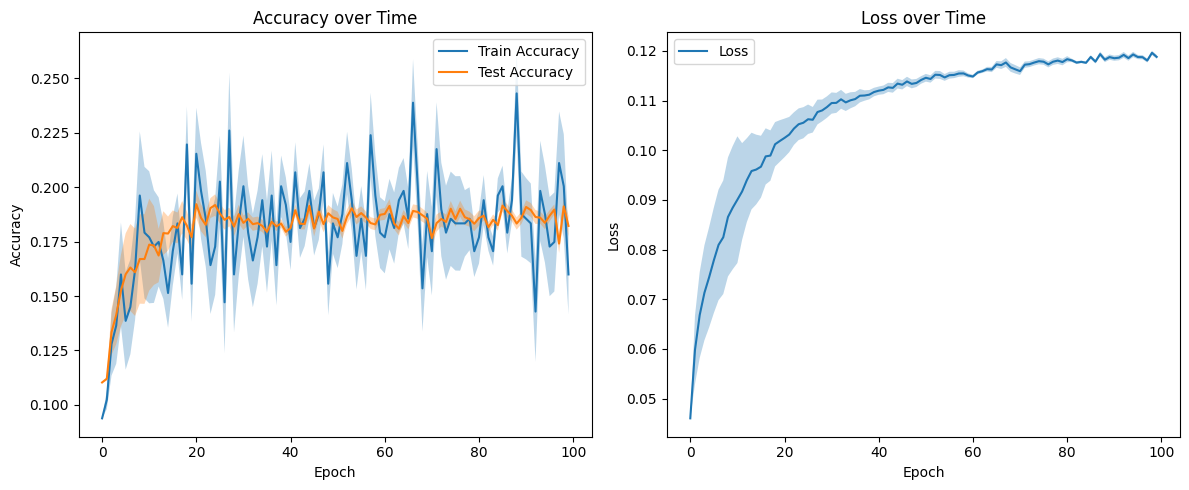

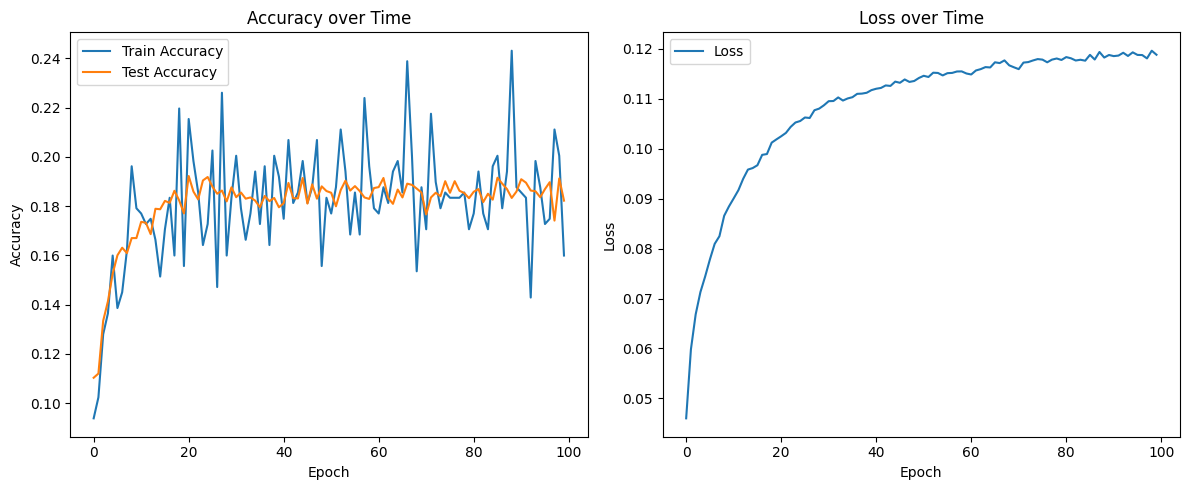

Final Train Accuracy: 0.16 ± 0.02
Final Test Accuracy: 0.18 ± 0.00
(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


MLP_MNIST_0_1730653966:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 44 total: 469
loss: 0.05295951280798485
 Train accuracy:  0.09381663113006397 | 


MLP_MNIST_0_1730653966:   1%|          | 1/100 [00:04<07:35,  4.60s/it]

 Test accuracy:  0.4038

correct: 48 total: 469
loss: 0.06525303767338744
 Train accuracy:  0.1023454157782516 | 


MLP_MNIST_0_1730653966:   2%|▏         | 2/100 [00:09<07:44,  4.74s/it]

 Test accuracy:  0.481

correct: 260 total: 469
loss: 0.07537922777855066
 Train accuracy:  0.5543710021321961 | 


MLP_MNIST_0_1730653966:   3%|▎         | 3/100 [00:14<07:46,  4.81s/it]

 Test accuracy:  0.5973

correct: 280 total: 469
loss: 0.08530609889515936
 Train accuracy:  0.5970149253731343 | 


MLP_MNIST_0_1730653966:   4%|▍         | 4/100 [00:19<07:48,  4.88s/it]

 Test accuracy:  0.6347

correct: 313 total: 469
loss: 0.09022916248167502
 Train accuracy:  0.6673773987206824 | 


MLP_MNIST_0_1730653966:   5%|▌         | 5/100 [00:24<07:49,  4.94s/it]

 Test accuracy:  0.6657

correct: 319 total: 469
loss: 0.09436335864224668
 Train accuracy:  0.6801705756929638 | 


MLP_MNIST_0_1730653966:   6%|▌         | 6/100 [00:29<07:46,  4.96s/it]

 Test accuracy:  0.6856

correct: 327 total: 469
loss: 0.09727384240578996
 Train accuracy:  0.697228144989339 | 


MLP_MNIST_0_1730653966:   7%|▋         | 7/100 [00:34<07:39,  4.95s/it]

 Test accuracy:  0.6924

correct: 307 total: 469
loss: 0.10039328175312928
 Train accuracy:  0.6545842217484008 | 


MLP_MNIST_0_1730653966:   8%|▊         | 8/100 [00:39<07:33,  4.93s/it]

 Test accuracy:  0.7067

correct: 333 total: 469
loss: 0.10295690708894974
 Train accuracy:  0.7100213219616205 | 


MLP_MNIST_0_1730653966:   9%|▉         | 9/100 [00:44<07:26,  4.90s/it]

 Test accuracy:  0.7134

correct: 323 total: 469
loss: 0.10559773270382301
 Train accuracy:  0.6886993603411514 | 


MLP_MNIST_0_1730653966:  10%|█         | 10/100 [00:48<07:20,  4.90s/it]

 Test accuracy:  0.7129

correct: 326 total: 469
loss: 0.10621127338488219
 Train accuracy:  0.6950959488272921 | 


MLP_MNIST_0_1730653966:  11%|█         | 11/100 [00:53<07:16,  4.90s/it]

 Test accuracy:  0.7296

correct: 338 total: 469
loss: 0.1081988217352804
 Train accuracy:  0.720682302771855 | 


MLP_MNIST_0_1730653966:  12%|█▏        | 12/100 [00:58<07:12,  4.91s/it]

 Test accuracy:  0.727

correct: 341 total: 469
loss: 0.10993474915718981
 Train accuracy:  0.7270788912579957 | 


MLP_MNIST_0_1730653966:  13%|█▎        | 13/100 [01:03<07:09,  4.93s/it]

 Test accuracy:  0.7345

correct: 342 total: 469
loss: 0.11061007316623415
 Train accuracy:  0.7292110874200426 | 


MLP_MNIST_0_1730653966:  14%|█▍        | 14/100 [01:08<07:03,  4.93s/it]

 Test accuracy:  0.7355

correct: 325 total: 469
loss: 0.11163654848774358
 Train accuracy:  0.6929637526652452 | 


MLP_MNIST_0_1730653966:  15%|█▌        | 15/100 [01:13<06:59,  4.93s/it]

 Test accuracy:  0.7333

correct: 353 total: 469
loss: 0.11256353048754654
 Train accuracy:  0.7526652452025586 | 


MLP_MNIST_0_1730653966:  16%|█▌        | 16/100 [01:18<06:56,  4.95s/it]

 Test accuracy:  0.741

correct: 353 total: 469
loss: 0.11274973727238458
 Train accuracy:  0.7526652452025586 | 


MLP_MNIST_0_1730653966:  17%|█▋        | 17/100 [01:23<06:53,  4.98s/it]

 Test accuracy:  0.7375

correct: 342 total: 469
loss: 0.11417660358618063
 Train accuracy:  0.7292110874200426 | 


MLP_MNIST_0_1730653966:  18%|█▊        | 18/100 [01:28<06:52,  5.03s/it]

 Test accuracy:  0.7413

correct: 352 total: 469
loss: 0.11426059695195033
 Train accuracy:  0.7505330490405118 | 


MLP_MNIST_0_1730653966:  19%|█▉        | 19/100 [01:34<06:56,  5.15s/it]

 Test accuracy:  0.745

correct: 338 total: 469
loss: 0.11418842158909799
 Train accuracy:  0.720682302771855 | 


MLP_MNIST_0_1730653966:  20%|██        | 20/100 [01:39<06:49,  5.12s/it]

 Test accuracy:  0.7387

correct: 343 total: 469
loss: 0.11464989592017395
 Train accuracy:  0.7313432835820896 | 


MLP_MNIST_0_1730653966:  21%|██        | 21/100 [01:44<06:44,  5.12s/it]

 Test accuracy:  0.7422

correct: 331 total: 469
loss: 0.11545027430250701
 Train accuracy:  0.7057569296375267 | 


MLP_MNIST_0_1730653966:  22%|██▏       | 22/100 [01:49<06:35,  5.07s/it]

 Test accuracy:  0.7488

correct: 356 total: 469
loss: 0.11668096741697173
 Train accuracy:  0.7590618336886994 | 


MLP_MNIST_0_1730653966:  23%|██▎       | 23/100 [01:54<06:31,  5.08s/it]

 Test accuracy:  0.7429

correct: 336 total: 469
loss: 0.116689587039734
 Train accuracy:  0.7164179104477612 | 


MLP_MNIST_0_1730653966:  24%|██▍       | 24/100 [01:59<06:25,  5.08s/it]

 Test accuracy:  0.7415

correct: 347 total: 469
loss: 0.1162510671531722
 Train accuracy:  0.7398720682302772 | 


MLP_MNIST_0_1730653966:  25%|██▌       | 25/100 [02:04<06:25,  5.14s/it]

 Test accuracy:  0.7438

correct: 342 total: 469
loss: 0.11701697538465833
 Train accuracy:  0.7292110874200426 | 


MLP_MNIST_0_1730653966:  26%|██▌       | 26/100 [02:09<06:18,  5.11s/it]

 Test accuracy:  0.746

correct: 341 total: 469
loss: 0.11745654122788769
 Train accuracy:  0.7270788912579957 | 


MLP_MNIST_0_1730653966:  27%|██▋       | 27/100 [02:14<06:13,  5.12s/it]

 Test accuracy:  0.7444

correct: 362 total: 469
loss: 0.11785373561926234
 Train accuracy:  0.7718550106609808 | 


MLP_MNIST_0_1730653966:  28%|██▊       | 28/100 [02:20<06:11,  5.16s/it]

 Test accuracy:  0.7466

correct: 332 total: 469
loss: 0.1175879233204988
 Train accuracy:  0.7078891257995735 | 


MLP_MNIST_0_1730653966:  29%|██▉       | 29/100 [02:25<06:06,  5.16s/it]

 Test accuracy:  0.7457

correct: 333 total: 469
loss: 0.11826395982109916
 Train accuracy:  0.7100213219616205 | 


MLP_MNIST_0_1730653966:  30%|███       | 30/100 [02:30<05:56,  5.10s/it]

 Test accuracy:  0.7493

correct: 350 total: 469
loss: 0.11798662123586069
 Train accuracy:  0.746268656716418 | 


MLP_MNIST_0_1730653966:  31%|███       | 31/100 [02:35<05:53,  5.12s/it]

 Test accuracy:  0.7439

correct: 338 total: 469
loss: 0.1186730870083451
 Train accuracy:  0.720682302771855 | 


MLP_MNIST_0_1730653966:  32%|███▏      | 32/100 [02:40<05:45,  5.09s/it]

 Test accuracy:  0.7432

correct: 355 total: 469
loss: 0.11940646447987953
 Train accuracy:  0.7569296375266524 | 


MLP_MNIST_0_1730653966:  33%|███▎      | 33/100 [02:45<05:40,  5.08s/it]

 Test accuracy:  0.7532

correct: 350 total: 469
loss: 0.11860995101077217
 Train accuracy:  0.746268656716418 | 


MLP_MNIST_0_1730653966:  34%|███▍      | 34/100 [02:50<05:35,  5.08s/it]

 Test accuracy:  0.7435

correct: 331 total: 469
loss: 0.11968655960519177
 Train accuracy:  0.7057569296375267 | 


MLP_MNIST_0_1730653966:  35%|███▌      | 35/100 [02:55<05:31,  5.10s/it]

 Test accuracy:  0.7486

correct: 343 total: 469
loss: 0.11944306851513604
 Train accuracy:  0.7313432835820896 | 


MLP_MNIST_0_1730653966:  36%|███▌      | 36/100 [03:00<05:26,  5.11s/it]

 Test accuracy:  0.7487

correct: 325 total: 469
loss: 0.12063720406118486
 Train accuracy:  0.6929637526652452 | 


MLP_MNIST_0_1730653966:  37%|███▋      | 37/100 [03:06<05:25,  5.17s/it]

 Test accuracy:  0.7446

correct: 363 total: 469
loss: 0.12004758150719885
 Train accuracy:  0.7739872068230277 | 


MLP_MNIST_0_1730653966:  38%|███▊      | 38/100 [03:11<05:18,  5.14s/it]

 Test accuracy:  0.7423

correct: 334 total: 469
loss: 0.12090016594891355
 Train accuracy:  0.7121535181236673 | 


MLP_MNIST_0_1730653966:  39%|███▉      | 39/100 [03:16<05:14,  5.15s/it]

 Test accuracy:  0.7431

correct: 348 total: 469
loss: 0.1203016916127093
 Train accuracy:  0.7420042643923241 | 


MLP_MNIST_0_1730653966:  40%|████      | 40/100 [03:21<05:10,  5.17s/it]

 Test accuracy:  0.7491

correct: 342 total: 469
loss: 0.12081188424182598
 Train accuracy:  0.7292110874200426 | 


MLP_MNIST_0_1730653966:  41%|████      | 41/100 [03:26<05:05,  5.18s/it]

 Test accuracy:  0.749

correct: 346 total: 469
loss: 0.12035830971846448
 Train accuracy:  0.7377398720682303 | 


MLP_MNIST_0_1730653966:  42%|████▏     | 42/100 [03:32<05:00,  5.18s/it]

 Test accuracy:  0.749

correct: 342 total: 469
loss: 0.12005868638311622
 Train accuracy:  0.7292110874200426 | 


MLP_MNIST_0_1730653966:  43%|████▎     | 43/100 [03:37<04:58,  5.23s/it]

 Test accuracy:  0.7429

correct: 352 total: 469
loss: 0.1210519511943687
 Train accuracy:  0.7505330490405118 | 


MLP_MNIST_0_1730653966:  44%|████▍     | 44/100 [03:42<04:50,  5.19s/it]

 Test accuracy:  0.7456

correct: 364 total: 469
loss: 0.12115536673046125
 Train accuracy:  0.7761194029850746 | 


MLP_MNIST_0_1730653966:  45%|████▌     | 45/100 [03:47<04:45,  5.20s/it]

 Test accuracy:  0.7462

correct: 355 total: 469
loss: 0.12081798459929444
 Train accuracy:  0.7569296375266524 | 


MLP_MNIST_0_1730653966:  46%|████▌     | 46/100 [03:53<04:43,  5.25s/it]

 Test accuracy:  0.7439

correct: 349 total: 469
loss: 0.12108781287220241
 Train accuracy:  0.744136460554371 | 


MLP_MNIST_0_1730653966:  47%|████▋     | 47/100 [03:58<04:35,  5.21s/it]

 Test accuracy:  0.7461

correct: 344 total: 469
loss: 0.12118292636454486
 Train accuracy:  0.7334754797441365 | 


MLP_MNIST_0_1730653966:  48%|████▊     | 48/100 [04:03<04:30,  5.19s/it]

 Test accuracy:  0.7459

correct: 350 total: 469
loss: 0.12162835295520612
 Train accuracy:  0.746268656716418 | 


MLP_MNIST_0_1730653966:  49%|████▉     | 49/100 [04:08<04:28,  5.26s/it]

 Test accuracy:  0.748

correct: 342 total: 469
loss: 0.12267687923110115
 Train accuracy:  0.7292110874200426 | 


MLP_MNIST_0_1730653966:  50%|█████     | 50/100 [04:14<04:23,  5.27s/it]

 Test accuracy:  0.7459

correct: 357 total: 469
loss: 0.12137577731980444
 Train accuracy:  0.7611940298507462 | 


MLP_MNIST_0_1730653966:  51%|█████     | 51/100 [04:19<04:18,  5.27s/it]

 Test accuracy:  0.7486

correct: 341 total: 469
loss: 0.12137826188985727
 Train accuracy:  0.7270788912579957 | 


MLP_MNIST_0_1730653966:  52%|█████▏    | 52/100 [04:24<04:12,  5.26s/it]

 Test accuracy:  0.7468

correct: 344 total: 469
loss: 0.12205073698116009
 Train accuracy:  0.7334754797441365 | 


MLP_MNIST_0_1730653966:  53%|█████▎    | 53/100 [04:29<04:05,  5.23s/it]

 Test accuracy:  0.7375

correct: 348 total: 469
loss: 0.12226205368413091
 Train accuracy:  0.7420042643923241 | 


MLP_MNIST_0_1730653966:  54%|█████▍    | 54/100 [04:34<03:59,  5.20s/it]

 Test accuracy:  0.7484

correct: 341 total: 469
loss: 0.12213355533159109
 Train accuracy:  0.7270788912579957 | 


MLP_MNIST_0_1730653966:  55%|█████▌    | 55/100 [04:40<03:54,  5.20s/it]

 Test accuracy:  0.7471

correct: 358 total: 469
loss: 0.12256409625000537
 Train accuracy:  0.7633262260127932 | 


MLP_MNIST_0_1730653966:  56%|█████▌    | 56/100 [04:45<03:48,  5.20s/it]

 Test accuracy:  0.745

correct: 341 total: 469
loss: 0.1213346109715606
 Train accuracy:  0.7270788912579957 | 


MLP_MNIST_0_1730653966:  57%|█████▋    | 57/100 [04:50<03:43,  5.19s/it]

 Test accuracy:  0.7408

correct: 340 total: 469
loss: 0.12232044366186362
 Train accuracy:  0.7249466950959488 | 


MLP_MNIST_0_1730653966:  58%|█████▊    | 58/100 [04:55<03:38,  5.21s/it]

 Test accuracy:  0.7433

correct: 333 total: 469
loss: 0.12211451269606792
 Train accuracy:  0.7100213219616205 | 


MLP_MNIST_0_1730653966:  59%|█████▉    | 59/100 [05:00<03:32,  5.19s/it]

 Test accuracy:  0.7429

correct: 345 total: 469
loss: 0.12306590634050654
 Train accuracy:  0.7356076759061834 | 


MLP_MNIST_0_1730653966:  60%|██████    | 60/100 [05:06<03:28,  5.21s/it]

 Test accuracy:  0.7474

correct: 347 total: 469
loss: 0.12253027831885352
 Train accuracy:  0.7398720682302772 | 


MLP_MNIST_0_1730653966:  61%|██████    | 61/100 [05:11<03:24,  5.25s/it]

 Test accuracy:  0.7467

correct: 341 total: 469
loss: 0.1225191992419615
 Train accuracy:  0.7270788912579957 | 


MLP_MNIST_0_1730653966:  62%|██████▏   | 62/100 [05:16<03:21,  5.30s/it]

 Test accuracy:  0.7485

correct: 345 total: 469
loss: 0.12267387863288302
 Train accuracy:  0.7356076759061834 | 


MLP_MNIST_0_1730653966:  63%|██████▎   | 63/100 [05:22<03:16,  5.30s/it]

 Test accuracy:  0.7446

correct: 342 total: 469
loss: 0.1237442561272365
 Train accuracy:  0.7292110874200426 | 


MLP_MNIST_0_1730653966:  64%|██████▍   | 64/100 [05:27<03:11,  5.32s/it]

 Test accuracy:  0.7496

correct: 336 total: 469
loss: 0.12312840122276786
 Train accuracy:  0.7164179104477612 | 


MLP_MNIST_0_1730653966:  65%|██████▌   | 65/100 [05:32<03:05,  5.29s/it]

 Test accuracy:  0.747

correct: 339 total: 469
loss: 0.12345434488581696
 Train accuracy:  0.7228144989339019 | 


MLP_MNIST_0_1730653966:  66%|██████▌   | 66/100 [05:38<02:59,  5.29s/it]

 Test accuracy:  0.7419

correct: 342 total: 469
loss: 0.12367697819463734
 Train accuracy:  0.7292110874200426 | 


MLP_MNIST_0_1730653966:  67%|██████▋   | 67/100 [05:43<02:55,  5.31s/it]

 Test accuracy:  0.7458

correct: 339 total: 469
loss: 0.12322449863655989
 Train accuracy:  0.7228144989339019 | 


MLP_MNIST_0_1730653966:  68%|██████▊   | 68/100 [05:48<02:48,  5.27s/it]

 Test accuracy:  0.7459

correct: 337 total: 469
loss: 0.12307280497446751
 Train accuracy:  0.7185501066098081 | 


MLP_MNIST_0_1730653966:  69%|██████▉   | 69/100 [05:53<02:43,  5.27s/it]

 Test accuracy:  0.744

correct: 342 total: 469
loss: 0.1239011975875033
 Train accuracy:  0.7292110874200426 | 


MLP_MNIST_0_1730653966:  70%|███████   | 70/100 [05:59<02:38,  5.29s/it]

 Test accuracy:  0.7452

correct: 351 total: 469
loss: 0.12373030458940372
 Train accuracy:  0.7484008528784648 | 


MLP_MNIST_0_1730653966:  71%|███████   | 71/100 [06:04<02:34,  5.33s/it]

 Test accuracy:  0.7479

correct: 336 total: 469
loss: 0.12357135681010513
 Train accuracy:  0.7164179104477612 | 


MLP_MNIST_0_1730653966:  72%|███████▏  | 72/100 [06:10<02:29,  5.34s/it]

 Test accuracy:  0.739

correct: 355 total: 469
loss: 0.12373849087114781
 Train accuracy:  0.7569296375266524 | 


MLP_MNIST_0_1730653966:  73%|███████▎  | 73/100 [06:15<02:25,  5.40s/it]

 Test accuracy:  0.7428

correct: 344 total: 469
loss: 0.12361628041147932
 Train accuracy:  0.7334754797441365 | 


MLP_MNIST_0_1730653966:  74%|███████▍  | 74/100 [06:20<02:20,  5.39s/it]

 Test accuracy:  0.7463

correct: 351 total: 469
loss: 0.12360311274144695
 Train accuracy:  0.7484008528784648 | 


MLP_MNIST_0_1730653966:  75%|███████▌  | 75/100 [06:26<02:14,  5.38s/it]

 Test accuracy:  0.7461

correct: 338 total: 469
loss: 0.12350768405300722
 Train accuracy:  0.720682302771855 | 


MLP_MNIST_0_1730653966:  76%|███████▌  | 76/100 [06:31<02:11,  5.47s/it]

 Test accuracy:  0.749

correct: 347 total: 469
loss: 0.1238975886469965
 Train accuracy:  0.7398720682302772 | 


MLP_MNIST_0_1730653966:  77%|███████▋  | 77/100 [06:37<02:04,  5.42s/it]

 Test accuracy:  0.7512

correct: 352 total: 469
loss: 0.12415524043126909
 Train accuracy:  0.7505330490405118 | 


MLP_MNIST_0_1730653966:  78%|███████▊  | 78/100 [06:42<01:58,  5.39s/it]

 Test accuracy:  0.7446

correct: 344 total: 469
loss: 0.12418423588278452
 Train accuracy:  0.7334754797441365 | 


MLP_MNIST_0_1730653966:  79%|███████▉  | 79/100 [06:48<01:55,  5.48s/it]

 Test accuracy:  0.7417

correct: 338 total: 469
loss: 0.12445861334676173
 Train accuracy:  0.720682302771855 | 


MLP_MNIST_0_1730653966:  80%|████████  | 80/100 [06:53<01:49,  5.47s/it]

 Test accuracy:  0.7493

correct: 338 total: 469
loss: 0.12376750042951946
 Train accuracy:  0.720682302771855 | 


MLP_MNIST_0_1730653966:  81%|████████  | 81/100 [06:59<01:42,  5.42s/it]

 Test accuracy:  0.7425

correct: 343 total: 469
loss: 0.12427984830984937
 Train accuracy:  0.7313432835820896 | 


MLP_MNIST_0_1730653966:  82%|████████▏ | 82/100 [07:04<01:37,  5.42s/it]

 Test accuracy:  0.7462

correct: 354 total: 469
loss: 0.1239963686351837
 Train accuracy:  0.7547974413646056 | 


MLP_MNIST_0_1730653966:  83%|████████▎ | 83/100 [07:09<01:31,  5.40s/it]

 Test accuracy:  0.7429

correct: 349 total: 469
loss: 0.12393911085975196
 Train accuracy:  0.744136460554371 | 


MLP_MNIST_0_1730653966:  84%|████████▍ | 84/100 [07:15<01:26,  5.41s/it]

 Test accuracy:  0.7452

correct: 348 total: 469
loss: 0.12430126304184196
 Train accuracy:  0.7420042643923241 | 


MLP_MNIST_0_1730653966:  85%|████████▌ | 85/100 [07:20<01:22,  5.49s/it]

 Test accuracy:  0.7401

correct: 350 total: 469
loss: 0.12360106567457033
 Train accuracy:  0.746268656716418 | 


MLP_MNIST_0_1730653966:  86%|████████▌ | 86/100 [07:26<01:16,  5.50s/it]

 Test accuracy:  0.7477

correct: 345 total: 469
loss: 0.12468817666458931
 Train accuracy:  0.7356076759061834 | 


MLP_MNIST_0_1730653966:  87%|████████▋ | 87/100 [07:31<01:11,  5.50s/it]

 Test accuracy:  0.7434

correct: 348 total: 469
loss: 0.12402247537427874
 Train accuracy:  0.7420042643923241 | 


MLP_MNIST_0_1730653966:  88%|████████▊ | 88/100 [07:37<01:06,  5.50s/it]

 Test accuracy:  0.7503

correct: 342 total: 469
loss: 0.12419109219617681
 Train accuracy:  0.7292110874200426 | 


MLP_MNIST_0_1730653966:  89%|████████▉ | 89/100 [07:42<01:00,  5.50s/it]

 Test accuracy:  0.7422

correct: 345 total: 469
loss: 0.1246669544562348
 Train accuracy:  0.7356076759061834 | 


MLP_MNIST_0_1730653966:  90%|█████████ | 90/100 [07:48<00:55,  5.52s/it]

 Test accuracy:  0.746

correct: 355 total: 469
loss: 0.12437471062707495
 Train accuracy:  0.7569296375266524 | 


MLP_MNIST_0_1730653966:  91%|█████████ | 91/100 [07:54<00:49,  5.51s/it]

 Test accuracy:  0.7434

correct: 339 total: 469
loss: 0.12535034935039752
 Train accuracy:  0.7228144989339019 | 


MLP_MNIST_0_1730653966:  92%|█████████▏| 92/100 [07:59<00:43,  5.47s/it]

 Test accuracy:  0.7447

correct: 333 total: 469
loss: 0.12480541485459057
 Train accuracy:  0.7100213219616205 | 


MLP_MNIST_0_1730653966:  93%|█████████▎| 93/100 [08:04<00:38,  5.47s/it]

 Test accuracy:  0.7514

correct: 351 total: 469
loss: 0.1248929180474932
 Train accuracy:  0.7484008528784648 | 


MLP_MNIST_0_1730653966:  94%|█████████▍| 94/100 [08:10<00:32,  5.47s/it]

 Test accuracy:  0.7434

correct: 351 total: 469
loss: 0.12428244567120761
 Train accuracy:  0.7484008528784648 | 


MLP_MNIST_0_1730653966:  95%|█████████▌| 95/100 [08:15<00:27,  5.49s/it]

 Test accuracy:  0.7422

correct: 345 total: 469
loss: 0.12465872855455891
 Train accuracy:  0.7356076759061834 | 


MLP_MNIST_0_1730653966:  96%|█████████▌| 96/100 [08:21<00:22,  5.51s/it]

 Test accuracy:  0.7482

correct: 332 total: 469
loss: 0.12478964510502846
 Train accuracy:  0.7078891257995735 | 


MLP_MNIST_0_1730653966:  97%|█████████▋| 97/100 [08:26<00:16,  5.52s/it]

 Test accuracy:  0.7419

correct: 361 total: 469
loss: 0.12475201263547198
 Train accuracy:  0.7697228144989339 | 


MLP_MNIST_0_1730653966:  98%|█████████▊| 98/100 [08:32<00:10,  5.49s/it]

 Test accuracy:  0.7488

correct: 322 total: 469
loss: 0.12408051091724875
 Train accuracy:  0.6865671641791045 | 


MLP_MNIST_0_1730653966:  99%|█████████▉| 99/100 [08:37<00:05,  5.47s/it]

 Test accuracy:  0.7445

correct: 342 total: 469
loss: 0.12489392069865392
 Train accuracy:  0.7292110874200426 | 


MLP_MNIST_0_1730653966: 100%|██████████| 100/100 [08:43<00:00,  5.23s/it]

 Test accuracy:  0.7488


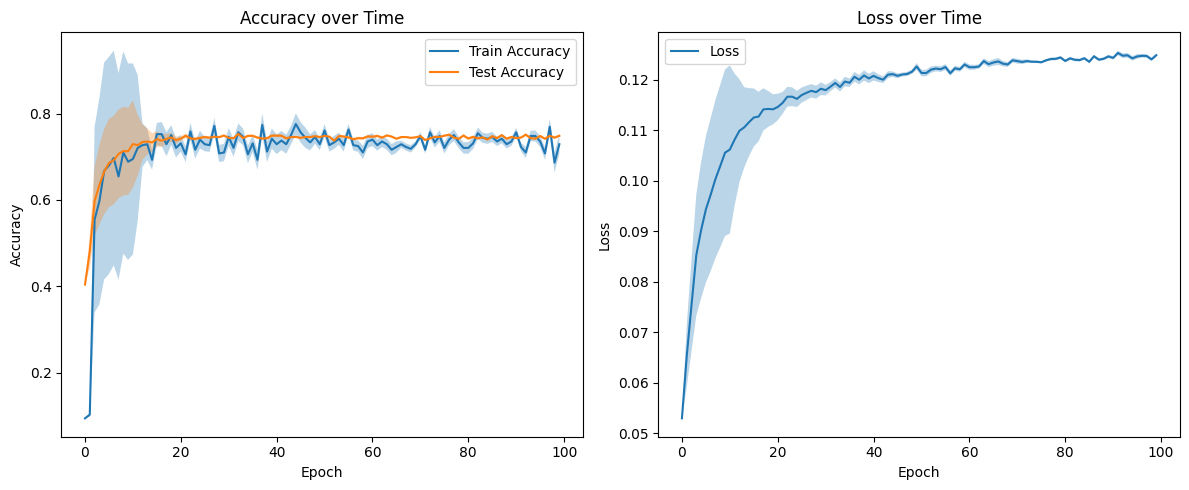

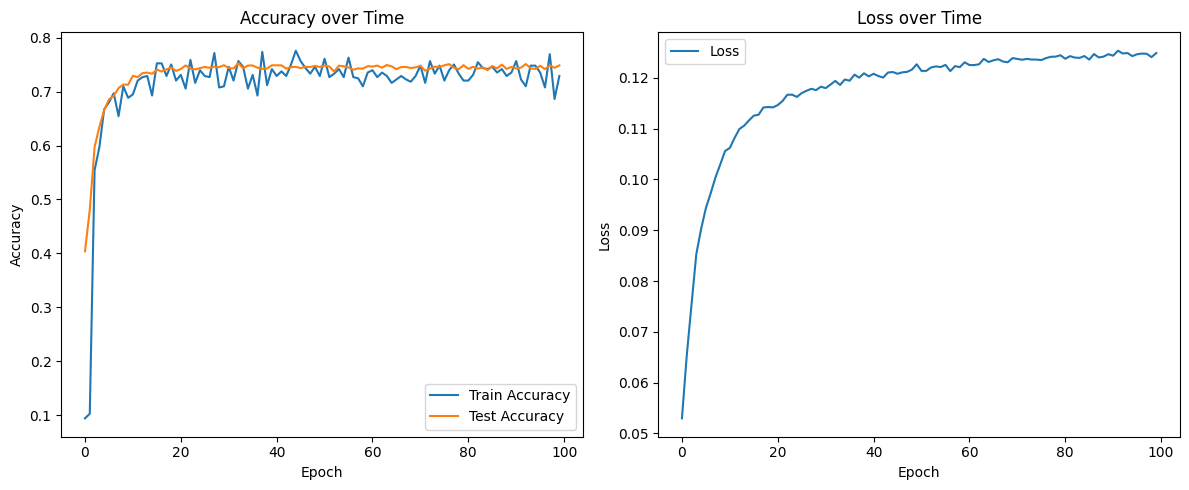

Final Train Accuracy: 0.73 ± 0.02
Final Test Accuracy: 0.75 ± 0.00
bernoulli - Final Train Accuracy: 0.57 ± 0.03
bernoulli - Final Test Accuracy: 0.58 ± 0.00
gumbel_softmax - Final Train Accuracy: 0.15 ± 0.01
gumbel_softmax - Final Test Accuracy: 0.18 ± 0.00
gaussian - Final Train Accuracy: 0.22 ± 0.01
gaussian - Final Test Accuracy: 0.21 ± 0.00
beta - Final Train Accuracy: 0.79 ± 0.02
beta - Final Test Accuracy: 0.78 ± 0.00
dirichlet - Final Train Accuracy: 0.17 ± 0.02
dirichlet - Final Test Accuracy: 0.22 ± 0.00
multinomial - Final Train Accuracy: 0.10 ± 0.02
multinomial - Final Test Accuracy: 0.12 ± 0.00
cauchy - Final Train Accuracy: 0.12 ± 0.01
cauchy - Final Test Accuracy: 0.12 ± 0.00
laplace - Final Train Accuracy: 0.16 ± 0.02
laplace - Final Test Accuracy: 0.18 ± 0.00
uniform - Final Train Accuracy: 0.73 ± 0.02
uniform - Final Test Accuracy: 0.75 ± 0.00


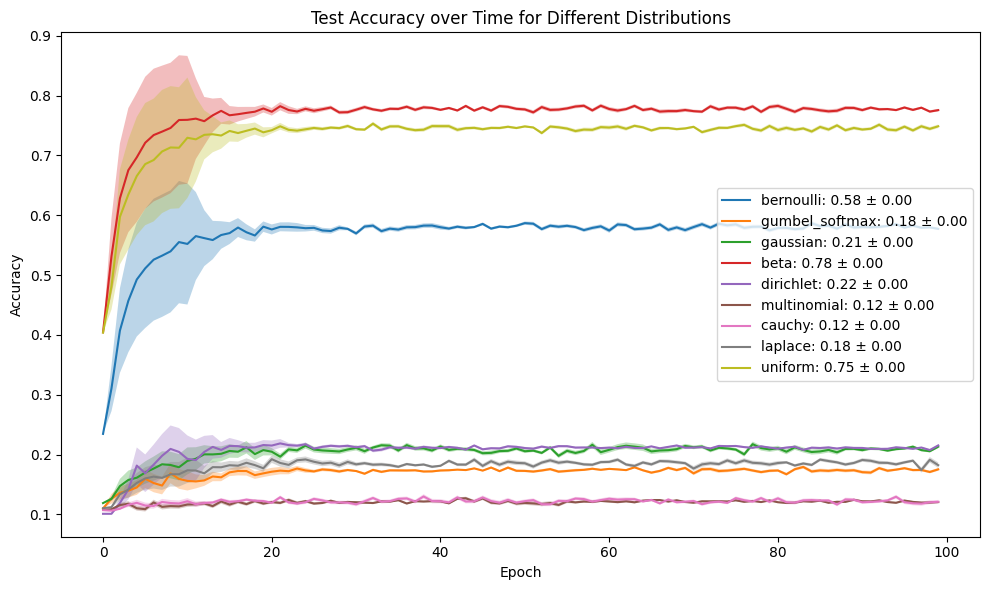

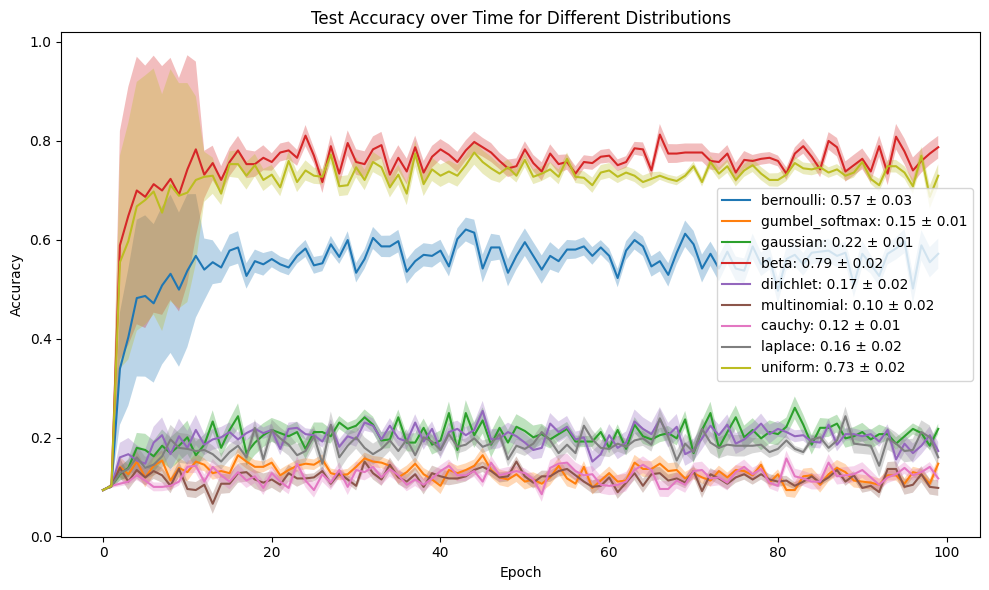

In [9]:


import csv
import numpy as np
import matplotlib.pyplot as plt

# List of distributions to iterate over
distributions = ["bernoulli", "gumbel_softmax", "gaussian", "beta", "dirichlet", "multinomial", "cauchy", "laplace", "uniform"]

# Configuration
config = {
    "batch_size": 128,
    "n_epochs": 100,
    "gamma": 0.8,
    "learning_rate": 1e-3,
    "weight_decay": 1e-4,
    "width": 32,
    "grid": 3,
    "method": "MLP",  # "MLP", "KAN"
    "seed": 0,
    "input_size": 8 * 8, # number of features
    "output_size": 10, # number of classes
    "buffer_size": 100000,
    "target_update": 10,
    "warm_up_episodes": 2,
    "num_filters": 2,
    "num_conv_layers": 1,
    "first_channel": 1, # (1,8,8)
    "hidden_dim": 128,
    "feature_selection": True,
    "initial_tau": 1.0, # positive float value
}

# Function to run kanRL and collect results
def run_experiment(distribution):
    config["distribution"] = distribution
    q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

    return train_accuracies, test_accuracies, losses, train_acc_stds, test_acc_stds, loss_stds

# Initialize results dictionary
results = {dist: {} for dist in distributions}

# Run experiments for each distribution
for distribution in distributions:
    train_accuracies, test_accuracies, losses, train_acc_stds, test_acc_stds, loss_stds = run_experiment(distribution)

    results[distribution]['train_accuracies'] = train_accuracies
    results[distribution]['test_accuracies'] = test_accuracies
    results[distribution]['losses'] = losses
    results[distribution]['train_acc_stds'] = train_acc_stds
    results[distribution]['test_acc_stds'] = test_acc_stds
    results[distribution]['loss_stds'] = loss_stds

    # Save train accuracies and stds
    with open(f'MLP_{distribution}.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Epoch', 'Train Accuracy', 'Train Accuracy Std', 'Test Accuracy', 'Test Accuracy Std', 'Loss', 'Loss Std'])
        for epoch, (train_acc, train_acc_std, test_acc, test_acc_std, loss, loss_std) in enumerate(zip(train_accuracies, train_acc_stds, test_accuracies, test_acc_stds, losses, loss_stds)):
            writer.writerow([epoch, train_acc, train_acc_std, test_acc, test_acc_std, loss, loss_std])


# Print final accuracies with +/- errors for each distribution
for distribution in distributions:
    final_train_accuracy = results[distribution]['train_accuracies'][-1]
    final_train_acc_std = results[distribution]['train_acc_stds'][-1]
    final_test_accuracy = results[distribution]['test_accuracies'][-1]
    final_test_acc_std = results[distribution]['test_acc_stds'][-1]

    print(f"{distribution} - Final Train Accuracy: {final_train_accuracy:.2f} ± {final_train_acc_std:.2f}")
    print(f"{distribution} - Final Test Accuracy: {final_test_accuracy:.2f} ± {final_test_acc_std:.2f}")



# Plotting: Test accuracy
epochs = np.arange(config["n_epochs"])

plt.figure(figsize=(10, 6))

for distribution in distributions:
    final_train_accuracy = results[distribution]['train_accuracies'][-1]
    final_train_acc_std = results[distribution]['train_acc_stds'][-1]
    final_test_accuracy = results[distribution]['test_accuracies'][-1]
    final_test_acc_std = results[distribution]['test_acc_stds'][-1]
    plt.plot(epochs, results[distribution]['test_accuracies'], label=f'{distribution}: {final_test_accuracy:.2f} ± {final_test_acc_std:.2f}')
    plt.fill_between(epochs, np.array(results[distribution]['test_accuracies']) - np.array(results[distribution]['test_acc_stds']),
                     np.array(results[distribution]['test_accuracies']) + np.array(results[distribution]['test_acc_stds']), alpha=0.3)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test Accuracy over Time for Different Distributions')

plt.tight_layout()
plt.savefig('MLP_test_comparison_plot.png', dpi=300)
plt.show()


# Plotting: Train accuracy
epochs = np.arange(config["n_epochs"])

plt.figure(figsize=(10, 6))

for distribution in distributions:
    final_train_accuracy = results[distribution]['train_accuracies'][-1]
    final_train_acc_std = results[distribution]['train_acc_stds'][-1]
    final_test_accuracy = results[distribution]['test_accuracies'][-1]
    final_test_acc_std = results[distribution]['test_acc_stds'][-1]
    plt.plot(epochs, results[distribution]['train_accuracies'], label=f'{distribution}: {final_train_accuracy:.2f} ± {final_train_acc_std:.2f}')
    plt.fill_between(epochs, np.array(results[distribution]['train_accuracies']) - np.array(results[distribution]['train_acc_stds']),
                     np.array(results[distribution]['train_accuracies']) + np.array(results[distribution]['train_acc_stds']), alpha=0.3)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test Accuracy over Time for Different Distributions')

plt.tight_layout()
plt.savefig('MLP_train_comparison_plot.png', dpi=300)
plt.show()




## KAN

In [ ]:


import csv
import numpy as np
import matplotlib.pyplot as plt

# List of distributions to iterate over
distributions = ["bernoulli", "gumbel_softmax", "gaussian", "beta", "dirichlet", "multinomial", "cauchy", "laplace", "uniform"]

# Configuration
config = {
    "batch_size": 128,
    "n_epochs": 100,
    "gamma": 0.8,
    "learning_rate": 1e-3,
    "weight_decay": 1e-4,
    "width": 8,
    "grid": 3,
    "method": "KAN",  # "MLP", "KAN"
    "seed": 0,
    "input_size": 8 * 8, # number of features
    "output_size": 10, # number of classes
    "buffer_size": 100000,
    "target_update": 10,
    "warm_up_episodes": 2,
    "num_filters": 2,
    "num_conv_layers": 1,
    "first_channel": 1, # (1,8,8)
    "hidden_dim": 128,
    "feature_selection": True,
    "initial_tau": 1.0, # positive float value
}

# Function to run kanRL and collect results
def run_experiment(distribution):
    config["distribution"] = distribution
    q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

    return train_accuracies, test_accuracies, losses, train_acc_stds, test_acc_stds, loss_stds

# Initialize results dictionary
results = {dist: {} for dist in distributions}

# Run experiments for each distribution
for distribution in distributions:
    train_accuracies, test_accuracies, losses, train_acc_stds, test_acc_stds, loss_stds = run_experiment(distribution)

    results[distribution]['train_accuracies'] = train_accuracies
    results[distribution]['test_accuracies'] = test_accuracies
    results[distribution]['losses'] = losses
    results[distribution]['train_acc_stds'] = train_acc_stds
    results[distribution]['test_acc_stds'] = test_acc_stds
    results[distribution]['loss_stds'] = loss_stds

    # Save train accuracies and stds
    with open(f'MLP_{distribution}.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Epoch', 'Train Accuracy', 'Train Accuracy Std', 'Test Accuracy', 'Test Accuracy Std', 'Loss', 'Loss Std'])
        for epoch, (train_acc, train_acc_std, test_acc, test_acc_std, loss, loss_std) in enumerate(zip(train_accuracies, train_acc_stds, test_accuracies, test_acc_stds, losses, loss_stds)):
            writer.writerow([epoch, train_acc, train_acc_std, test_acc, test_acc_std, loss, loss_std])


# Print final accuracies with +/- errors for each distribution
for distribution in distributions:
    final_train_accuracy = results[distribution]['train_accuracies'][-1]
    final_train_acc_std = results[distribution]['train_acc_stds'][-1]
    final_test_accuracy = results[distribution]['test_accuracies'][-1]
    final_test_acc_std = results[distribution]['test_acc_stds'][-1]

    print(f"{distribution} - Final Train Accuracy: {final_train_accuracy:.2f} ± {final_train_acc_std:.2f}")
    print(f"{distribution} - Final Test Accuracy: {final_test_accuracy:.2f} ± {final_test_acc_std:.2f}")



# Plotting: Test accuracy
epochs = np.arange(config["n_epochs"])

plt.figure(figsize=(10, 6))

for distribution in distributions:
    final_train_accuracy = results[distribution]['train_accuracies'][-1]
    final_train_acc_std = results[distribution]['train_acc_stds'][-1]
    final_test_accuracy = results[distribution]['test_accuracies'][-1]
    final_test_acc_std = results[distribution]['test_acc_stds'][-1]
    plt.plot(epochs, results[distribution]['test_accuracies'], label=f'{distribution}: {final_test_accuracy:.2f} ± {final_test_acc_std:.2f}')
    plt.fill_between(epochs, np.array(results[distribution]['test_accuracies']) - np.array(results[distribution]['test_acc_stds']),
                     np.array(results[distribution]['test_accuracies']) + np.array(results[distribution]['test_acc_stds']), alpha=0.3)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test Accuracy over Time for Different Distributions')

plt.tight_layout()
plt.savefig('KAN_test_comparison_plot.png', dpi=300)
plt.show()


# Plotting: Train accuracy
epochs = np.arange(config["n_epochs"])

plt.figure(figsize=(10, 6))

for distribution in distributions:
    final_train_accuracy = results[distribution]['train_accuracies'][-1]
    final_train_acc_std = results[distribution]['train_acc_stds'][-1]
    final_test_accuracy = results[distribution]['test_accuracies'][-1]
    final_test_acc_std = results[distribution]['test_acc_stds'][-1]
    plt.plot(epochs, results[distribution]['train_accuracies'], label=f'{distribution}: {final_train_accuracy:.2f} ± {final_train_acc_std:.2f}')
    plt.fill_between(epochs, np.array(results[distribution]['train_accuracies']) - np.array(results[distribution]['train_acc_stds']),
                     np.array(results[distribution]['train_accuracies']) + np.array(results[distribution]['train_acc_stds']), alpha=0.3)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test Accuracy over Time for Different Distributions')

plt.tight_layout()
plt.savefig('KAN_train_comparison_plot.png', dpi=300)
plt.show()


